# Subclonal and clonal variants in SARS-CoV-2 derived from ENA dataset

**Background**

The ENA dataset (queried on 07/07/2021, n=44,371) provides the raw reads on which to perform variant calling with LoFreq. LoFreq annotates its variant calls with the observed VAF of the variant 
and it does not impose assumptions about the ploidy in order to allow for calling subclonal variants. We processed all these samples through the CoVigator pipeline through read trimming, alignment, deduplication, LoFreq variant calling, variant normalization and finally annotations. In the CoVigator analysis pipeline we annotate all variants with a frequency >= 0.8 as clonal, any
variant with a frequency < 0.8 as subclonal and furthermore any variant < 0.2 as low frequency.

**Motivation**

Although LoFreq applies a default filtering strategy on the variant calls, our dataset of subclonal variants is one order of magnitude larger than the clonal dataset. Some samples with extreme counts of clonal variants were excluded in the CoVigator knowledge base data loading. We want to assess here if we can define a procedure to determine a high confidence subclonal dataset.

Furthermore, we want to investigate if there is a temporal correlation between the appearance of subclonal variants and the appearance of clonal variants. We want to assess whether the subclonal dataset is fit to predict future clonal mutations.

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("poster")
import numpy as np
from matplotlib.ticker import ScalarFormatter 
from matplotlib_venn import venn2, venn2_circles
from upsetplot import UpSet

import warnings
warnings.filterwarnings('ignore')

import math

sns.set_context("notebook", font_scale=1.25)
sns.color_palette("colorblind")
sns.set(font_scale=2)
sns.set_style("whitegrid")

In [3]:
blue = sns.color_palette("colorblind")[0]
orange = sns.color_palette("colorblind")[1]
green = sns.color_palette("colorblind")[2]
red = sns.color_palette("colorblind")[3]
brown = sns.color_palette("colorblind")[5]
grey = sns.color_palette("colorblind")[7]
lightblue = sns.color_palette("colorblind")[-1]

In [4]:
SARS_COV_2_GENOME_LENGTH = 29903

## Data loading

In [5]:
data_folder = '../../data/db_dump_20221128/'
figure_output_folder = 'figures'

In [6]:
def load_data():
    clonal_variants = pd.read_csv(os.path.join(data_folder, 'variant_observation.csv.gz'))
    subclonal_variants = pd.read_csv(os.path.join(data_folder, 'subclonal_variant_observation.csv.gz'))
    low_frequency_variants = pd.read_csv(os.path.join(data_folder, 'low_frequency_variant_observation.csv.gz'))
    sample_ena = pd.read_csv(os.path.join(data_folder, 'sample_ena.csv.gz'))
    sample_ena["month"] = pd.to_datetime(sample_ena.collection_date, format='%Y-%m-%d', errors='coerce').dt.to_period('m')
    
    # filter out samples without a collection date
    sample_ena = sample_ena[~ sample_ena.collection_date.isna()]
    sample_ena = sample_ena[sample_ena.status == 'FINISHED']
    sample_ena['artic'] = sample_ena.library_name.transform(lambda x: "ARTIC" if x is not None and ('ARTIC' in str(x) or 'ARCTIC' in str(x)) else "Unknown")
    
    # annotates variants with sample metadata
    clonal_variants = pd.merge(left=clonal_variants, right=sample_ena[["run_accession", "library_strategy", "artic"]], 
             left_on="sample", right_on="run_accession", how="inner")
    subclonal_variants = pd.merge(left=subclonal_variants, right=sample_ena[["run_accession", "library_strategy", "artic"]], 
             left_on="sample", right_on="run_accession", how="inner")
    low_frequency_variants = pd.merge(left=low_frequency_variants, right=sample_ena[["run_accession", "library_strategy", "artic"]], 
             left_on="sample", right_on="run_accession", how="inner")
    
    print("Subclonal variant calls: {}".format(subclonal_variants.shape[0]))
    print("Clonal variant calls: {}".format(clonal_variants.shape[0]))
    print("Subclonal unique variants: {}".format(subclonal_variants.variant_id.unique().shape[0]))
    print("Clonal unique variants: {}".format(clonal_variants.variant_id.unique().shape[0]))
    print("Samples: {}".format(sample_ena.run_accession.unique().shape[0]))
    
    return clonal_variants, subclonal_variants, low_frequency_variants, sample_ena

In [7]:
high_quality_intrahost_variants = pd.read_csv(os.path.join(data_folder, 'conservative_intrahost_variants.csv.gz'))

In [8]:
clonal_variants, subclonal_variants, low_frequency_variants, sample_ena = load_data()

Subclonal variant calls: 2509458
Clonal variant calls: 4665192
Subclonal unique variants: 127425
Clonal unique variants: 33488
Samples: 135347


In [9]:
# add collection date to all variants
def add_dates_to_variants(variants, samples):
    variants_with_collection_date = pd.merge(
        left=variants[["variant_id", "sample", "cons_hmm_sars_cov_2", "gene_name", "hgvs_p"]], 
        right=samples[["run_accession", "collection_date"]], 
        left_on="sample", right_on="run_accession", how="inner")
    variants_with_collection_date.collection_date = pd.to_datetime(variants_with_collection_date.collection_date)
    variants_with_collection_date["collection_date_month"] = variants_with_collection_date.collection_date.dt.to_period('m')
    variants_with_collection_date["collection_date_month_str"] = variants_with_collection_date.collection_date_month.astype(str)
    return variants_with_collection_date
    

clonal_variants_with_collection_date = add_dates_to_variants(variants=clonal_variants, samples=sample_ena)
subclonal_variants_with_collection_date = add_dates_to_variants(variants=subclonal_variants, samples=sample_ena)

In [10]:
def filter_out_synonymous_variants(data):
    return data[data.annotation_highest_impact != 'synonymous_variant']

In [11]:
clonal_snvs = clonal_variants[clonal_variants.variant_type == 'SNV']
subclonal_snvs = subclonal_variants[subclonal_variants.variant_type == 'SNV']
low_frequency_snvs = low_frequency_variants[low_frequency_variants.variant_type == 'SNV']
clonal_mnvs = clonal_variants[clonal_variants.variant_type == 'MNV']
subclonal_mnvs = subclonal_variants[subclonal_variants.variant_type == 'MNV']
low_frequency_snvs = low_frequency_variants[low_frequency_variants.variant_type == 'SNV']
clonal_indels = clonal_variants[clonal_variants.variant_type.isin(['INSERTION', 'DELETION'])]
subclonal_indels = subclonal_variants[subclonal_variants.variant_type.isin(['INSERTION', 'DELETION'])]
low_frequency_indels = low_frequency_variants[low_frequency_variants.variant_type.isin(['INSERTION', 'DELETION'])]
clonal_snvs_non_synonymous = filter_out_synonymous_variants(clonal_snvs)
subclonal_snvs_non_synonymous = filter_out_synonymous_variants(subclonal_snvs)

In [12]:
print("Subclonal SNVs calls: {}".format(subclonal_snvs.shape[0]))
print("Clonal SNVs calls: {}".format(clonal_snvs.shape[0]))
print("Subclonal unique SNVs: {} ({} % of all possible mutations)".format(subclonal_snvs.variant_id.unique().shape[0], 
                                                                          round((subclonal_snvs.variant_id.unique().shape[0] / (SARS_COV_2_GENOME_LENGTH * 3)) * 100, 3)))
print("Clonal unique SNVs: {} ({} % of all possible mutations)".format(clonal_snvs.variant_id.unique().shape[0], 
                                                                       round((clonal_snvs.variant_id.unique().shape[0] / (SARS_COV_2_GENOME_LENGTH * 3)) * 100, 3)))
print("Subclonal indel calls: {}".format(subclonal_indels.shape[0]))
print("Clonal indel calls: {}".format(clonal_indels.shape[0]))
print("Subclonal unique indels: {}".format(subclonal_indels.variant_id.unique().shape[0]))
print("Clonal unique indels: {}".format(clonal_indels.variant_id.unique().shape[0]))

Subclonal SNVs calls: 1589234
Clonal SNVs calls: 4278222
Subclonal unique SNVs: 78648 (87.67 % of all possible mutations)
Clonal unique SNVs: 31471 (35.081 % of all possible mutations)
Subclonal indel calls: 920224
Clonal indel calls: 280293
Subclonal unique indels: 48777
Clonal unique indels: 1526


In [13]:
clonal_snvs_with_collection_date = add_dates_to_variants(variants=clonal_snvs, samples=sample_ena)
subclonal_snvs_with_collection_date = add_dates_to_variants(variants=subclonal_snvs, samples=sample_ena)

In [14]:
variants = pd.concat([clonal_variants, low_frequency_variants, subclonal_variants])

## Subclonal variant quality controls

We want to filter down the list of subclonal SNVs to high quality calls.

### Variant allele frequency distribution

The distribution of VAFs shows two peaks at each extreme of the frequency range (0.0, 0.05] and (0.95, 1.0] with a marked valley between 0.25 and 0.8.
It is remarkable that while indels are less abundant in the clonal dataset than SNVs, this is not the case for the subclonal dataset.
In fact around half (ie: 4,261,588 indels and 4,294,355 SNVs) of the subclonal dataset is composed of indels.

In [15]:
def bin_vaf(data, bins):
    # NOTE: we modify values with exact 1.0 so they get into the open bind
    data["vaf_bin"] = pd.cut(
        data.vaf.transform(lambda x: x - 0.001 if x == 1.0 else x), 
        bins=np.linspace(0, 1.0, bins), right=False)
    return data
    

def get_frequency_distribution(data, bins, normalization_factor):
    
    data = bin_vaf(data, bins)
    
    frequencies = data[["vaf_bin", 'variant_type', "variant_id"]]\
        .groupby(["vaf_bin", "variant_type"])\
        .count()\
        .reset_index()
    frequencies = frequencies.rename(columns={"variant_id": "count"})
    frequencies['count'] = frequencies['count'] / normalization_factor
    return frequencies


def parse_variant_type(vt):
    if vt == 'INSERTION':
        return 'Insertions'
    if vt == 'DELETION':
        return 'Deletions'
    if vt == 'SNV':
        return 'SNVs'
    if vt == 'MNV':
        return 'MNVs'
    if vt == 'COMPLEX':
        return 'Complex'
    return vt


def get_frequency_distribution_with_variant_type(data, bins, min_count=100):
    
    data = bin_vaf(data, bins)
    
    frequencies = data[["vaf_bin", "variant_type", "annotation_highest_impact",  "variant_id"]]\
        .groupby(["vaf_bin", "variant_type", "annotation_highest_impact"])\
        .count()\
        .reset_index()
    frequencies = frequencies.rename(columns={"variant_id": "count"})
    frequencies['vaf_bin'] = frequencies['vaf_bin'].astype(str)
    
    grouped_counts = frequencies.groupby(['variant_type', 'annotation_highest_impact']).sum().reset_index()
    small_groups = grouped_counts[grouped_counts['count'] < 1000]
    for vt in frequencies.variant_type.unique():
        frequencies.loc[(frequencies.variant_type == vt) & (frequencies.annotation_highest_impact.isin(small_groups[small_groups.variant_type == vt])), 'annotation_highest_impact'] = 0
    
    return frequencies


In [16]:
def plot_vaf_by_variant_type(variants, num_bins=21, title=None, normalization_factor=1):
    
    vaf_intrahost_variants = get_frequency_distribution(
        variants[variants.vaf < 0.5], bins=num_bins, normalization_factor=normalization_factor)
    vaf_intrahost_variants['variant_type'] = vaf_intrahost_variants.variant_type.transform(lambda x: parse_variant_type(x))
    
    vaf_lc_clonal_variants = get_frequency_distribution(
        variants[(variants.vaf < 0.8) & (variants.vaf >= 0.5)], bins=num_bins, normalization_factor=normalization_factor)
    vaf_lc_clonal_variants['variant_type'] = vaf_lc_clonal_variants.variant_type.transform(lambda x: parse_variant_type(x))
    
    vaf_clonal_variants = get_frequency_distribution(
        variants[variants.vaf >= 0.8], bins=num_bins, normalization_factor=normalization_factor)
    vaf_clonal_variants['variant_type'] = vaf_clonal_variants.variant_type.transform(lambda x: parse_variant_type(x))

    
    vaf_bins = pd.concat([
        vaf_clonal_variants, vaf_lc_clonal_variants, vaf_intrahost_variants]).vaf_bin.sort_values(ascending=True).unique()
    
    
    fig, axes = plt.subplots(
        2, 1, figsize=(30, 12), sharex=True, gridspec_kw={'height_ratios':[4,1]})
    ax = axes[0]
    ax2 = axes[1]
    
    # plot VAFs
    sns.barplot(data=vaf_clonal_variants, 
                x="vaf_bin", y="count", hue="variant_type", 
                palette=[
                    sns.color_palette("Purples")[4],     # Complex 
                    sns.color_palette("Blues")[4],       # Deletion
                    sns.color_palette("Oranges")[4],     # Insertion
                    sns.color_palette("Reds")[4],  # MNVs
                    sns.color_palette("Greens")[4]],     # SNVs
                ax=ax)
    sns.barplot(data=vaf_lc_clonal_variants,
                x="vaf_bin", y="count", hue="variant_type", 
                palette=[
                    sns.color_palette("Blues")[3], 
                    sns.color_palette("Oranges")[3], 
                    sns.color_palette("Greens")[3]], 
                ax=ax)
    sns.barplot(data=vaf_intrahost_variants,
                x="vaf_bin", y="count", hue="variant_type", 
                palette=[
                    sns.color_palette("Blues")[2], 
                    sns.color_palette("Oranges")[2], 
                    sns.color_palette("Greens")[2]], 
                ax=ax)
    
    # plot VAF categories (intrahost, LC, clonal and HC clonal)
    sns.barplot(x=vaf_bins, y=[1 for _ in range(20)],
                hue=['Intrahost' for _ in range(10)] + 
                    ["Low confidence clonal" for _ in range(6)] + 
                    ["High confidence clonal" for _ in range(4)],
                ax=ax2, 
                palette=[sns.color_palette('Greys')[0], sns.color_palette('Greys')[2], sns.color_palette('Greys')[4]], 
                dodge=False)

        
    ax.grid(axis='y', b=True, which='major', linestyle='--')
    ax.grid(axis='y', b=False, which='minor', linestyle=':')
    ax.set_yscale('log')
    
    ax.set_ylabel("Count mutations" if normalization_factor == 1 else "Abundance of mutations")
    ax.set_xlabel(None)
    
    ax2.set_ylabel(None)
    ax2.set_xlabel(None)
    ax2.set_xticklabels(list(vaf_bins)[0:-1] + ['[0.95, 1.0]'], rotation=90)
    ax2.set_yticklabels([])
    ax2.grid(False)
    
    def change_width(ax, new_value) :
        for patch in ax.patches :
            current_width = patch.get_width()
            diff = current_width - new_value

            # we change the bar width
            patch.set_width(new_value)

            # we recenter the bar
            patch.set_x(patch.get_x() + diff * .5)
    
    change_width(ax2, 1.0)

    sns.despine(left=True)
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines[0:5], labels[0:5], bbox_to_anchor=(1.0, 1.0))
    ax2.legend(bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    
    return fig

def plot_vaf_with_effect(variants, num_bins=21, title=None):
    
    vafs = get_frequency_distribution_with_variant_type(variants, bins=num_bins)
    vafs.sort_values(['variant_type', 'vaf_bin', 'annotation_highest_impact', 'count'], inplace=True, ascending=False)
    vafs['variant_type'] = vafs.variant_type.transform(parse_variant_type)
    
    counts = vafs.groupby(['variant_type', 'annotation_highest_impact']).sum().reset_index().sort_values(['variant_type', 'count'], ascending=False)
            
    fig, axes = plt.subplots(2, 2, figsize=(25, 16), sharex=True, sharey=True)
    
    palettes = {
        'SNVs': sns.color_palette("Blues"),
        'Insertions': sns.color_palette("Oranges"),
        'Deletions': sns.color_palette("Greys"),
        'MNVs': sns.color_palette("Greens")
    }
    
    ax_idx = 0
    for variant_type, ax in zip(counts.variant_type.unique(), axes.flatten()):
        
        data = vafs[vafs.variant_type == variant_type]
        bottom = None
        
        for ct, color in zip(counts[(counts.variant_type == variant_type) & (counts['count'] > 0)].annotation_highest_impact, palettes.get(variant_type)):
            
            data2 = data[data.annotation_highest_impact == ct]
            data2.sort_values(by=['vaf_bin', 'count'], inplace=True, ascending=[True, True])
            ax.bar(
                data2['vaf_bin'], 
                data2['count'], 
                label="{} - {}: {}".format(variant_type, ct, counts[(counts.variant_type == variant_type) & (counts.annotation_highest_impact == ct)]['count'].iloc[0]),
                color=color,
                #bottom=bottom
            )
            bottom = data2['count']
            
        ax.grid(axis='y', b=True, which='major', linestyle='--')
        #ax.grid(axis='y', b=False, which='minor', linestyle=':')
        ax.set_yscale('log')
        ax.set_xticklabels(
            data['vaf_bin'].sort_values(ascending=True).unique()[0:-1] + ['[0.95, 1.0]'], rotation=90)
        ax.set_title(variant_type)
        
        if ax_idx in [0, 2]:
            ax.set_ylabel("Count mutations")
        else:
            ax.set_ylabel(None)
        if ax_idx in [2, 3]:
            ax.set_xlabel("VAF")
        else:
            ax.set_xlabel(None)
        
        ax_idx += 1
        
    lines_labels = [ax.get_legend_handles_labels() for ax in axes.flatten()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, bbox_to_anchor=(1.30, 0.80))
    sns.despine(bottom=True, left=True)
    
    return fig

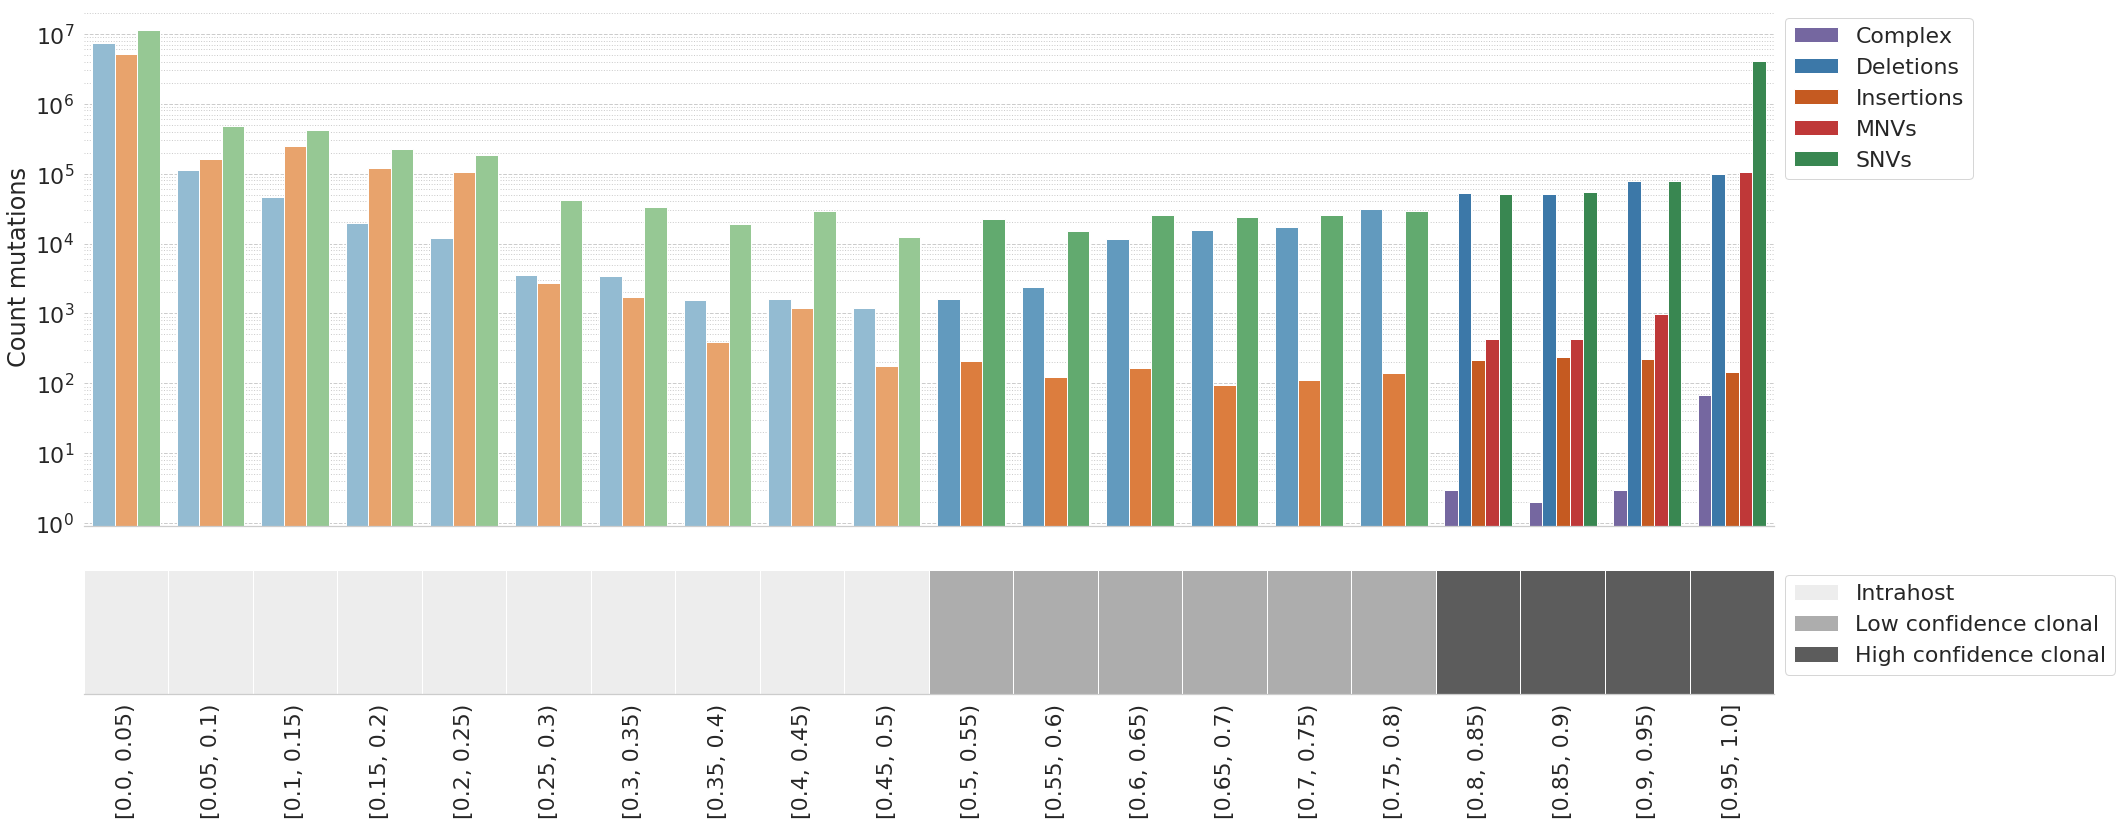

In [17]:
fig = plot_vaf_by_variant_type(variants=variants)
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies.png'), dpi=200)

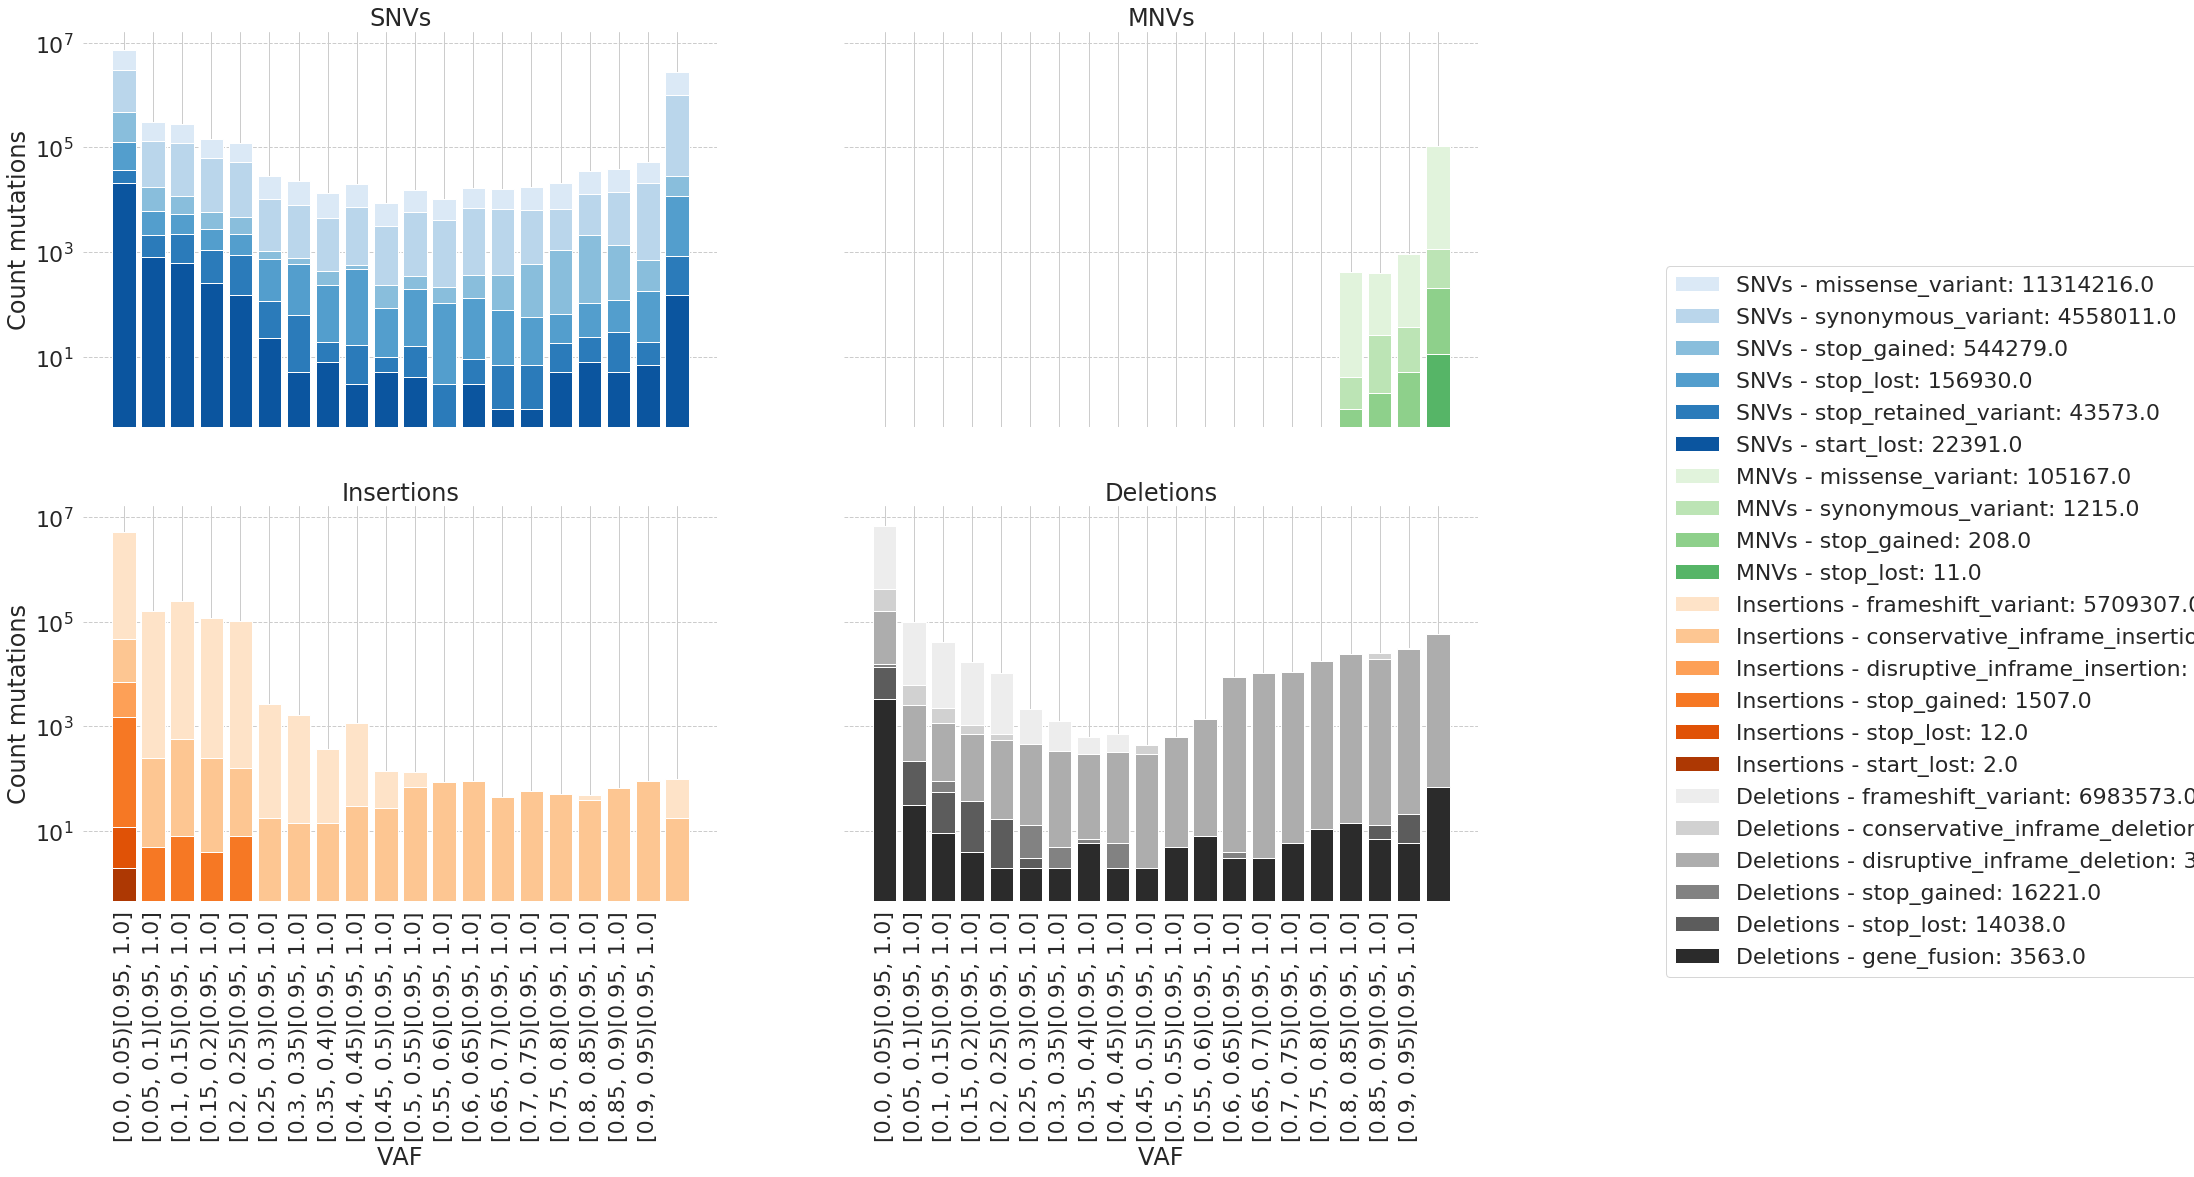

In [18]:
fig = plot_vaf_with_effect(variants=pd.concat([clonal_variants, subclonal_variants, low_frequency_variants]), title="All variants")
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies_with_effect.svg'), dpi=200)

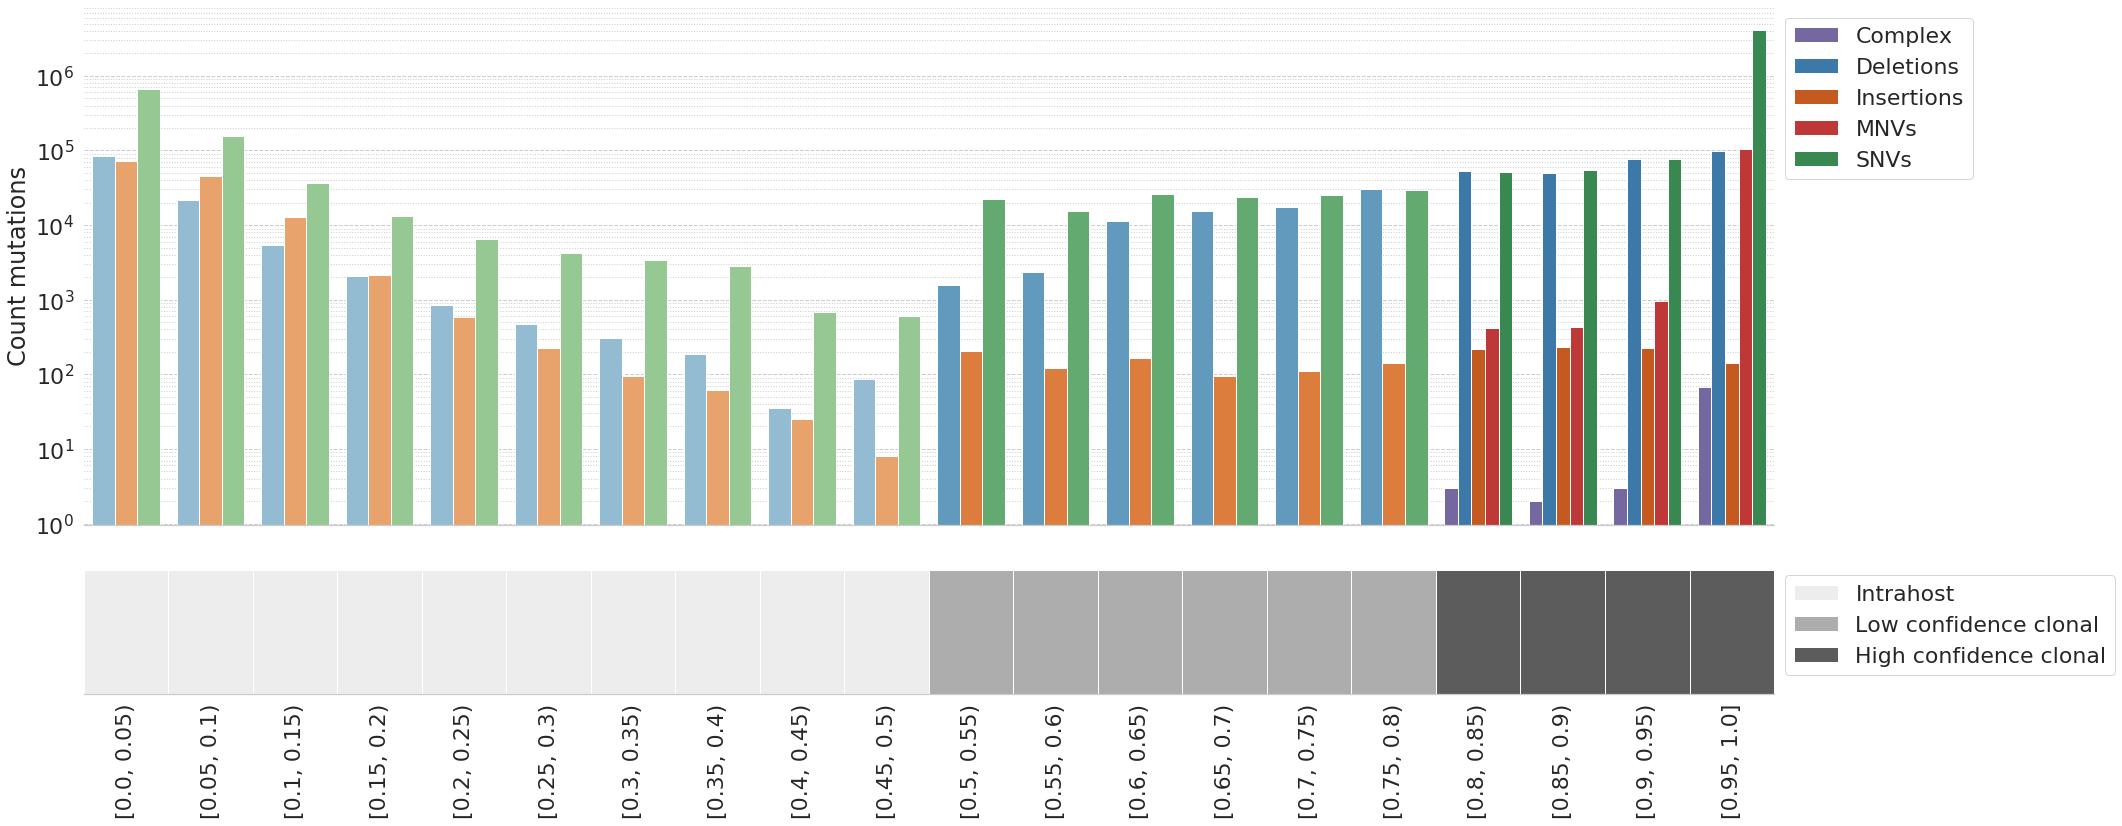

In [19]:
fig = plot_vaf_by_variant_type(pd.concat([clonal_variants, subclonal_variants[subclonal_variants.vaf >= 0.5], high_quality_intrahost_variants]))
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies_after_filtering.svg'), dpi=200)

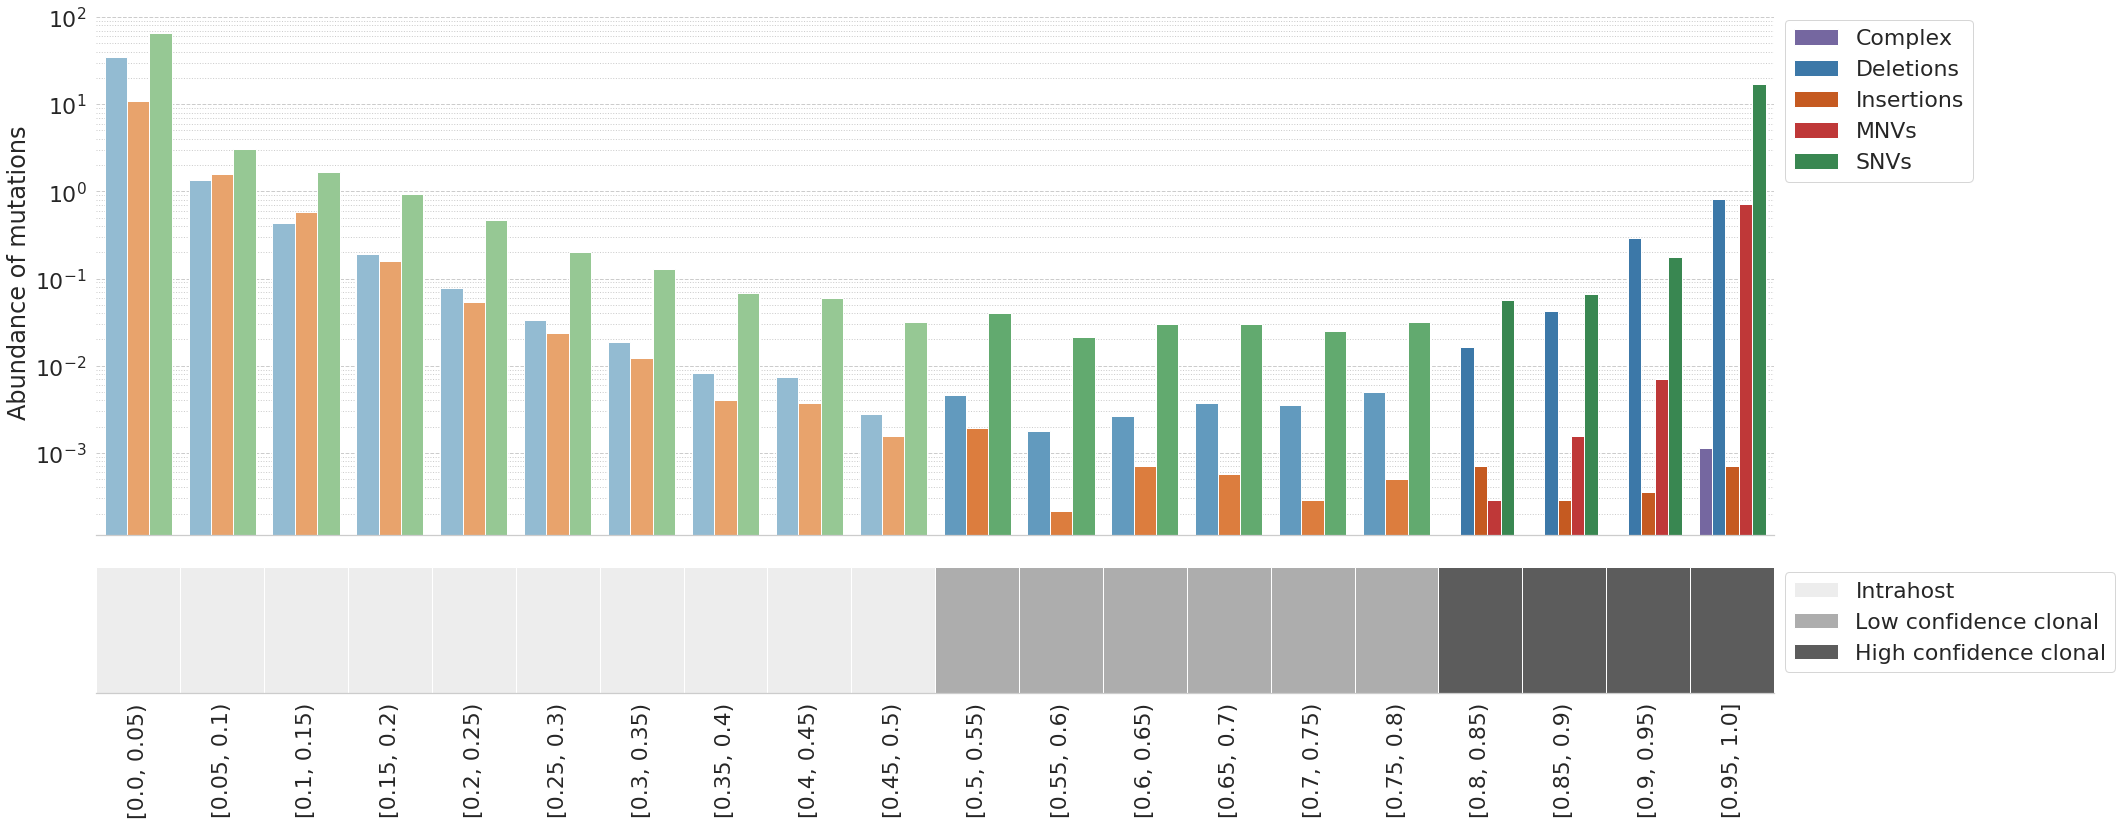

In [20]:
fig = plot_vaf_by_variant_type(
    pd.concat([
        clonal_variants[clonal_variants.library_strategy == "Targeted-Capture"],
        subclonal_variants[subclonal_variants.library_strategy == "Targeted-Capture"],
        low_frequency_variants[low_frequency_variants.library_strategy == "Targeted-Capture"]]),
    normalization_factor=sample_ena[sample_ena.library_strategy == "Targeted-Capture"].run_accession.unique().shape[0]
)
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies_library_strategy_targeted.svg'), dpi=200)

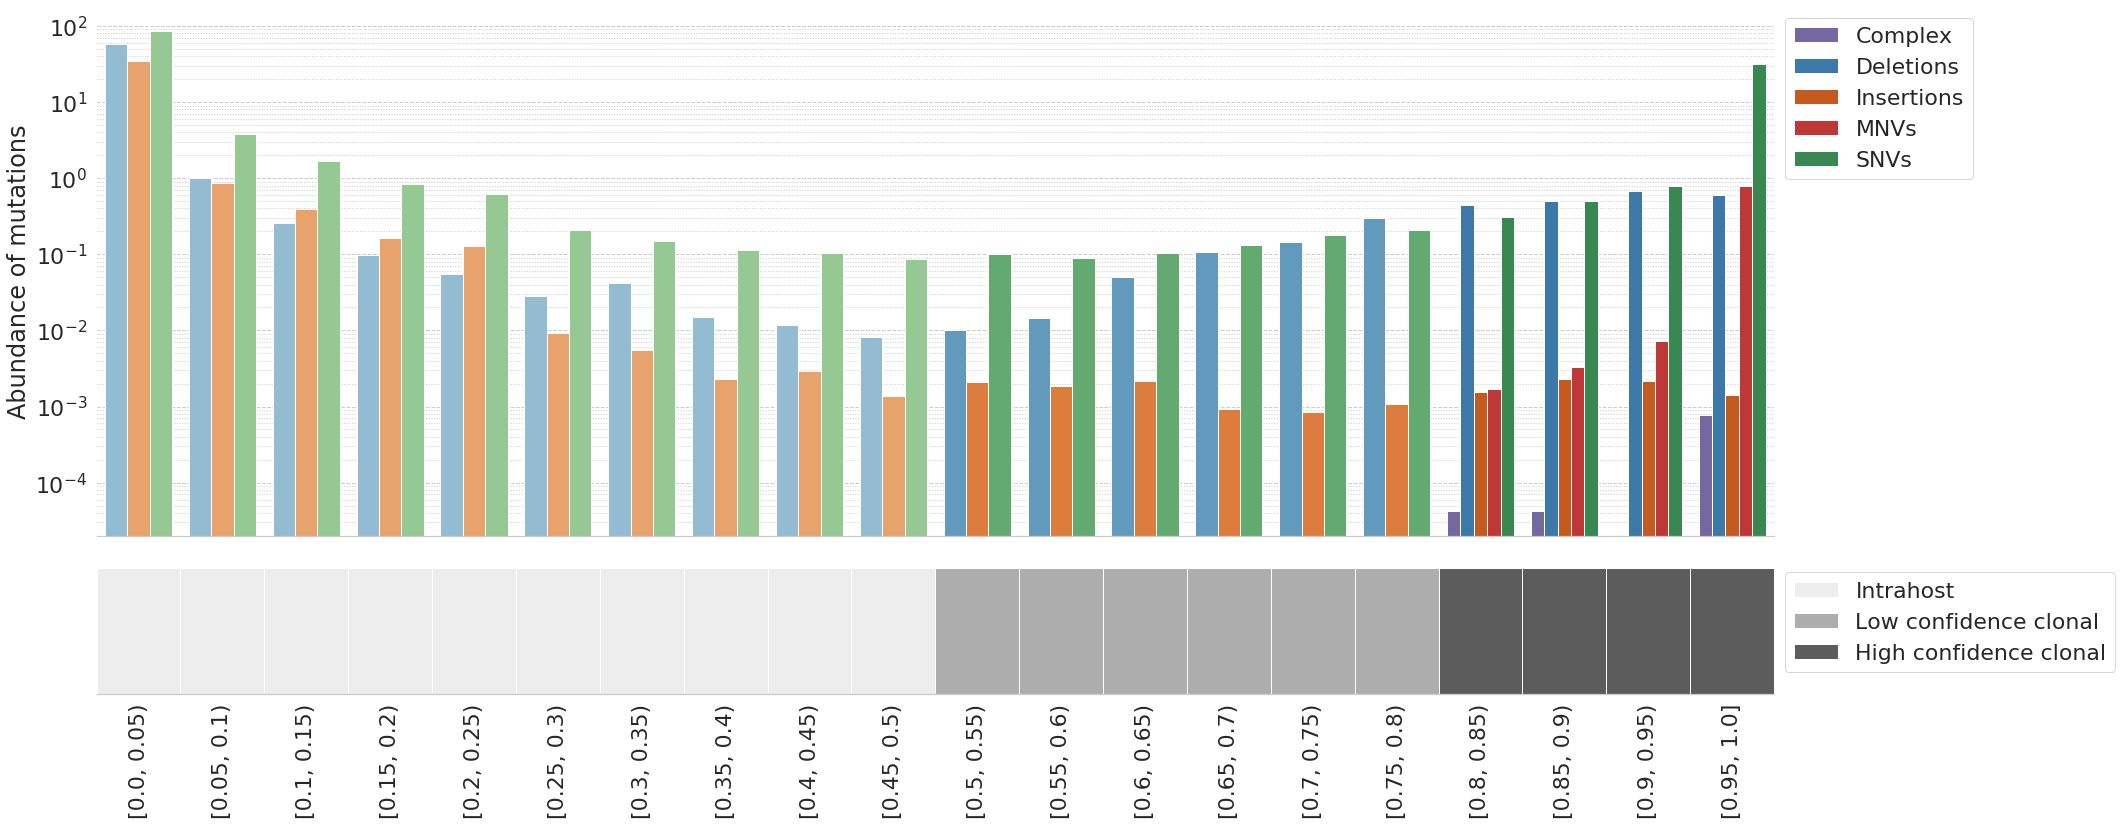

In [21]:
fig = plot_vaf_by_variant_type(
    pd.concat([
        clonal_variants[clonal_variants.library_strategy == "WGS"], 
        subclonal_variants[subclonal_variants.library_strategy == "WGS"],
        low_frequency_variants[low_frequency_variants.library_strategy == "WGS"]]),
    normalization_factor=sample_ena[sample_ena.library_strategy == "WGS"].run_accession.unique().shape[0]
)
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies_library_strategy_wgs.svg'), dpi=200)

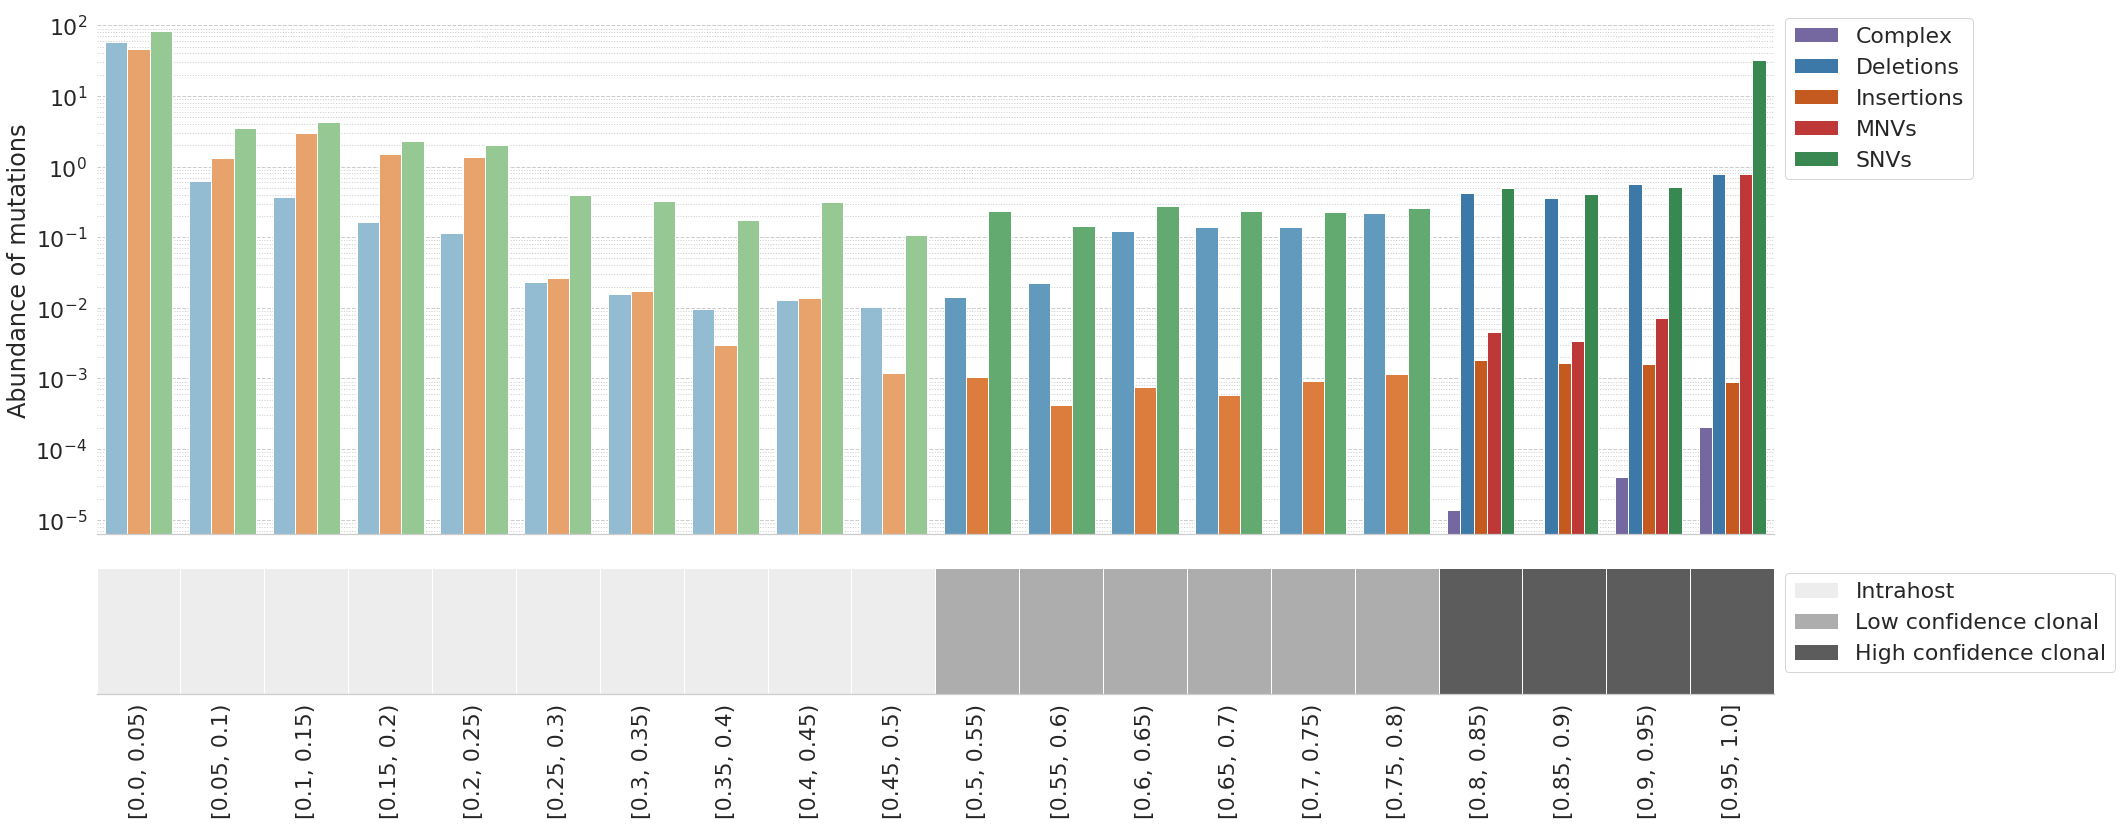

In [22]:
fig = plot_vaf_by_variant_type(
    pd.concat([
        clonal_variants[clonal_variants.library_strategy == "WGA"],
        subclonal_variants[subclonal_variants.library_strategy == "WGA"],
        low_frequency_variants[low_frequency_variants.library_strategy == "WGA"]]),
    normalization_factor=sample_ena[sample_ena.library_strategy == "WGA"].run_accession.unique().shape[0]
)
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies_library_strategy_wga.svg'), dpi=200)

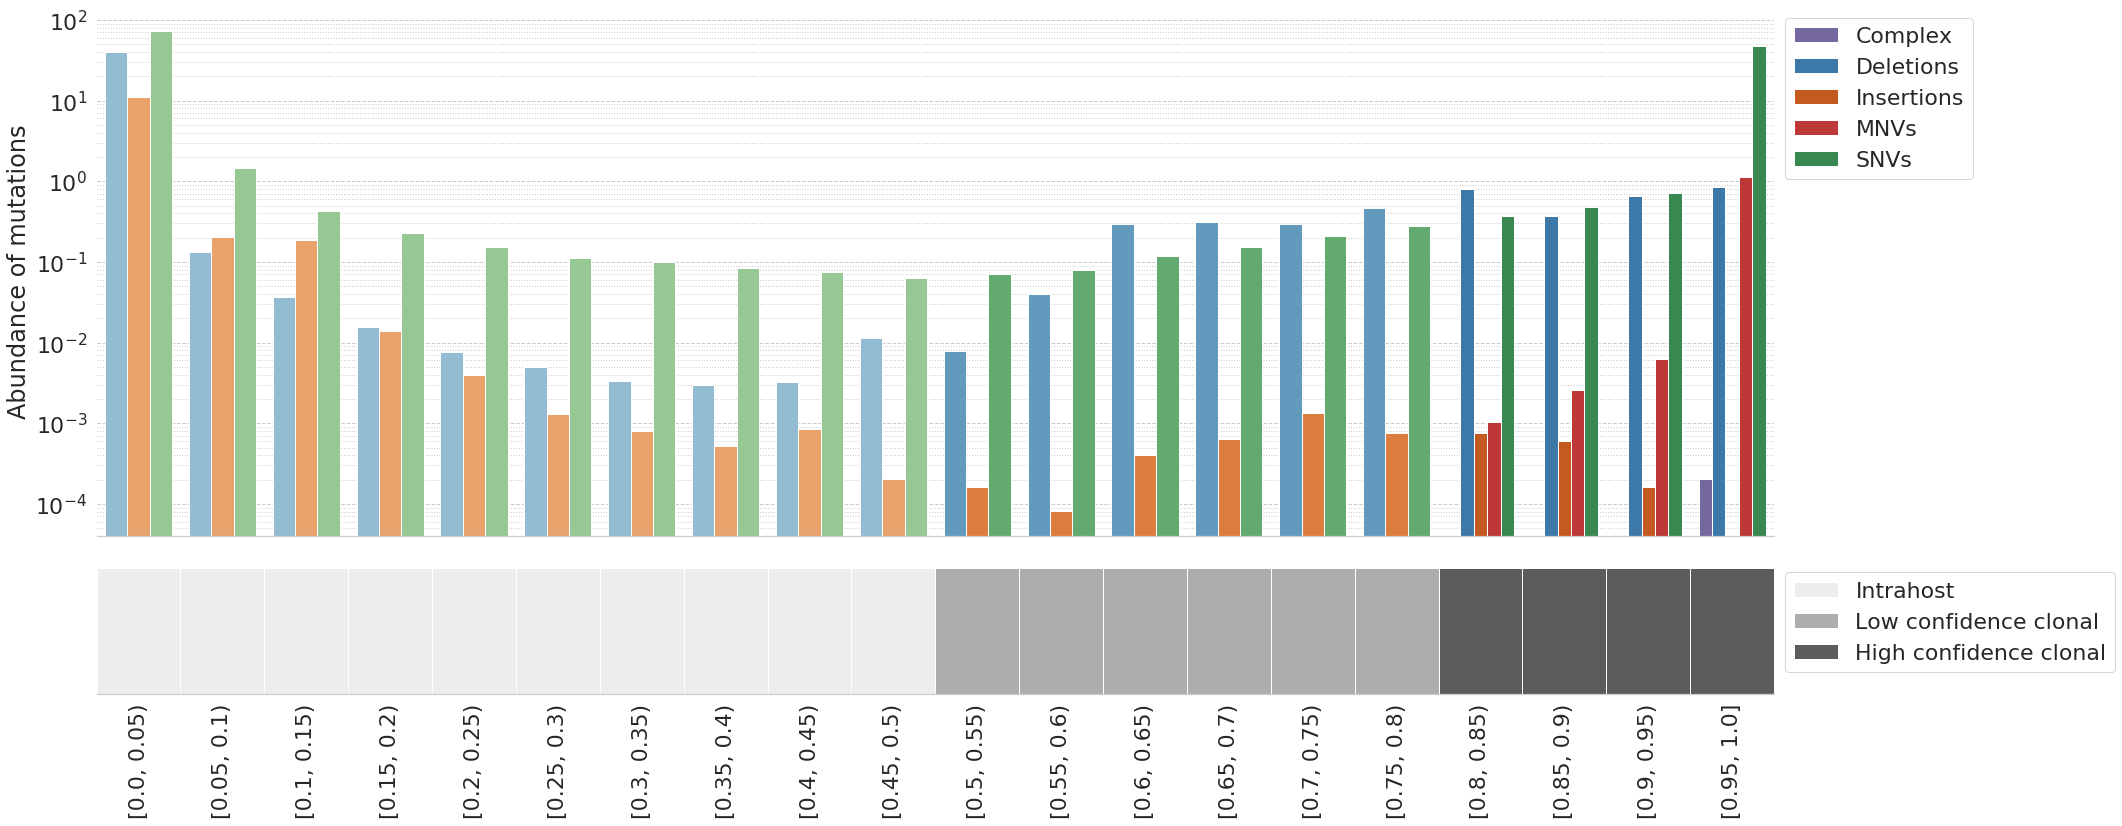

In [23]:
fig = plot_vaf_by_variant_type(
    pd.concat([
        clonal_variants[clonal_variants.artic == "ARTIC"],
        subclonal_variants[subclonal_variants.artic == "ARTIC"],
        low_frequency_variants[low_frequency_variants.artic == "ARTIC"]]),
    normalization_factor=sample_ena[sample_ena.artic == "ARTIC"].run_accession.unique().shape[0]
)
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies_artic.svg'), dpi=200)

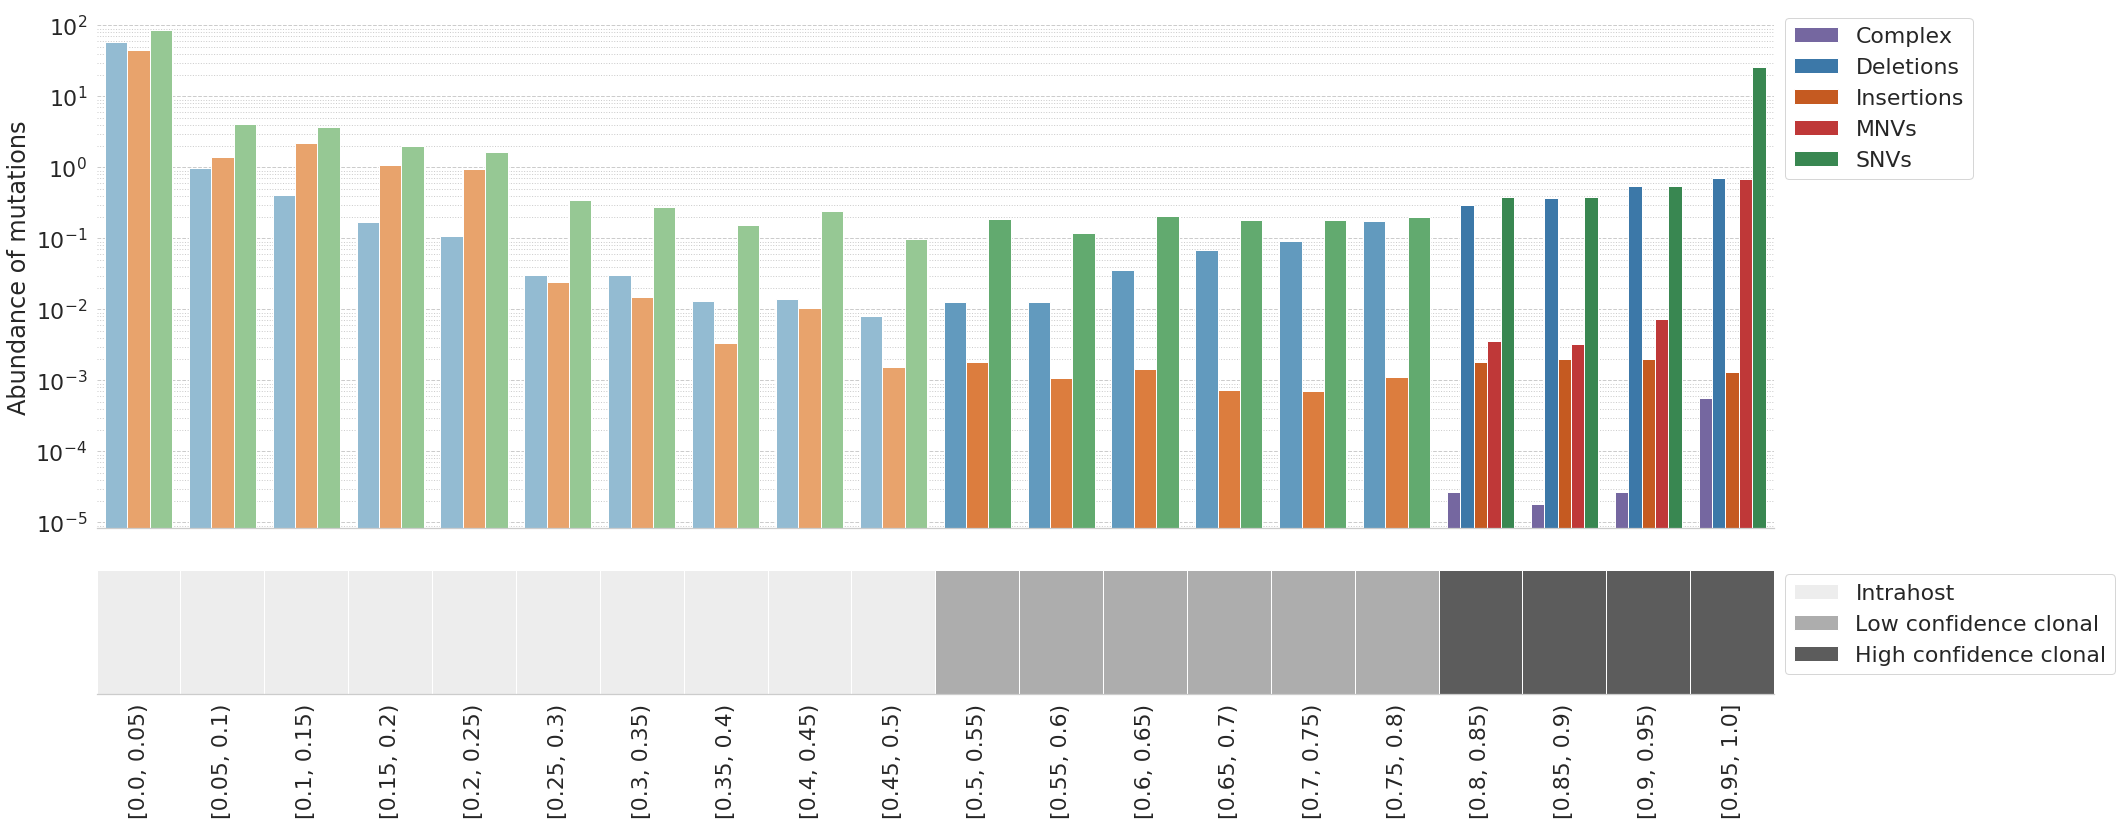

In [24]:
fig = plot_vaf_by_variant_type(
    pd.concat([
        clonal_variants[clonal_variants.artic == "Unknown"],
        subclonal_variants[subclonal_variants.artic == "Unknown"],
        low_frequency_variants[low_frequency_variants.artic == "Unknown"]]),
    normalization_factor=sample_ena[sample_ena.artic == "Unknown"].run_accession.unique().shape[0]
)
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies_artic.svg'), dpi=200)

In [25]:
sample_ena.run_accession.unique().shape[0]

135347

### Filter out samples

We may want to filter out some samples with extreme counts of variants. A similar approach has already been done using the count of clonal SNVs and indels separately. All samples with a count greater than the median plus three times the inter-quartile range were excluded.

#### Number of subclonal SNVs per sample

[None, Text(0.5, 0, '# SNVs')]

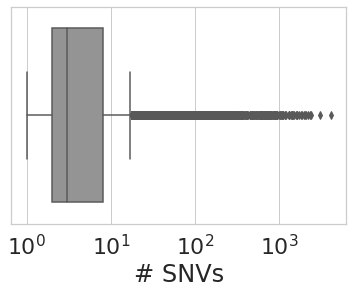

In [26]:
count_subclonal_snvs_per_samples = subclonal_snvs[["sample", "variant_id"]].groupby("sample").count().reset_index().rename(columns={'variant_id': 'count_snvs'})
splot = sns.boxplot(count_subclonal_snvs_per_samples.count_snvs, color=grey)
splot.set(xscale="log", xlabel="# SNVs")

In [27]:
print("Median number of SNVs per sample {}".format(count_subclonal_snvs_per_samples.count_snvs.quantile(0.5)))
iqr_count_subclonal_snvs = count_subclonal_snvs_per_samples.count_snvs.quantile(0.75) - count_subclonal_snvs_per_samples.count_snvs.quantile(0.25)
print("IQR number of SNVs per sample {}".format(iqr_count_subclonal_snvs))

Median number of SNVs per sample 3.0
IQR number of SNVs per sample 6.0


In [28]:
count_snvs_threshold = count_subclonal_snvs_per_samples.count_snvs.quantile(0.5) + (3 * iqr_count_subclonal_snvs)
excluded_samples_count_snvs = count_subclonal_snvs_per_samples[count_subclonal_snvs_per_samples.count_snvs > count_snvs_threshold]["sample"].unique()
print("Filtering all samples with a count of SNVs greater than {}, {} samples and {} SNVs are filtered out".format(
    count_snvs_threshold,
    excluded_samples_count_snvs.shape[0],
    count_subclonal_snvs_per_samples[count_subclonal_snvs_per_samples.count_snvs > count_snvs_threshold].count_snvs.sum()))

Filtering all samples with a count of SNVs greater than 21.0, 13836 samples and 1140466 SNVs are filtered out


#### Number of subclonal indels per samples

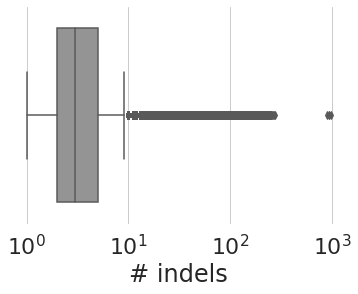

In [29]:
count_subclonal_indels_per_samples = subclonal_indels[["sample", "variant_id"]].groupby("sample").count().reset_index().rename(columns={'variant_id': 'count_indels'})
splot = sns.boxplot(count_subclonal_indels_per_samples.count_indels, color=grey)
splot.set(xscale="log", xlabel="# indels")
sns.despine(bottom=True, left=True)

In [30]:
print("Median number of indels per sample {}".format(count_subclonal_indels_per_samples.count_indels.quantile(0.5)))
iqr_count_subclonal_indels = count_subclonal_indels_per_samples.count_indels.quantile(0.75) - count_subclonal_indels_per_samples.count_indels.quantile(0.25)
print("IQR number of indels per sample {}".format(iqr_count_subclonal_indels))

Median number of indels per sample 3.0
IQR number of indels per sample 3.0


In [31]:
count_indels_threshold = count_subclonal_indels_per_samples.count_indels.quantile(0.5) + (3 * iqr_count_subclonal_indels)
excluded_samples_count_indels = count_subclonal_indels_per_samples[count_subclonal_indels_per_samples.count_indels > count_indels_threshold]["sample"].unique()
print("Filtering all samples with a count of indels greater than {}, {} samples and {} indels are filtered out".format(
    count_indels_threshold,
    excluded_samples_count_indels.shape[0],
    count_subclonal_indels_per_samples[count_subclonal_indels_per_samples.count_indels > count_indels_threshold].count_indels.sum()))

Filtering all samples with a count of indels greater than 12.0, 11122 samples and 652019 indels are filtered out


In [32]:
len(set(excluded_samples_count_indels).intersection(excluded_samples_count_snvs))

9156

In [33]:
excluded_samples_by_count_variants = set(excluded_samples_count_indels).union(excluded_samples_count_snvs)
print("Filtered {} indels after excluding all samples".format(
    count_subclonal_indels_per_samples[count_subclonal_indels_per_samples["sample"].isin(excluded_samples_by_count_variants)].count_indels.sum()))
print("Filtered {} SNVs after excluding all samples".format(
    count_subclonal_snvs_per_samples[count_subclonal_snvs_per_samples["sample"].isin(excluded_samples_by_count_variants)].count_snvs.sum()))

Filtered 676114 indels after excluding all samples
Filtered 1163316 SNVs after excluding all samples


### Sample distribution and number of subclonal SNVs by technology

In [34]:
colors_library_strategy = {
    "RNA-Seq": blue,
    "Targeted-Capture": orange,
    "WGS": green,
    "WGA": grey
}

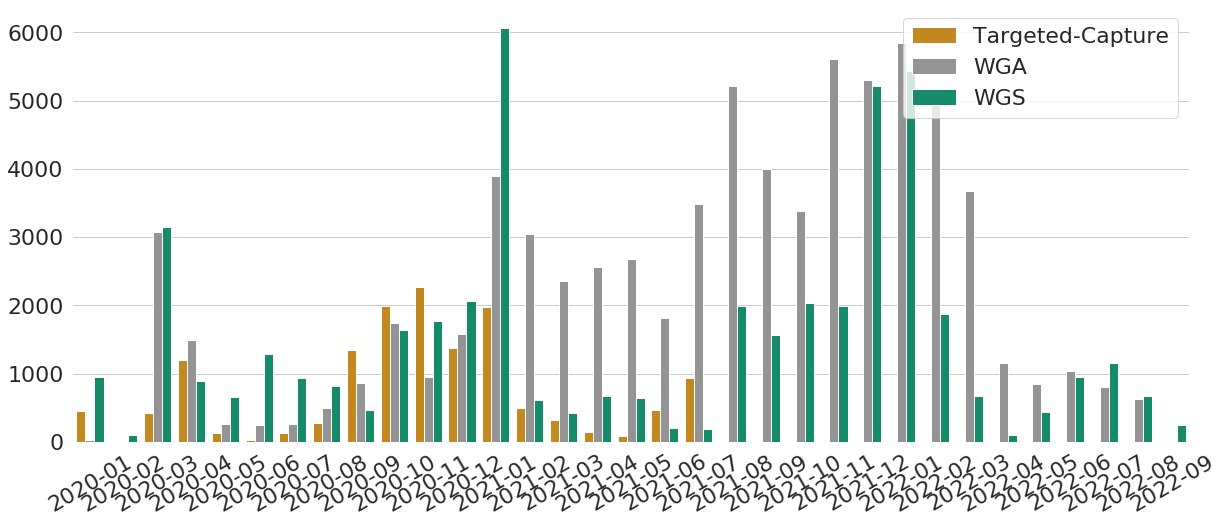

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
splot = sns.barplot(data=sample_ena[["library_strategy", "run_accession", "month"]].groupby(["month", "library_strategy"]).count().reset_index(), 
            y="run_accession", x="month", hue='library_strategy', palette=colors_library_strategy)
plt.xticks(rotation=30)
ax.legend(loc='upper right')
splot.set(xlabel=None, ylabel=None)
sns.despine(bottom=True, left=True)
fig.savefig(os.path.join(figure_output_folder, "figure_02_distribution_samples_through_time_by_technology.svg"), dpi=200)

In [36]:
def plot_subclonal_per_sample(data, title=None, legend=False, sample_variable='library_strategy'):
    count_per_sample_and_library_strategy = data[["sample", "variant_id", sample_variable, "variant_type"]] \
        .groupby(["sample", sample_variable, "variant_type"])\
        .count()\
        .reset_index()\
        .rename(columns={'variant_id': 'count'})
    
    count_per_sample_and_library_strategy.sort_values([sample_variable, "variant_type", 'sample'], inplace=True)
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    splot = sns.boxplot(
        data=count_per_sample_and_library_strategy, 
        x="count", y=sample_variable, hue="variant_type",
        palette=[
            sns.color_palette("Blues")[2],
            sns.color_palette("Oranges")[2],
            sns.color_palette("Greens")[2]])
    splot.set(xscale="log", xlabel=None, ylabel=None, title=title) 
    ax.grid(axis='x', b=True, which='major', linestyle='--')
    ax.grid(axis='x', b=False, which='minor', linestyle=':')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels)
    plt.tight_layout()
    sns.despine(bottom=True, left=True)
    
    if not legend:
        ax.get_legend().remove()
    return splot.figure

In [37]:
data = subclonal_snvs[["sample", "variant_id", "library_strategy"]] \
    .groupby(["sample", "library_strategy"]).count().reset_index().rename(columns={'variant_id': 'count_snvs'})
np.median(data[data.library_strategy == "Targeted-Capture"].count_snvs)

4.0

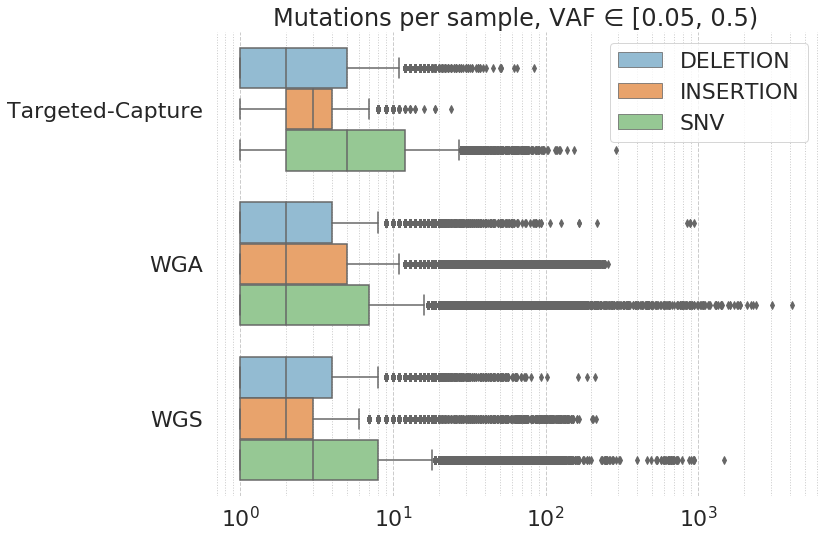

In [38]:
fig = plot_subclonal_per_sample(data=subclonal_variants[subclonal_variants.vaf < 0.5], title='Mutations per sample, VAF ∈ [0.05, 0.5)', legend=True)
fig.savefig(os.path.join(figure_output_folder, "figure_03_count_per_sample_by_technology_vaf005.svg"), dpi=200)

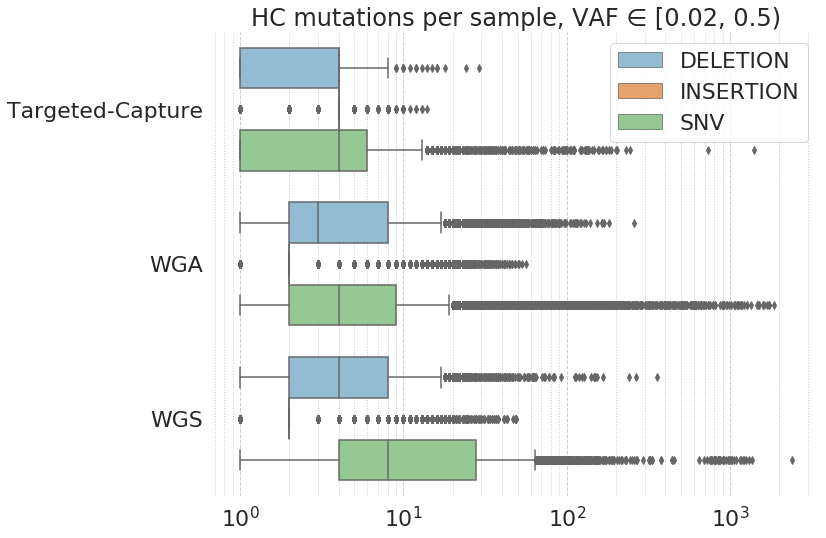

In [39]:
fig = plot_subclonal_per_sample(data=pd.merge(high_quality_intrahost_variants, sample_ena, left_on='sample', right_on='run_accession'), title='HC mutations per sample, VAF ∈ [0.02, 0.5)', legend=True)
fig.savefig(os.path.join(figure_output_folder, "figure_03_count_per_sample_by_technology_hc_intrahost.png"), dpi=200)

In [40]:
non_clonal_variants = pd.concat([subclonal_variants, low_frequency_variants])

In [41]:
non_clonal_variants.columns

Index(['sample', 'variant_id', 'chromosome', 'position', 'reference',
       'alternate', 'quality', 'filter', 'dp', 'ac', 'dp4_ref_forward',
       'dp4_ref_reverse', 'dp4_alt_forward', 'dp4_alt_reverse', 'vaf',
       'strand_bias', 'annotation', 'annotation_impact', 'biotype',
       'annotation_highest_impact', 'gene_name', 'hgvs_c', 'hgvs_p', 'date',
       'variant_type', 'length', 'reference_amino_acid',
       'alternate_amino_acid', 'position_amino_acid', 'cons_hmm_sars_cov_2',
       'cons_hmm_sarbecovirus', 'cons_hmm_vertebrate_cov', 'pfam_name',
       'pfam_description', 'run_accession', 'library_strategy', 'artic'],
      dtype='object')

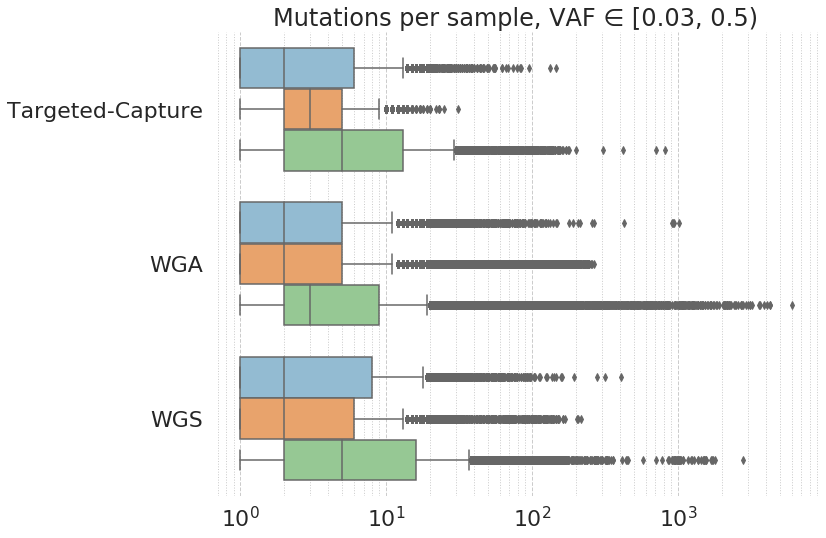

In [42]:
fig = plot_subclonal_per_sample(data=non_clonal_variants[(non_clonal_variants.vaf >= 0.03) & (non_clonal_variants.vaf < 0.5)], title='Mutations per sample, VAF ∈ [0.03, 0.5)')
fig.savefig(os.path.join(figure_output_folder, "figure_03_count_per_sample_by_technology_vaf003.svg"), dpi=200)

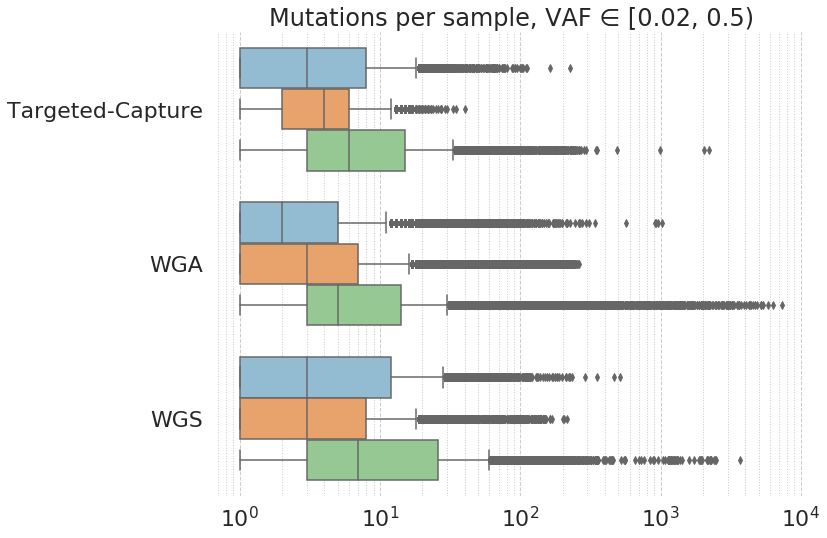

In [43]:
fig = plot_subclonal_per_sample(data=non_clonal_variants[(non_clonal_variants.vaf >= 0.02) & (non_clonal_variants.vaf < 0.5)], title='Mutations per sample, VAF ∈ [0.02, 0.5)')
fig.savefig(os.path.join(figure_output_folder, "figure_03_count_per_sample_by_technology_vaf002.svg"), dpi=200)

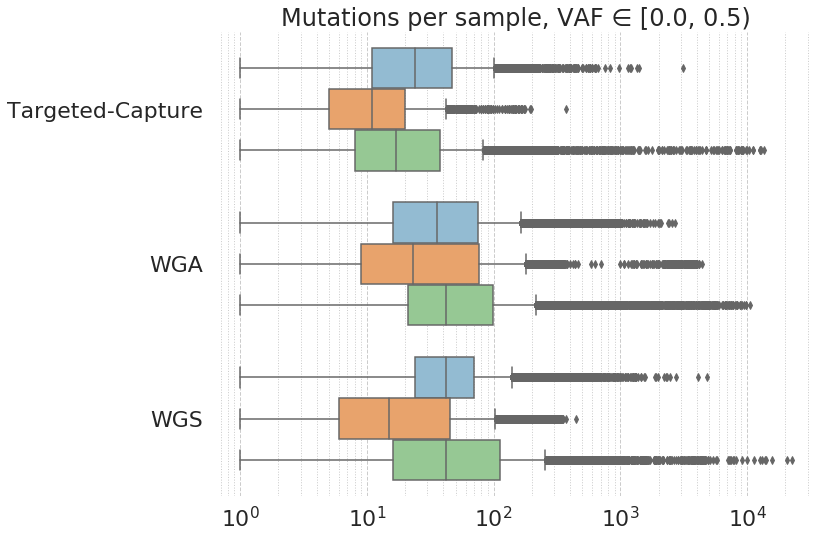

In [44]:
fig = plot_subclonal_per_sample(data=non_clonal_variants[(non_clonal_variants.vaf < 0.5)], title='Mutations per sample, VAF ∈ [0.0, 0.5)')
fig.savefig(os.path.join(figure_output_folder, "figure_03_count_per_sample_by_technology_vaf00.png"), dpi=200)

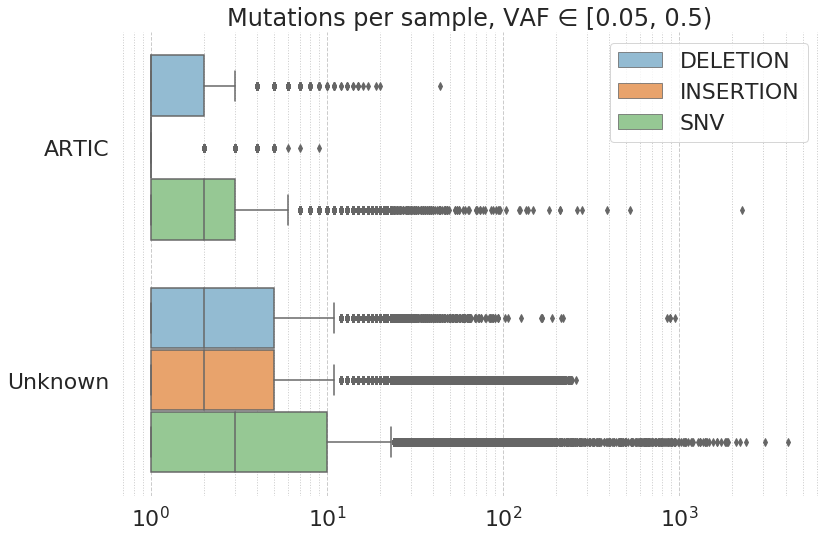

In [45]:
fig = plot_subclonal_per_sample(data=subclonal_variants[subclonal_variants.vaf < 0.5], title='Mutations per sample, VAF ∈ [0.05, 0.5)', legend=True, sample_variable='artic')
fig.savefig(os.path.join(figure_output_folder, "figure_03_count_per_sample_by_artic_vaf005.svg"), dpi=200)

In [46]:
sample_ena[['library_strategy', 'artic', 'run_accession']].groupby(['library_strategy', 'artic']).count().reset_index().sort_values('run_accession', ascending=False)

library_strategy    artic  run_accession
2               WGA  Unknown          48595
3               WGS  Unknown          47869
1               WGA    ARTIC          24827
0  Targeted-Capture  Unknown          14056

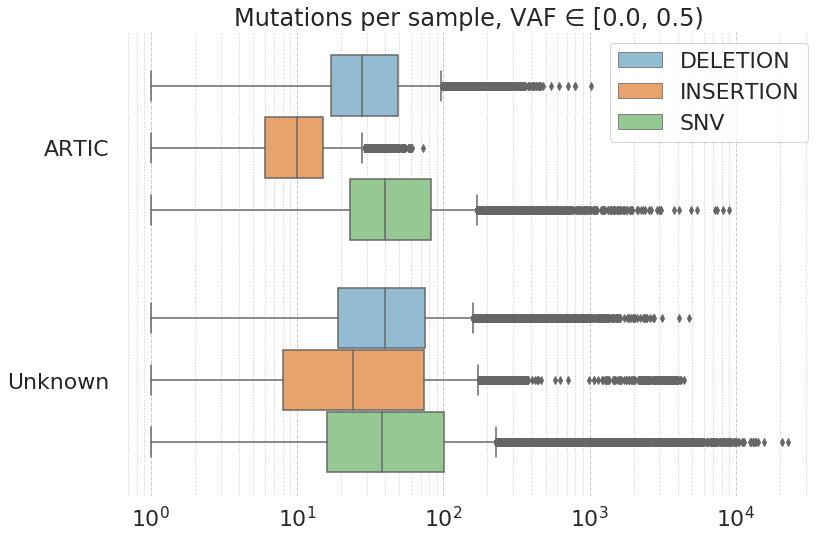

In [47]:
fig = plot_subclonal_per_sample(data=non_clonal_variants[non_clonal_variants.vaf < 0.5], title='Mutations per sample, VAF ∈ [0.0, 0.5)', legend=True, sample_variable='artic')
fig.savefig(os.path.join(figure_output_folder, "figure_03_count_per_sample_by_artic_vaf00.svg"), dpi=200)

In [48]:
'ARTIC' in "Nextera Flex"

False

In [49]:
sample_ena[['run_accession', 'library_name']].groupby('library_name').count().reset_index().sort_values('run_accession', ascending=False).head(50)

library_name  run_accession
10107                 Illumina COVIDSeq (ARTIC v4)          11321
10106                 Illumina COVIDSeq (ARTIC v3)          10821
15068                                 Nextera Flex          10447
15069                                   Nextera XT           6709
8124               CleanPlex SARS-CoV-2 FLEX Panel           4770
8128          EasySeq™ RC-PCR SARS CoV-2,(NimaGen)           3688
15070                        Nextera XT (ARTIC V4)           1629
10105                            Illumina COVIDSeq           1130
1312           ARCTIC v4-1 / Illumina DNA Prep (M)            705
8123                          CleanPlex SARS-CoV-2            578
15071                      Nextera XT (ARTIC V4.1)            351
8125                    CleanPlex SARS-CoV-2 Panel            128
13857  Molecular Loop Viral RNA target capture kit             76
25228                TruSeq Stranded Total RNA kit             25
30987                                  unspecified              4
8272                                    FD15540740              3
8266                                    FD15540730              3
8234                                    FD15540588              3
8240                                    FD15540690              3
8228                                    FD15518313              2
1140                                            71              2
8386                                    FD17059311              2
1138                                             7              2
8384                                    FD17059309              2
8383                                    FD17059308              2
20272                           TX-HHD-_4832843_01              2
8382                                    FD17059307              2
8381                                    FD17059306              2
20275                           TX-HHD-_4832848_01              2
85                                              10              2
8380                                    FD15692498              2
8131                                    FD15481381              2
8229                                    FD15519042              2
20280                           TX-HHD-_4832854_01              2
20281                           TX-HHD-_4832855_01              2
8129                                    FD15381415              2
20286                           TX-HHD-_4832866_01              2
101                                             11              2
8233                                    FD15539334              2
436                                              2              2
20290                           TX-HHD-_4832893_01              2
1233                    @M05492:75:000000000-CW8RH              2
20296                           TX-HHD-_4832931_01              2
437                                             20              2
8401                                    FD17059327              2
8387                                    FD17059312              2
8388                                    FD17059313              2
8405                                    FD17059331              2
8406                                    FD17059332              2
8407                                    FD17059333              2

In [50]:
# excludes samples effectively
excluded_samples = sample_ena[(sample_ena.run_accession.isin(excluded_samples_by_count_variants)) | (sample_ena.library_strategy == "RNA-Seq")].run_accession.unique()
sample_ena_filtered_samples = sample_ena[~sample_ena.run_accession.isin(excluded_samples)]
subclonal_snvs_filtered_samples = subclonal_snvs[~subclonal_snvs["sample"].isin(excluded_samples)]
subclonal_indels_filtered_samples = subclonal_indels[~subclonal_indels["sample"].isin(excluded_samples)]
print("Total excluded samples: {}".format(excluded_samples.shape[0]))

Total excluded samples: 15802


### Filter out low quality SNVs

* Filter out SNVs with too high coverage at the position. The distribution of DP has a long tail on the higher end, thus we filter out anything above the 99th percentile.
* The quality reported by LoFreq is not a Phred score. We filter out variant calls with quality less than or equal to 50.
* We filter variant calls with a strand bias score (ie: the lower the better) greater than 100.
* The number of supporting reads is calculated using the VAF and the DP. All variant calls with less than 10 supporting reads are filtered out.
* Finally, we filter all variant calls with a VAF lower than 0.01

The above rules allows us to filter down to **18.23 % of unique subclonal variants** and to **1.05 % of subclonal variant calls**. This represents **17.46 % of all possible SARS-CoV-2 mutations**.

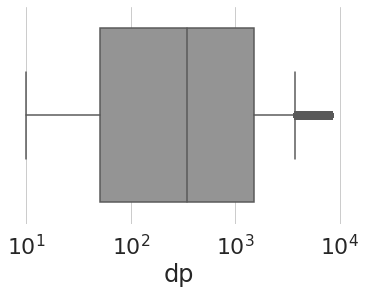

In [51]:
splot = sns.boxplot(subclonal_snvs_filtered_samples.dp, color=grey)
splot.set(xscale="log")
sns.despine(bottom=True, left=True)
splot.figure.savefig(os.path.join(figure_output_folder, "figure_04_dp_boxplot.svg"), dpi=200)

In [52]:
subclonal_snvs_filtered_samples.dp.quantile(0.99)

7641.830000000016

In [53]:
DP_UPPER_THRESHOLD = subclonal_snvs_filtered_samples.dp.quantile(0.99)
print("Filtering all variants on positions with DP > {} removes {} variants".format(DP_UPPER_THRESHOLD, subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.dp > DP_UPPER_THRESHOLD].shape[0]))

Filtering all variants on positions with DP > 7641.830000000016 removes 4260 variants


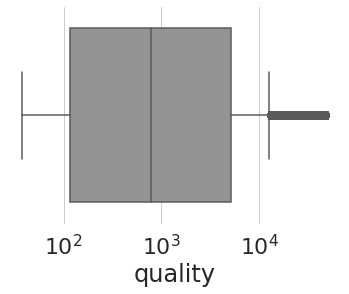

In [54]:
splot = sns.boxplot(subclonal_snvs_filtered_samples.quality, color=grey)
splot.set(xscale="log")
sns.despine(bottom=True, left=True)
splot.figure.savefig(os.path.join(figure_output_folder, "figure_04_quality_boxplot.svg"), dpi=200)

In [55]:
QUALITY_THRESHOLD = 50 #subclonal_snvs.quality.quantile(0.01)
print("Filtering all variants on positions with quality <= {} removes {} variants".format(QUALITY_THRESHOLD, subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.quality <= QUALITY_THRESHOLD].shape[0]))

Filtering all variants on positions with quality <= 50 removes 11174 variants


In [56]:
print("There are {} extreme values for strand bias".format(subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.strand_bias > 1000000].shape[0]))

There are 594 extreme values for strand bias


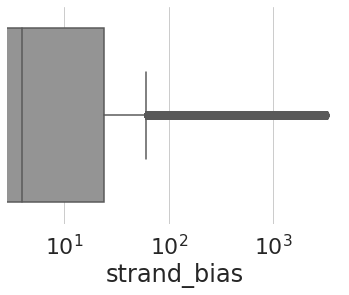

In [57]:
splot = sns.boxplot(subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.strand_bias < 1000000].strand_bias, color=grey)
splot.set(xscale="log")
sns.despine(bottom=True, left=True)
splot.figure.savefig(os.path.join(figure_output_folder, "figure_04_strand_bias_boxplot.svg"), dpi=200)

In [58]:
STRAND_BIAS_THRESHOLD = 100
print("Filtering all variants on positions with strand bias > {} removes {} variants".format(
    STRAND_BIAS_THRESHOLD, subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.strand_bias > STRAND_BIAS_THRESHOLD].shape[0]))

Filtering all variants on positions with strand bias > 100 removes 51478 variants


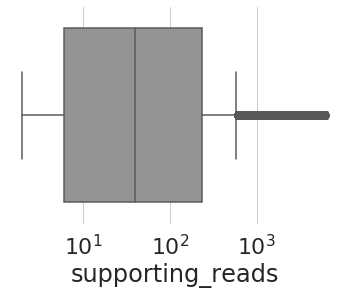

In [59]:
subclonal_snvs_filtered_samples["supporting_reads"] = subclonal_snvs_filtered_samples.vaf * subclonal_snvs_filtered_samples.dp
splot = sns.boxplot(subclonal_snvs_filtered_samples.supporting_reads, color=grey)
splot.set(xscale="log")
sns.despine(bottom=True, left=True)
splot.figure.savefig(os.path.join(figure_output_folder, "figure_04_supporting_reads_boxplot.svg"), dpi=200)

In [60]:
SUPPORTING_READS_THRESHOLD = 3
print("Filtering all variants on positions with supporting_reads < {} removes {} variants".format(
    SUPPORTING_READS_THRESHOLD, subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.supporting_reads < SUPPORTING_READS_THRESHOLD].shape[0]))

Filtering all variants on positions with supporting_reads < 3 removes 48839 variants


In [61]:
MINIMUM_VAF_THRESHOLD = 0.001
print("Filtering all variants with VAF < {} removes {} variants".format(MINIMUM_VAF_THRESHOLD, subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.vaf < MINIMUM_VAF_THRESHOLD].shape[0]))

Filtering all variants with VAF < 0.001 removes 0 variants


In [62]:
def filter_out_variants(data, dp_upper_threshold=DP_UPPER_THRESHOLD, quality_threshold=QUALITY_THRESHOLD, strand_bias_threshold=STRAND_BIAS_THRESHOLD,
                       supporting_reads_threshold=SUPPORTING_READS_THRESHOLD, minimum_vaf_threshold=MINIMUM_VAF_THRESHOLD):
    data_filtered_variants = data[
        (data.dp <= dp_upper_threshold) &
        (data.quality > quality_threshold) &
        (data.strand_bias <= strand_bias_threshold) &
        (data.supporting_reads >= supporting_reads_threshold) &
        (data.vaf >= minimum_vaf_threshold)
    ]
    print("Filtered subclonal SNV calls {}".format(data.shape[0] - data_filtered_variants.shape[0]))
    print("Subclonal SNV calls after filtering {}".format(data_filtered_variants.shape[0]))
    count_unique_after_filtering = data_filtered_variants.variant_id.unique().shape[0]
    print("Subclonal unique SNVs after filtering {} ({} % of all possible mutations)".format(count_unique_after_filtering, round(count_unique_after_filtering / (SARS_COV_2_GENOME_LENGTH * 3) * 100, 3)))
    return data_filtered_variants

In [63]:
subclonal_snvs_filtered_vaf0_sr0 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.0, supporting_reads_threshold=0)

Filtered subclonal SNV calls 65750
Subclonal SNV calls after filtering 360168
Subclonal unique SNVs after filtering 53053 (59.139 % of all possible mutations)


In [64]:
subclonal_snvs_filtered_vaf001 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.01)

Filtered subclonal SNV calls 103619
Subclonal SNV calls after filtering 322299
Subclonal unique SNVs after filtering 46388 (51.709 % of all possible mutations)


In [65]:
subclonal_snvs_filtered_vaf002 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.02)

Filtered subclonal SNV calls 103619
Subclonal SNV calls after filtering 322299
Subclonal unique SNVs after filtering 46388 (51.709 % of all possible mutations)


In [66]:
subclonal_snvs_filtered_vaf003 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.03)

Filtered subclonal SNV calls 103619
Subclonal SNV calls after filtering 322299
Subclonal unique SNVs after filtering 46388 (51.709 % of all possible mutations)


In [67]:
subclonal_snvs_filtered_vaf005 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.05)

Filtered subclonal SNV calls 103619
Subclonal SNV calls after filtering 322299
Subclonal unique SNVs after filtering 46388 (51.709 % of all possible mutations)


In [68]:
subclonal_snvs_filtered_vaf01 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.1)

Filtered subclonal SNV calls 260274
Subclonal SNV calls after filtering 165644
Subclonal unique SNVs after filtering 30085 (33.536 % of all possible mutations)


In [69]:
subclonal_snvs_filtered_vaf02 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.2)

Filtered subclonal SNV calls 322845
Subclonal SNV calls after filtering 103073
Subclonal unique SNVs after filtering 19112 (21.304 % of all possible mutations)


In [70]:
subclonal_snvs_filtered_vaf03 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.3)

Filtered subclonal SNV calls 348697
Subclonal SNV calls after filtering 77221
Subclonal unique SNVs after filtering 13772 (15.352 % of all possible mutations)


In [71]:
subclonal_snvs_filtered_samples["sample"].unique().shape

(100152,)

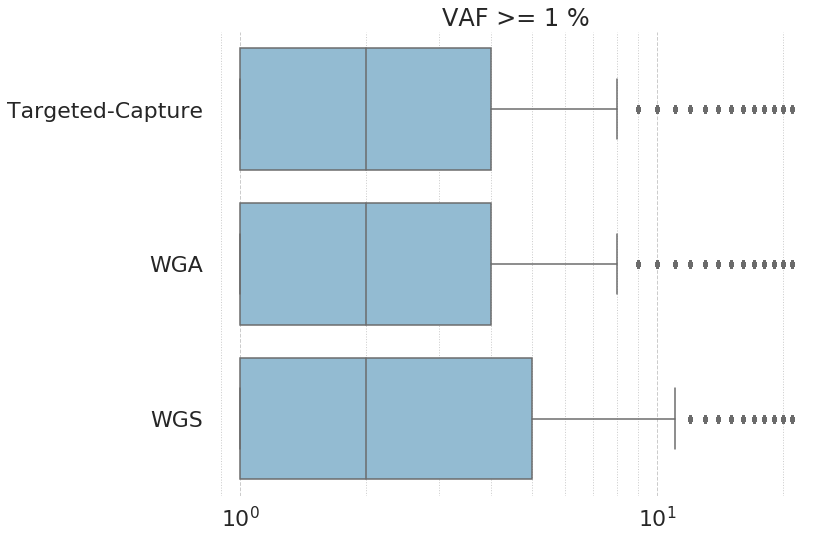

In [73]:
fig = plot_subclonal_per_sample(data=subclonal_snvs_filtered_vaf001, title="VAF >= 1 %")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_1.svg"), dpi=200)

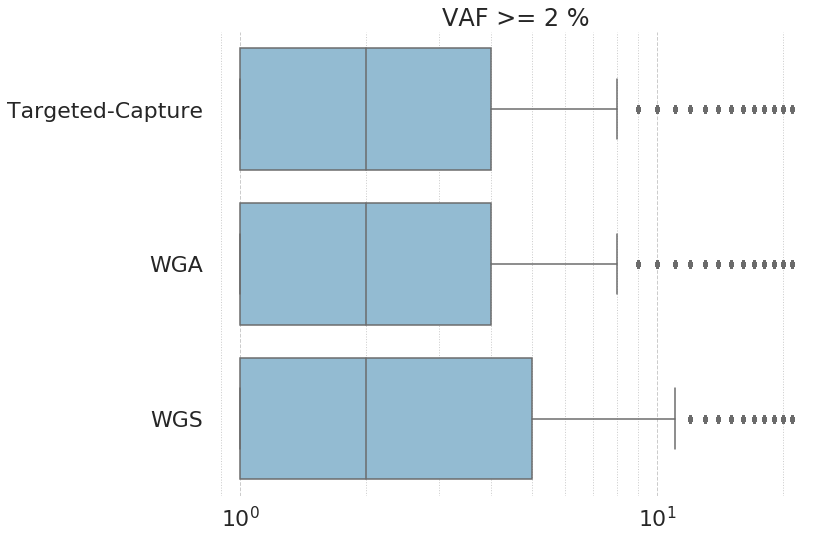

In [74]:
fig = plot_subclonal_per_sample(data=subclonal_snvs_filtered_vaf002, title="VAF >= 2 %")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_2.svg"), dpi=200)

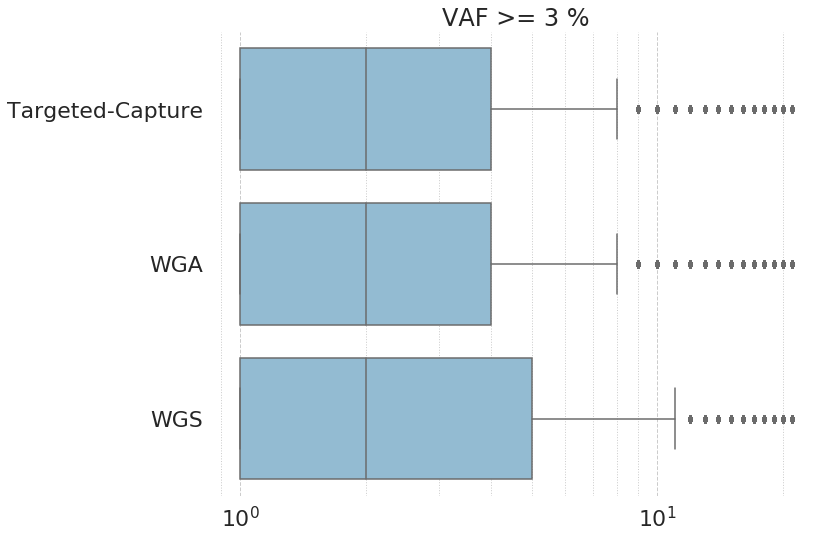

In [75]:
fig = plot_subclonal_per_sample(data=subclonal_snvs_filtered_vaf003, title="VAF >= 3 %")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_3.svg"), dpi=200)

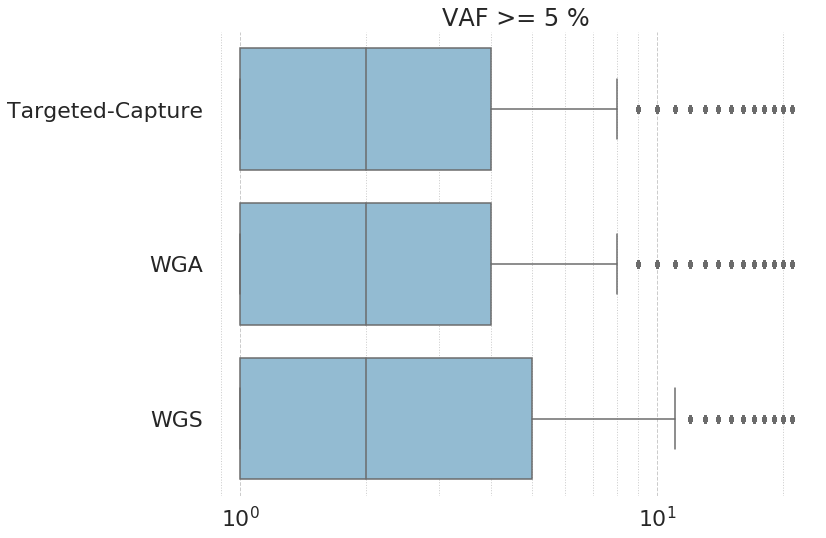

In [76]:
fig = plot_subclonal_per_sample(data=subclonal_snvs_filtered_vaf005, title="VAF >= 5 %")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_5.svg"), dpi=200)

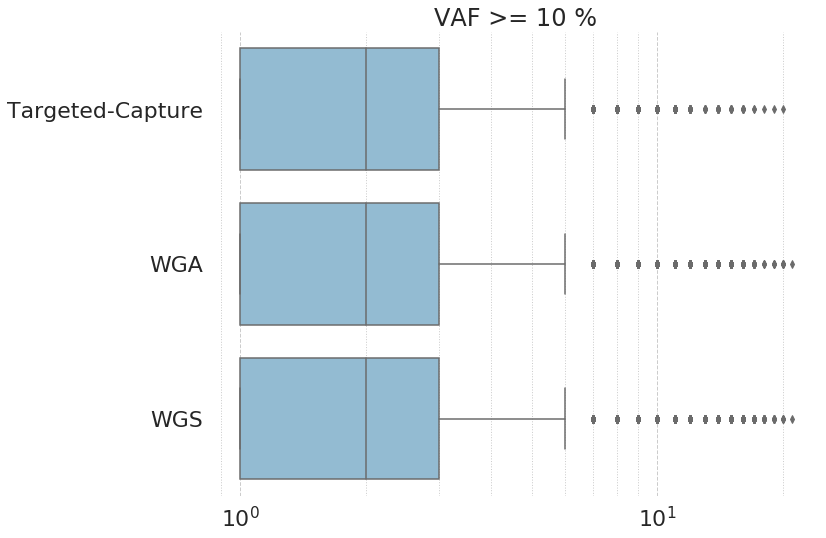

In [77]:
fig = plot_subclonal_per_sample(data=subclonal_snvs_filtered_vaf01, title="VAF >= 10 %")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_10.svg"), dpi=200)

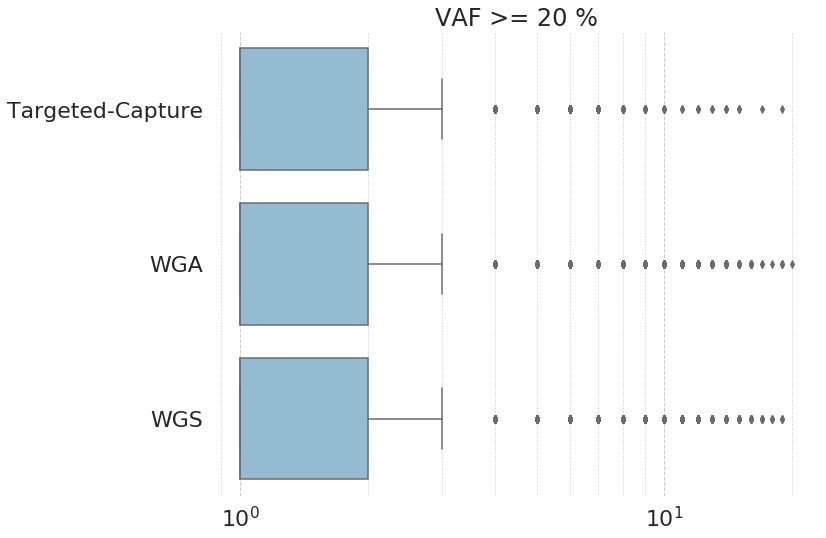

In [78]:
fig = plot_subclonal_per_sample(data=subclonal_snvs_filtered_vaf02, title="VAF >= 20 %")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_20.svg"), dpi=200)

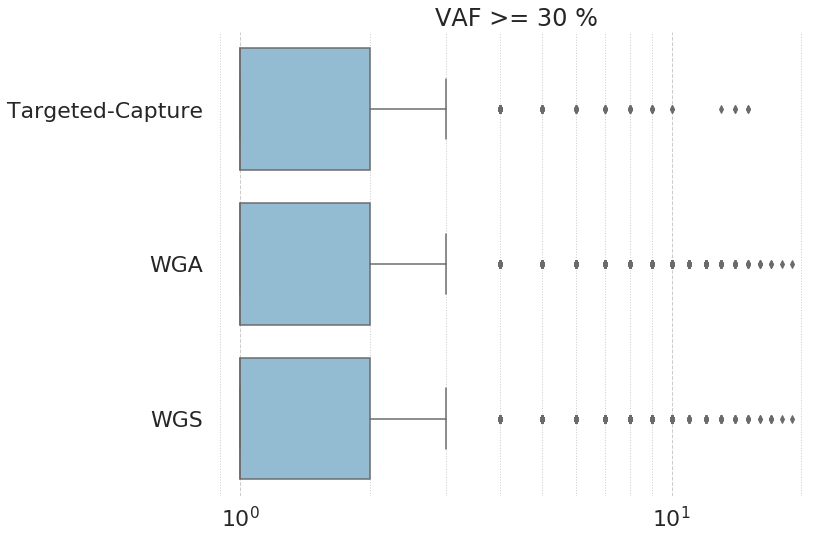

In [79]:
fig = plot_subclonal_per_sample(data=subclonal_snvs_filtered_vaf03, title="VAF >= 30 %")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_30.svg"), dpi=200)

### Recurrent subclonal variants

In [80]:
def filter_out_non_recurrent_variants(data, recurrence_threshold=2):
    counts = data[["variant_id", "sample"]].groupby("variant_id").count().reset_index().rename(columns={"sample": "count"})
    non_recurrent_variant_ids = counts[counts["count"] < recurrence_threshold].variant_id
    data_filtered = data[~data.variant_id.isin(non_recurrent_variant_ids)]
    print("Filtered out {} unique variants and {} variant calls".format(non_recurrent_variant_ids.shape[0], data.shape[0] - data_filtered.shape[0]))
    return data_filtered

In [81]:
subclonal_snvs_filtered_samples_recurrence2 = filter_out_non_recurrent_variants(data=subclonal_snvs_filtered_vaf0_sr0)

Filtered out 19383 unique variants and 19383 variant calls


In [82]:
subclonal_snvs_filtered_samples_recurrence3 = filter_out_non_recurrent_variants(data=subclonal_snvs_filtered_vaf0_sr0, recurrence_threshold=3)

Filtered out 30117 unique variants and 40851 variant calls


In [83]:
subclonal_snvs_filtered_samples_recurrence4 = filter_out_non_recurrent_variants(data=subclonal_snvs_filtered_vaf0_sr0, recurrence_threshold=4)

Filtered out 36821 unique variants and 60963 variant calls


In [84]:
subclonal_snvs_filtered_samples_vaf001_sr3_recurrence2 = filter_out_non_recurrent_variants(data=subclonal_snvs_filtered_vaf001)

Filtered out 18744 unique variants and 18744 variant calls


In [85]:
subclonal_snvs_filtered_samples_vaf01_sr3_recurrence2 = filter_out_non_recurrent_variants(data=subclonal_snvs_filtered_vaf01)

Filtered out 15818 unique variants and 15818 variant calls


## Variant allele frequency distribution through time

1,132 samples were excluded due to a missing collection date.

In [86]:
count_subclonal_variants_per_sample = subclonal_snvs_filtered_vaf002[["sample", "variant_id"]].groupby("sample").count().reset_index()
count_subclonal_variants_per_sample.head()

sample  variant_id
0  DRR287659           1
1  DRR287662           2
2  DRR287663           1
3  DRR287665           4
4  DRR287666           3

In [87]:
samples_with_counts = pd.merge(left=sample_ena_filtered_samples[["run_accession", "month"]], right=count_subclonal_variants_per_sample, left_on="run_accession", right_on="sample", how="inner")
samples_with_counts.head()

run_accession    month       sample  variant_id
0    ERR5078834  2020-09   ERR5078834           2
1    ERR9468310  2022-02   ERR9468310           5
2    ERR5885231  2021-01   ERR5885231           5
3   SRR12768734  2020-01  SRR12768734          19
4    ERR5063023  2020-08   ERR5063023           1

In [88]:
samples_with_counts.shape

(90084, 4)

In [89]:
subclonal_variant_with_month = pd.merge(left=subclonal_snvs_filtered_vaf002[["sample", "vaf"]], right=sample_ena_filtered_samples[["run_accession", "month"]], right_on="run_accession", left_on="sample", how="inner")

In [90]:
sample_counts_per_month = samples_with_counts[["month", "sample"]].groupby("month").count().reset_index()
sample_counts_per_month.head()

month  sample
0  2020-01     787
1  2020-02      89
2  2020-03    3894
3  2020-04    2098
4  2020-05     496

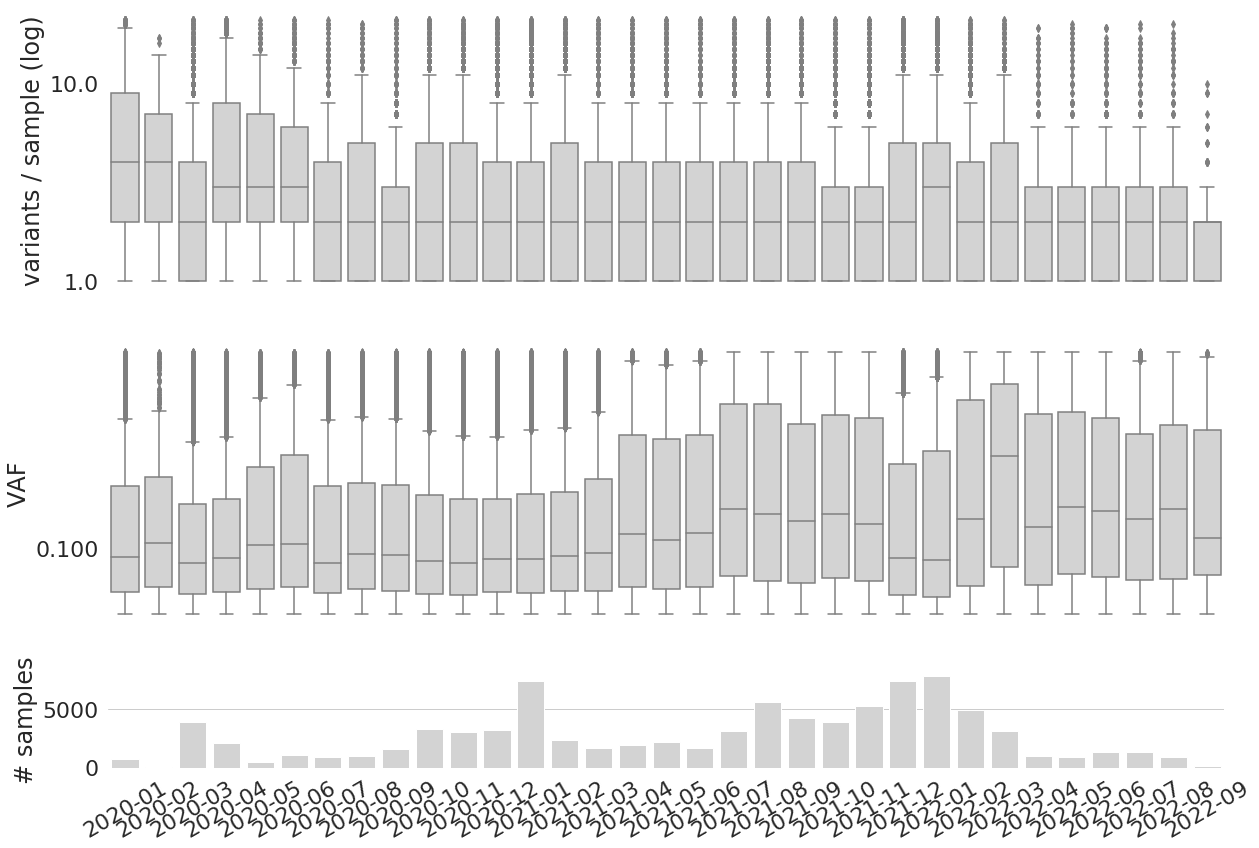

In [91]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20, 14), gridspec_kw={'height_ratios': [3, 3, 1]})
sns.boxplot(data=samples_with_counts.sort_values("month"), y="variant_id", x="month", ax=ax1, color='lightgrey')
sns.boxplot(data=subclonal_variant_with_month.sort_values("month"), y="vaf", x="month", ax=ax2, color='lightgrey')
sns.barplot(data=sample_counts_per_month, y="sample", x="month", ax=ax3, color='lightgrey')
ax1.set_ylabel("variants / sample (log)")
ax2.set_ylabel("VAF")
ax3.set_ylabel("# samples")
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xlabel(None)
ax2.set_xlabel(None)
ax3.set_xlabel(None)
plt.xticks(rotation=30)
sns.despine(bottom=True, left=True)
ax1.grid(axis='y')
ax2.grid(axis='y')
ax1.yaxis.set_major_formatter(ScalarFormatter())
ax1.ticklabel_format(style='plain', axis='y')
ax2.yaxis.set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(style='plain', axis='y')
fig.savefig(os.path.join(figure_output_folder, "figure_05_subclonal_variant_allele_frequencies_evolution.svg"), dpi=200)

## Population allele frequency of subclonal and clonal variants through time

In [92]:
all_variants = pd.concat([clonal_variants.loc[:, ["sample", "variant_id"]], subclonal_snvs_filtered_vaf002.loc[:, ["sample", "variant_id"]]])
all_variants = pd.merge(left=all_variants, right=sample_ena_filtered_samples[["run_accession", "month"]], left_on="sample", right_on="run_accession", how="inner")
all_variants.head()

sample variant_id run_accession    month
0  ERR10322829    241:C>T   ERR10322829  2022-03
1  ERR10322829    670:T>G   ERR10322829  2022-03
2  ERR10322829   2790:C>T   ERR10322829  2022-03
3  ERR10322829   3037:C>T   ERR10322829  2022-03
4  ERR10322829   3239:G>A   ERR10322829  2022-03

In [93]:
sample_counts_per_month["sample_cumsum"] = sample_counts_per_month.sort_values("month")["sample"].cumsum()
sample_counts_per_month.head()

month  sample  sample_cumsum
0  2020-01     787            787
1  2020-02      89            876
2  2020-03    3894           4770
3  2020-04    2098           6868
4  2020-05     496           7364

In [94]:
def plot_allele_frequencies_through_time(data, sample_counts_per_month, title):
    count_samples = data["sample"].unique().shape[0]
    count_variant_recurrence_per_month = data[["month", "sample", "variant_id"]].groupby(["month", "variant_id"]).count().reset_index()
    count_variant_recurrence_per_month.sort_values("month", inplace=True)
    count_variant_recurrence_per_month.rename(columns={"sample": "count"}, inplace=True)
    count_variant_recurrence_per_month["cumsum"] = count_variant_recurrence_per_month.groupby("variant_id")['count'].cumsum()
    count_variant_recurrence_per_month_with_sample_counts = pd.merge(left=count_variant_recurrence_per_month, right=sample_counts_per_month, on="month")
    count_variant_recurrence_per_month_with_sample_counts["af"] = count_variant_recurrence_per_month_with_sample_counts["cumsum"] / count_variant_recurrence_per_month_with_sample_counts["sample_cumsum"]
    count_variant_recurrence_per_month_with_sample_counts["af_intramonth"] = count_variant_recurrence_per_month_with_sample_counts["count"] / count_variant_recurrence_per_month_with_sample_counts["sample"]
    
    # plot
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(20, 14), gridspec_kw={'height_ratios': [3, 3]})
    sns.boxplot(data=count_variant_recurrence_per_month_with_sample_counts, x="month", y="af", ax=ax1, color="lightgrey")
    sns.boxplot(data=count_variant_recurrence_per_month_with_sample_counts, x="month", y="af_intramonth", ax=ax2, color="lightgrey")
    ax1.set_ylabel("accumulated allele frequency")
    ax2.set_ylabel("intra month allele frequency")
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.set_xlabel(None)
    ax2.set_xlabel(None)
    plt.xticks(rotation=30)
    sns.despine(bottom=True, left=True)
    ax1.grid(axis='y')
    ax2.grid(axis='y')
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.ticklabel_format(style='plain', axis='y')
    ax2.yaxis.set_major_formatter(ScalarFormatter())
    ax2.ticklabel_format(style='plain', axis='y')
    ax1.set_title(title)
    fig.savefig(os.path.join(figure_output_folder, "figure_05_population_allele_frequencies_evolution_{}.svg".format(title.lower().replace(" ", "_"))), dpi=200)

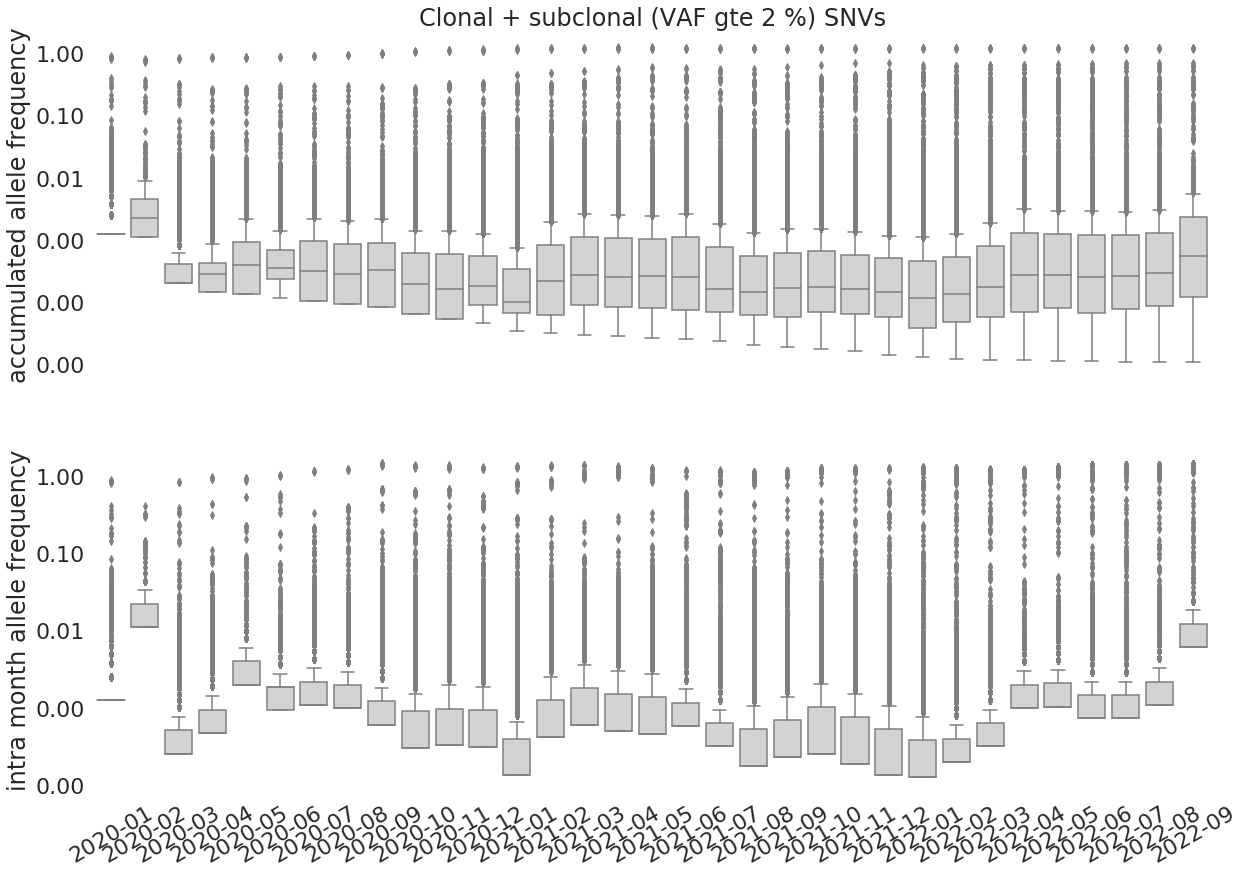

In [95]:
plot_allele_frequencies_through_time(data=all_variants, sample_counts_per_month=sample_counts_per_month, title="Clonal + subclonal (VAF gte 2 %) SNVs")

In [96]:
clonal_variants_with_month = pd.merge(left=clonal_snvs.loc[:, ["sample", "variant_id"]], 
                                      right=sample_ena_filtered_samples[["run_accession", "month"]], 
                                      left_on="sample", 
                                      right_on="run_accession", 
                                      how="inner")

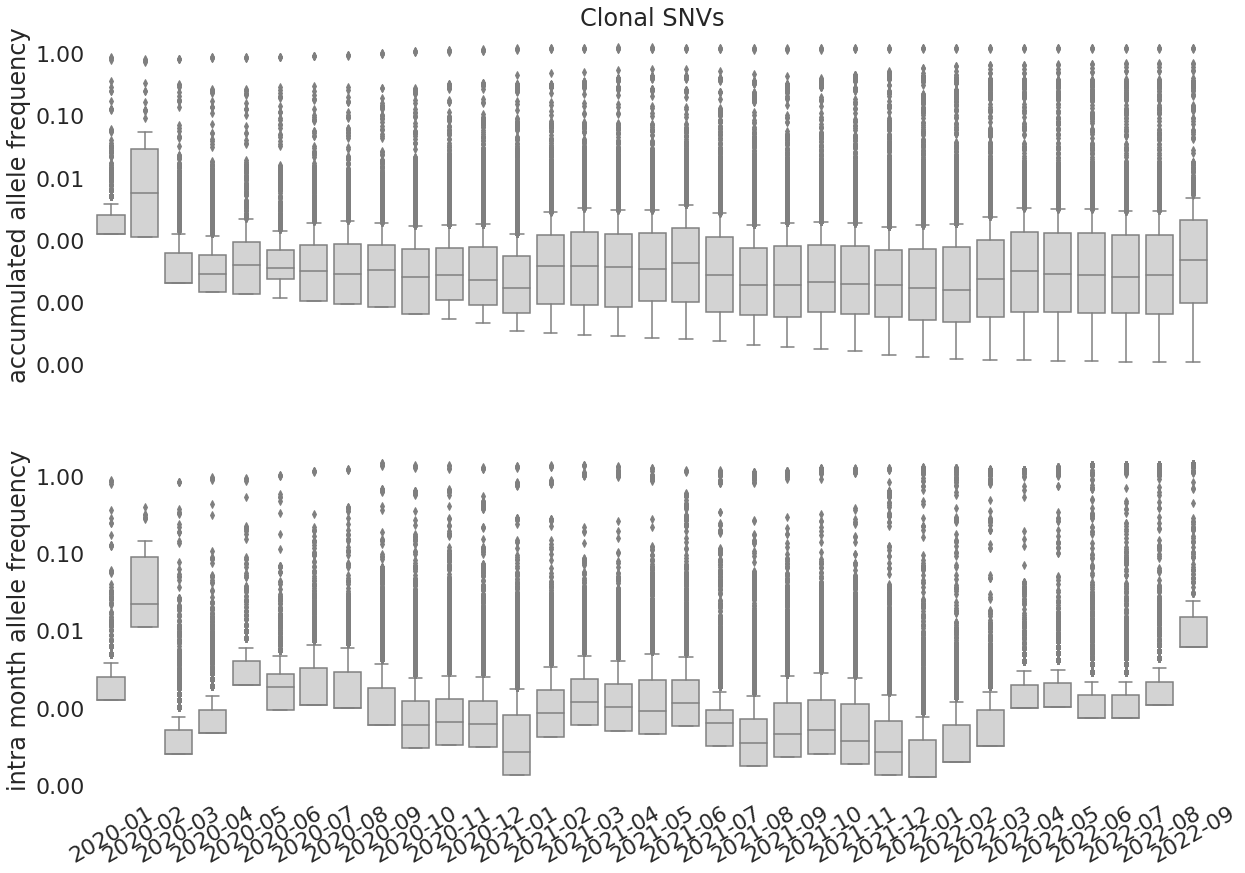

In [97]:
plot_allele_frequencies_through_time(data=clonal_variants_with_month, sample_counts_per_month=sample_counts_per_month, title="Clonal SNVs")

In [98]:
subclonal_variants_with_month = pd.merge(left=subclonal_snvs_filtered_vaf002.loc[:, ["sample", "variant_id"]], 
                                         right=sample_ena_filtered_samples[["run_accession", "month"]], 
                                         left_on="sample", 
                                         right_on="run_accession", 
                                         how="inner")

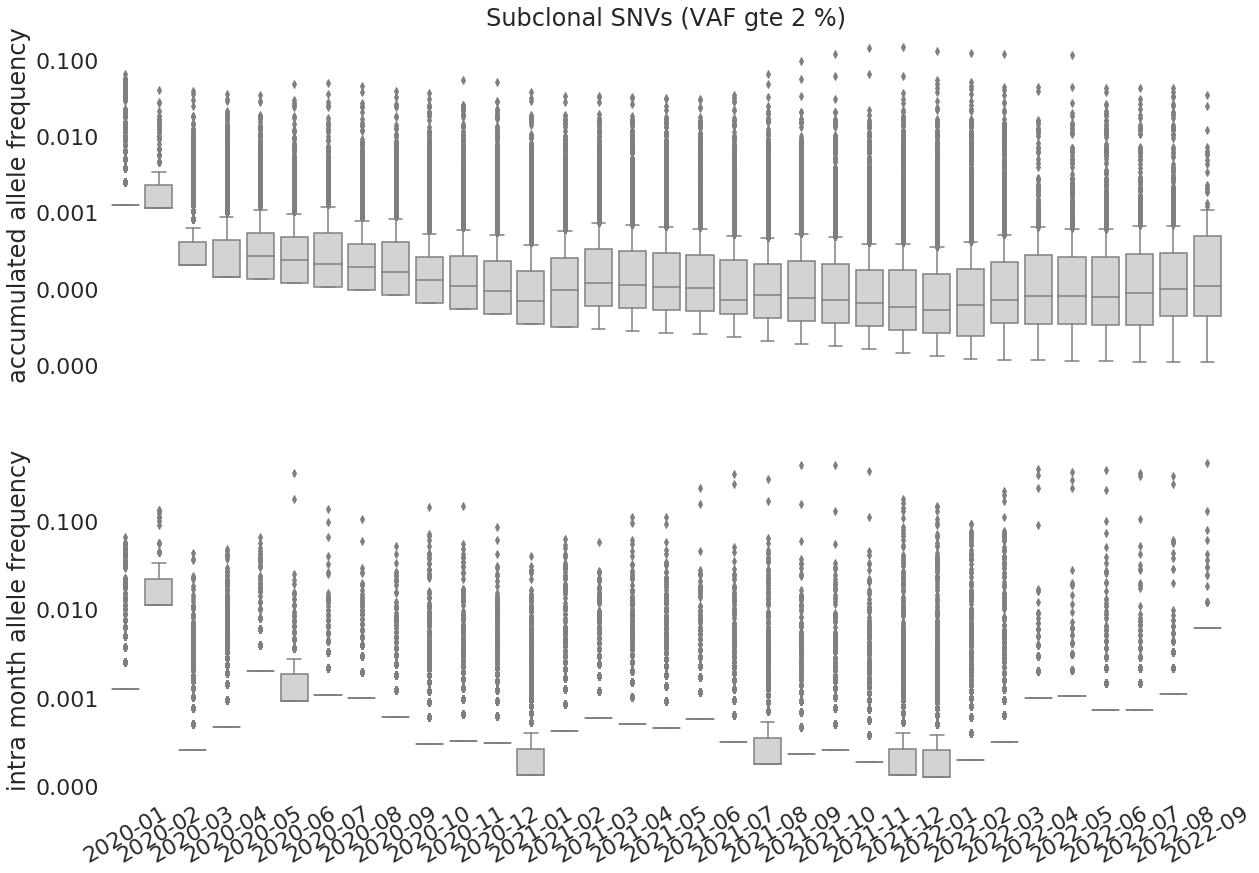

In [99]:
plot_allele_frequencies_through_time(data=subclonal_variants_with_month, sample_counts_per_month=sample_counts_per_month, title="Subclonal SNVs (VAF gte 2 %)")

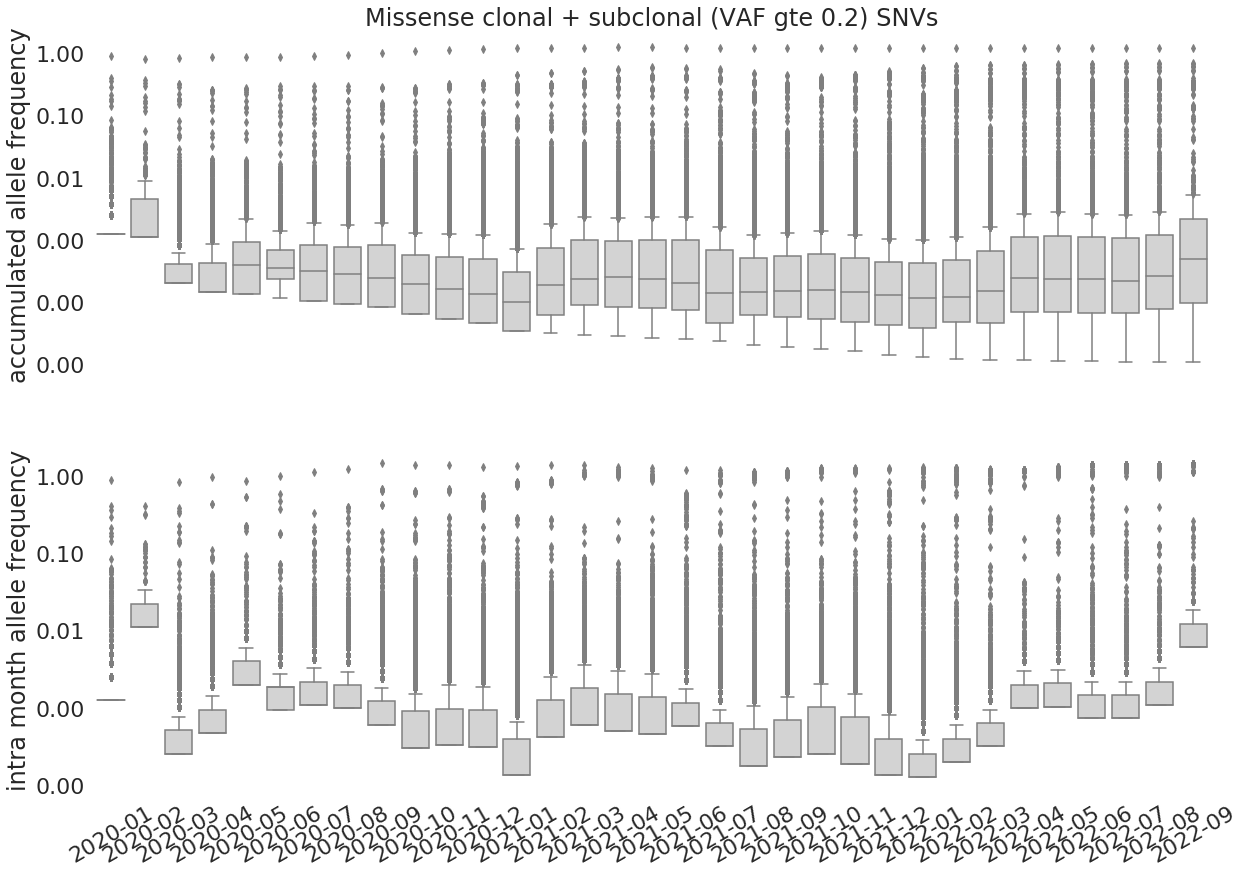

In [100]:
ns_all_variants_with_month = pd.merge(
    left=pd.concat([subclonal_snvs_filtered_vaf002.loc[subclonal_snvs_filtered_vaf002["annotation_highest_impact"] == "missense_variant", ["sample", "variant_id"]], 
                    clonal_variants.loc[clonal_variants["annotation_highest_impact"] == "missense_variant", ["sample", "variant_id"]]]),
    right=sample_ena_filtered_samples[["run_accession", "month"]], left_on="sample", right_on="run_accession", how="inner")
plot_allele_frequencies_through_time(data=ns_all_variants_with_month, sample_counts_per_month=sample_counts_per_month, title="Missense clonal + subclonal (VAF gte 0.2) SNVs")

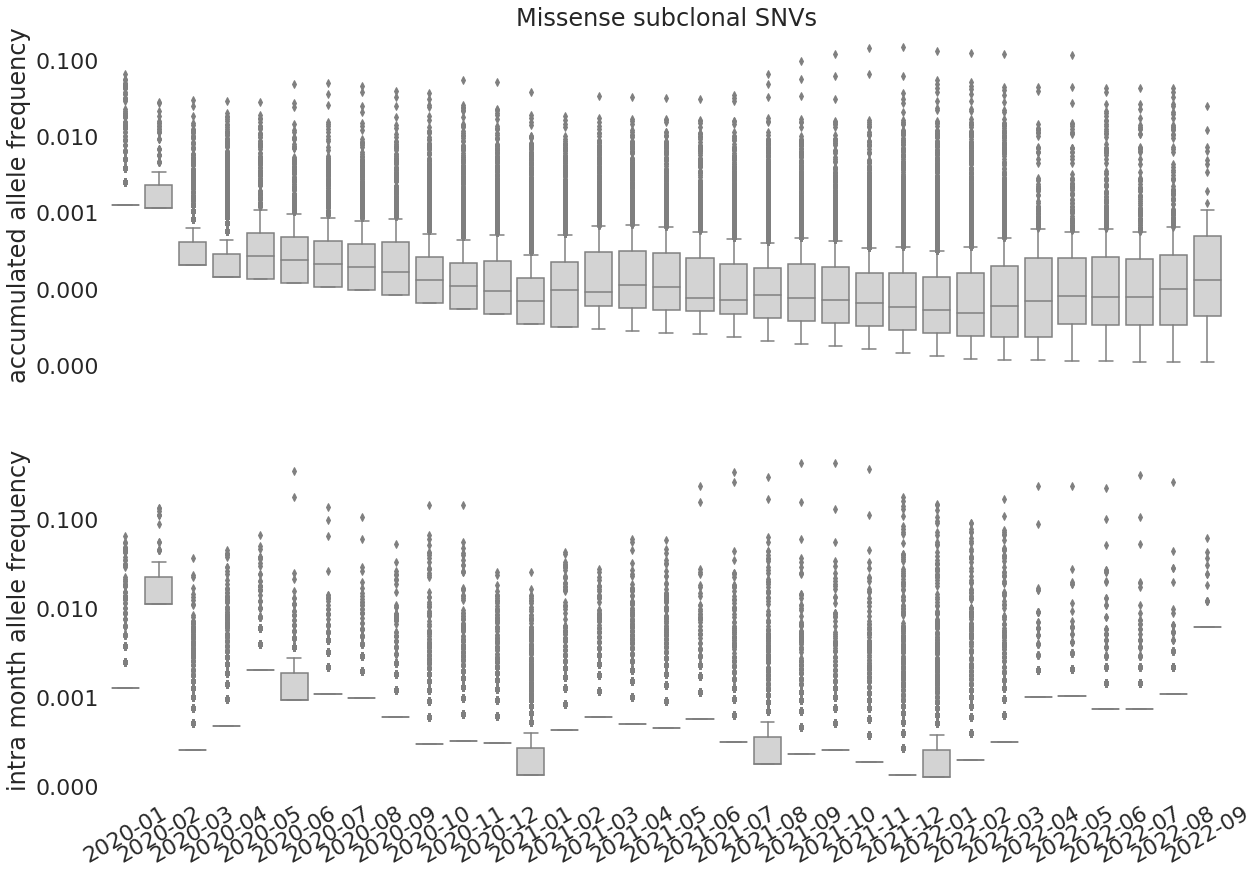

In [101]:
ns_subclonal_variants_with_month = pd.merge(
    left=subclonal_snvs_filtered_vaf002.loc[subclonal_snvs_filtered_vaf002["annotation_highest_impact"] == "missense_variant", ["sample", "variant_id"]], 
    right=sample_ena_filtered_samples[["run_accession", "month"]], left_on="sample", right_on="run_accession", how="inner")
plot_allele_frequencies_through_time(data=ns_subclonal_variants_with_month, sample_counts_per_month=sample_counts_per_month, title="Missense subclonal SNVs")

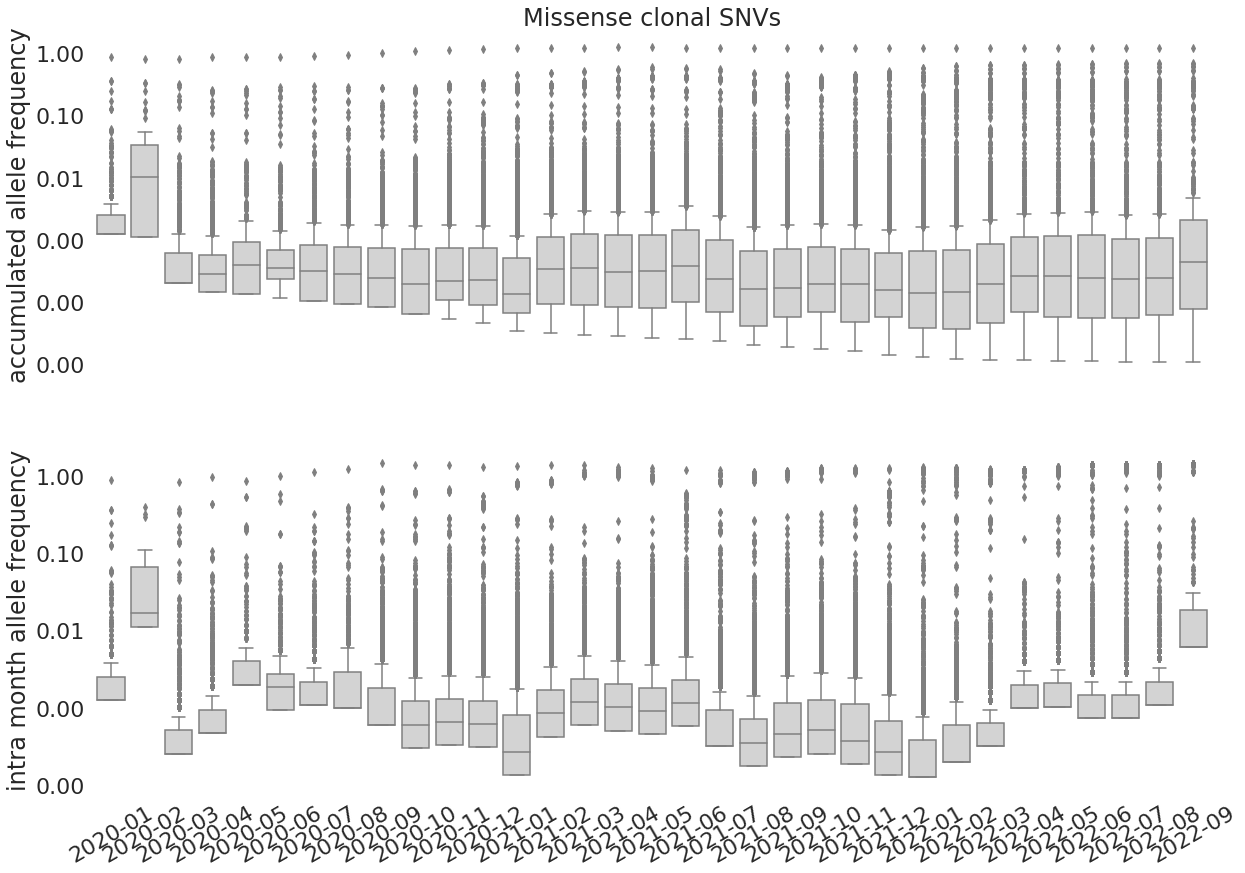

In [102]:
ns_clonal_variants_with_month = pd.merge(
    left=clonal_variants.loc[clonal_variants["annotation_highest_impact"] == "missense_variant", ["sample", "variant_id"]], 
    right=sample_ena_filtered_samples[["run_accession", "month"]], left_on="sample", right_on="run_accession", how="inner")
plot_allele_frequencies_through_time(data=ns_clonal_variants_with_month, sample_counts_per_month=sample_counts_per_month, title="Missense clonal SNVs")

## Correlations between clonal and subclonal

In [103]:
def plot_correlation(sample_data, clonal_data, subclonal_data, title=None):
    
    included_samples = sample_data.run_accession.unique()
    frequencies_clonal_snvs = clonal_data[clonal_data["sample"].isin(included_samples)][["variant_id", "sample"]].groupby("variant_id").count().reset_index()
    frequencies_clonal_snvs["af"] = frequencies_clonal_snvs["sample"] / included_samples.shape[0]
    frequencies_subclonal_snvs = subclonal_data[subclonal_data["sample"].isin(included_samples)][["variant_id", "sample"]].groupby("variant_id").count().reset_index()
    frequencies_subclonal_snvs["af"] = frequencies_subclonal_snvs["sample"] / included_samples.shape[0]
    frequencies_snvs = pd.merge(left=frequencies_clonal_snvs[["variant_id", "af"]], right=frequencies_subclonal_snvs[["variant_id", "af"]], on="variant_id", suffixes=("_clonal", "_subclonal"))
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    sns.regplot(data=frequencies_snvs, x="af_clonal", y="af_subclonal")
    plt.xticks(rotation=30)
    sns.despine(bottom=True, left=True)
    ax.set_xlabel("Clonal abundance")
    ax.set_ylabel("Subclonal abundance")
    plt.title("{} Pearson corr={}".format(title, round(frequencies_snvs.corr().af_subclonal[0], 3)))
    return fig

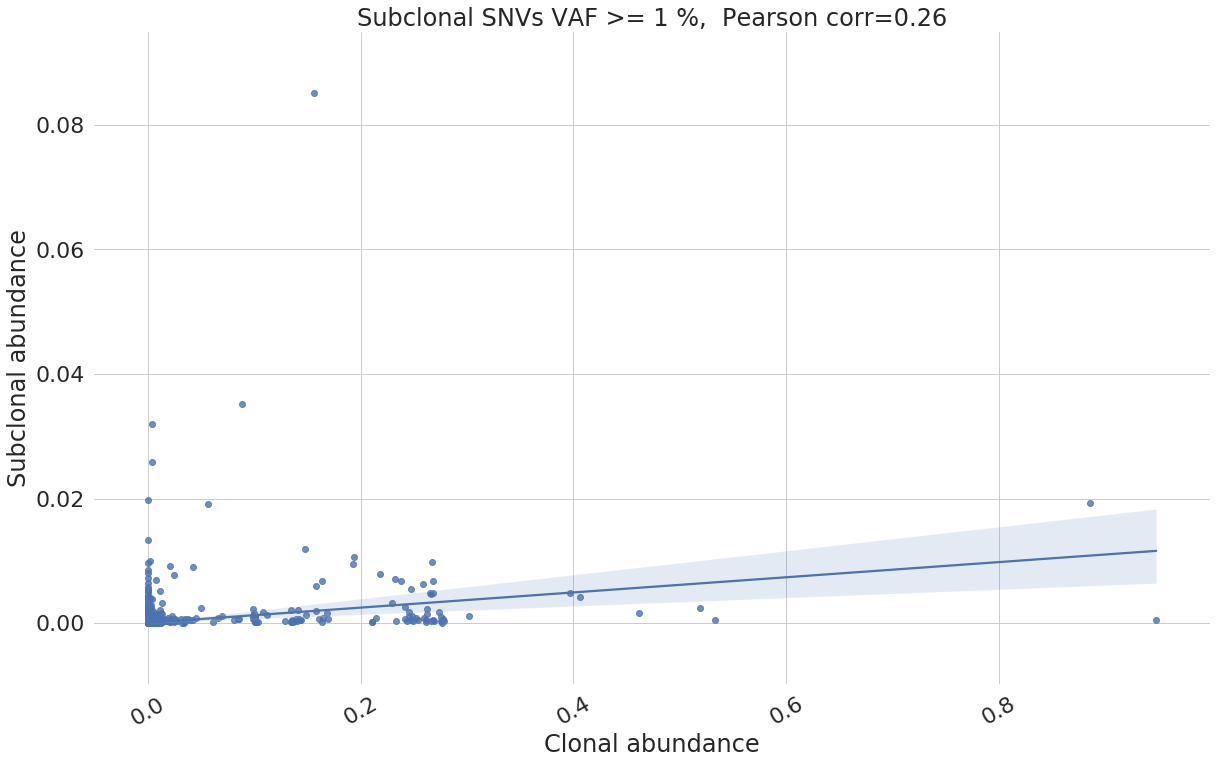

In [104]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf001), 
                 title="Subclonal SNVs VAF >= 1 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_1.svg"), dpi=200)

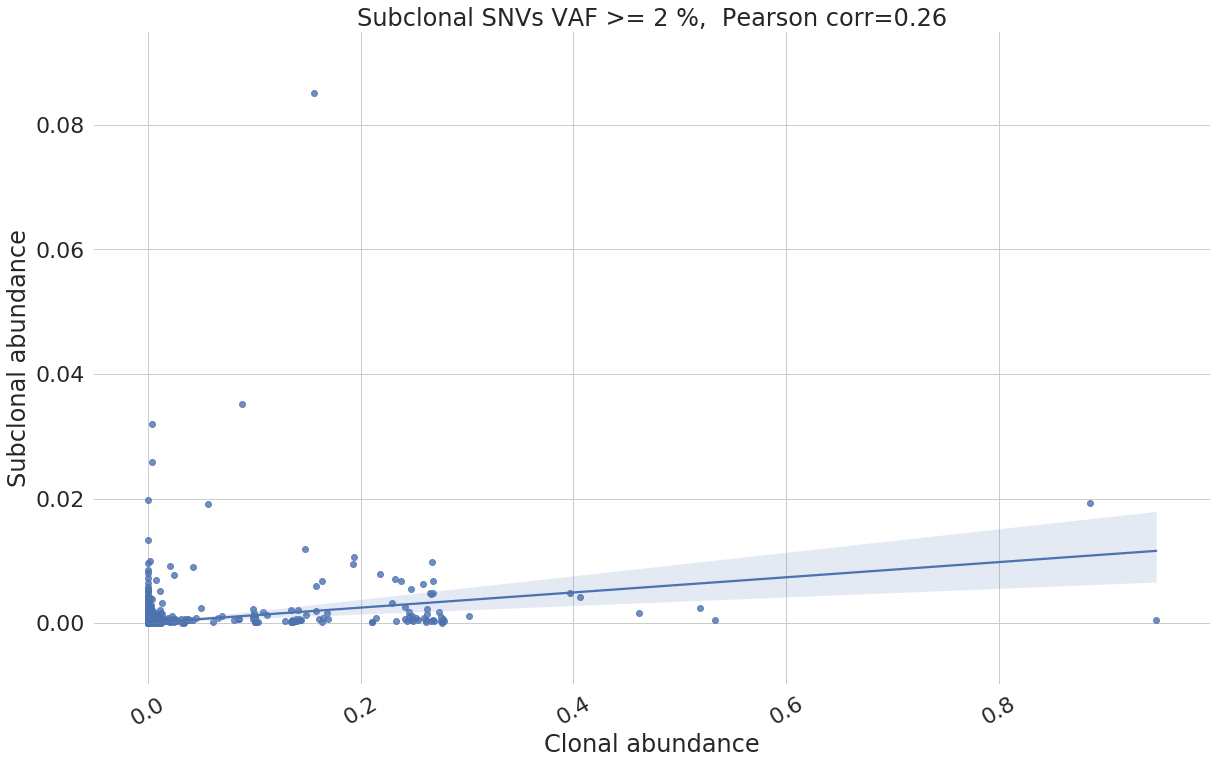

In [105]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf002), 
                 title="Subclonal SNVs VAF >= 2 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_2.svg"), dpi=200)

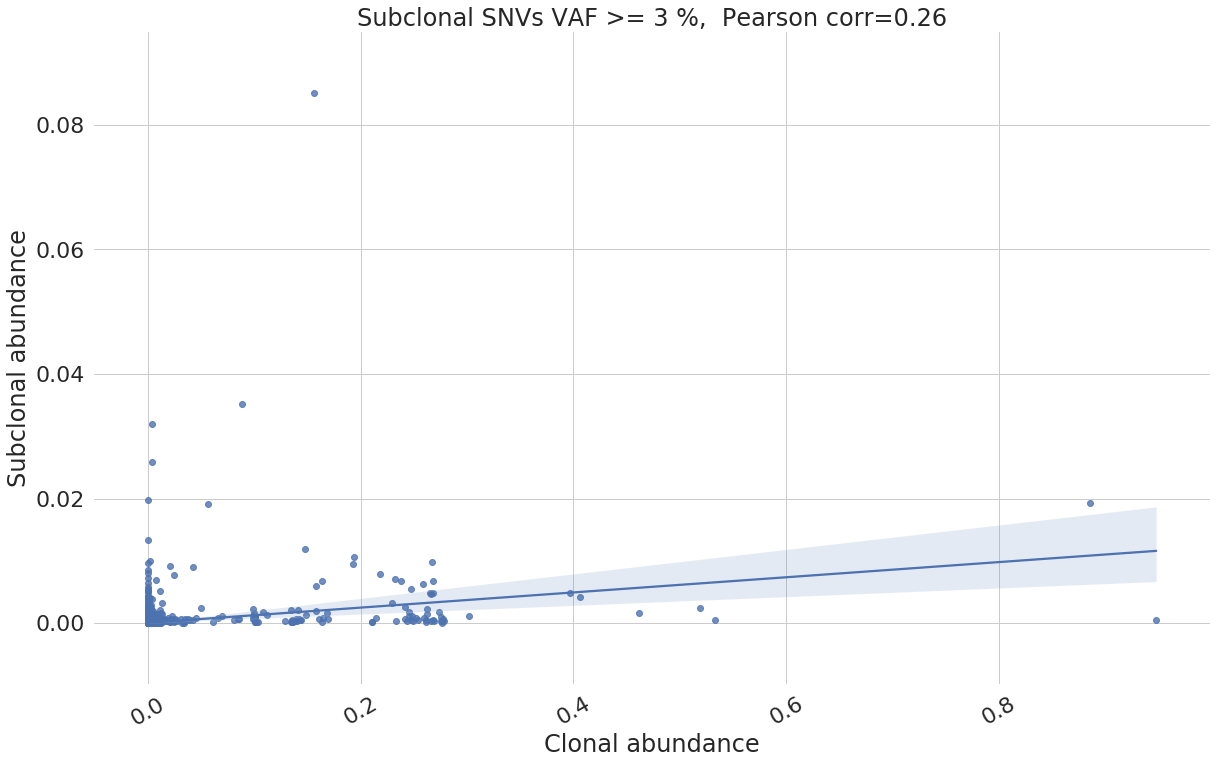

In [106]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf003), 
                 title="Subclonal SNVs VAF >= 3 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_3.svg"), dpi=200)

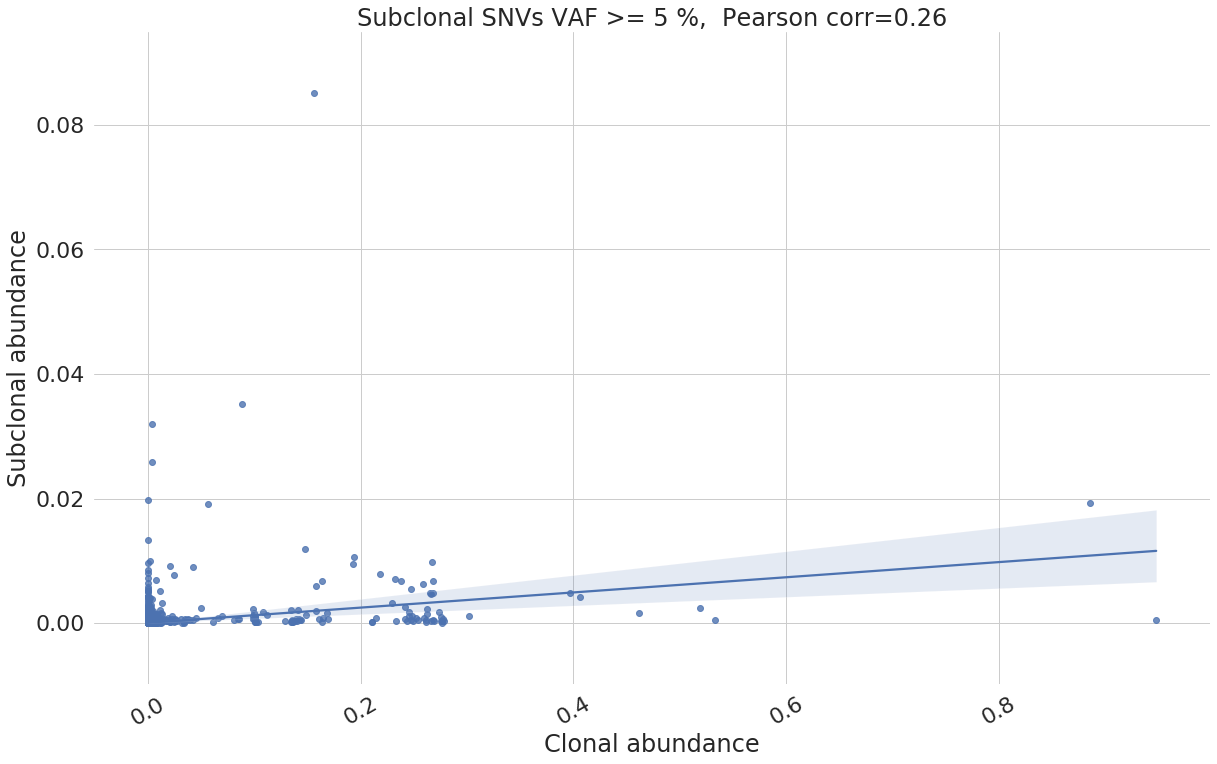

In [107]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf005), 
                 title="Subclonal SNVs VAF >= 5 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_5.svg"), dpi=200)

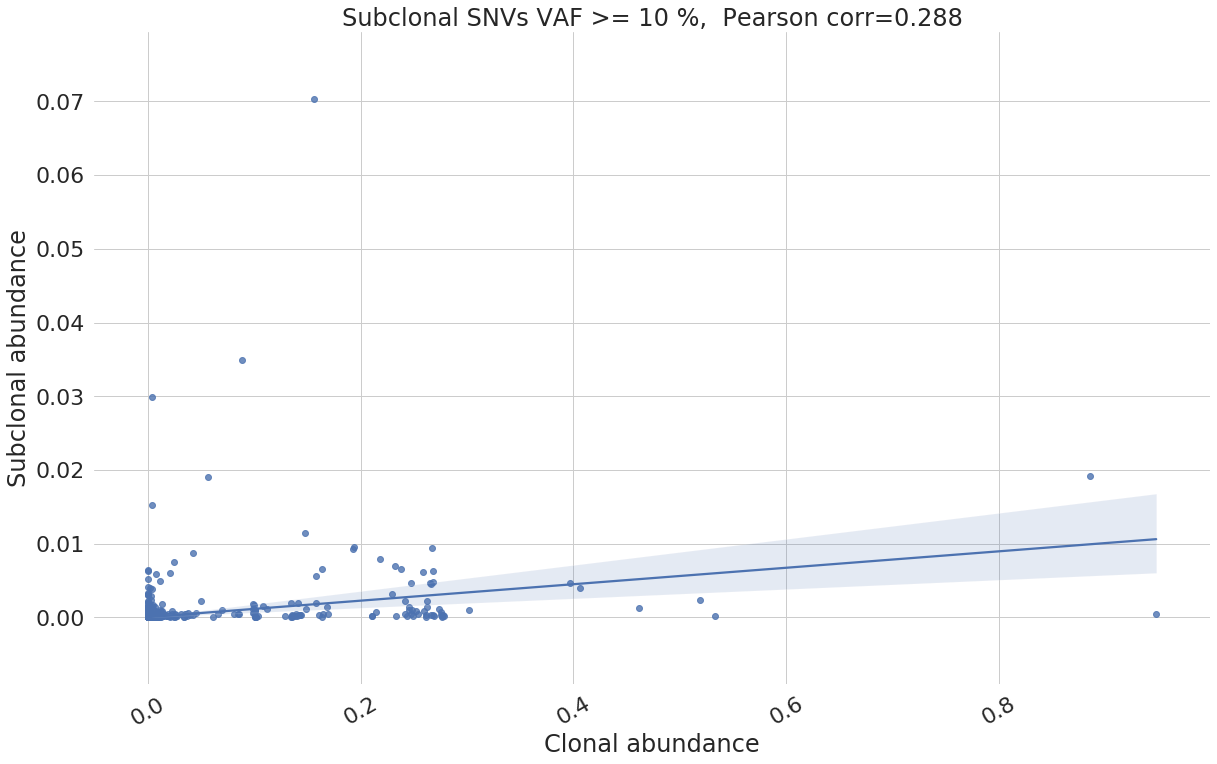

In [108]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf01), 
                 title="Subclonal SNVs VAF >= 10 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_10.svg"), dpi=200)

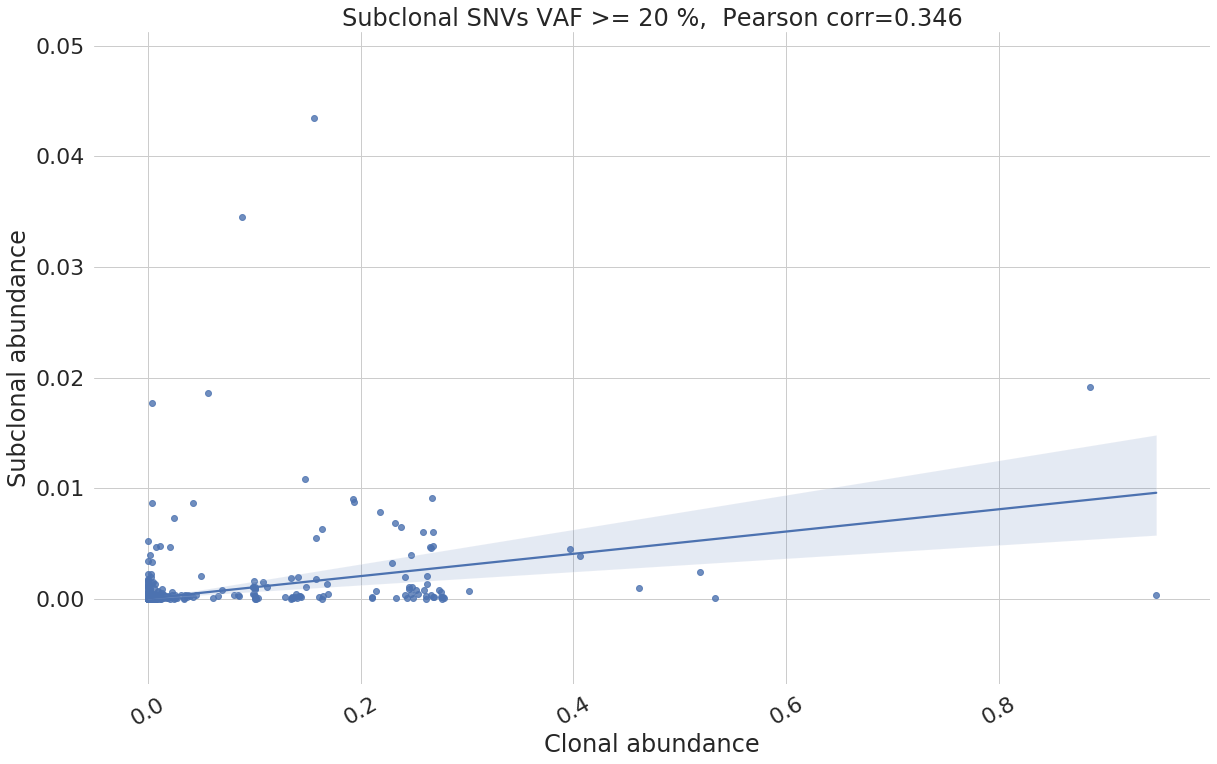

In [109]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf02), 
                 title="Subclonal SNVs VAF >= 20 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_20.svg"), dpi=200)

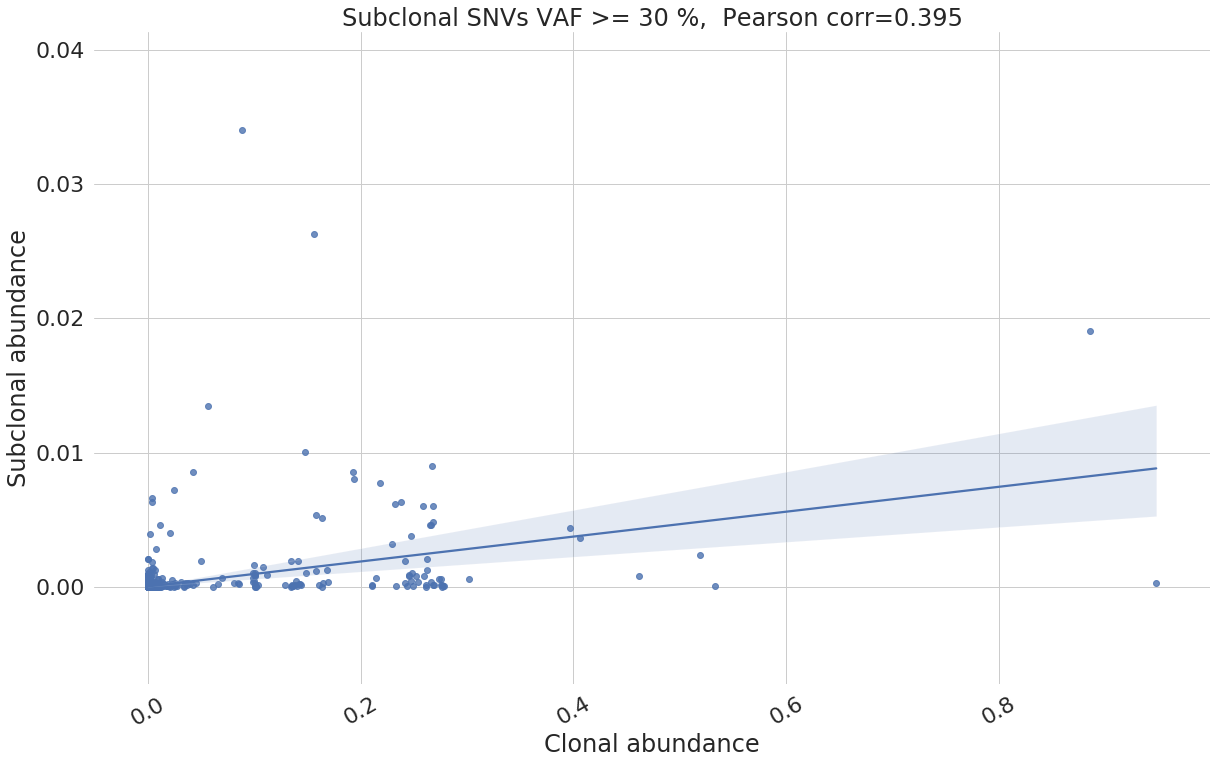

In [110]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf03), 
                 title="Subclonal SNVs VAF >= 30 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_30.svg"), dpi=200)

## Correlation between clonal abundance and conservation

In [111]:
def plot_correlation_conservation(sample_data, clonal_data, title=None):
    
    included_samples = sample_data.run_accession.unique()
    frequencies_clonal_snvs = clonal_data[clonal_data["sample"].isin(included_samples)][["variant_id", "sample"]].groupby("variant_id").count().reset_index()
    frequencies_clonal_snvs["af"] = frequencies_clonal_snvs["sample"] / included_samples.shape[0]
    
    conservation_data = clonal_data[clonal_data["sample"].isin(included_samples)][["variant_id", "cons_hmm_sars_cov_2"]].groupby("variant_id").first().reset_index()
    
    data = pd.merge(left=frequencies_clonal_snvs, right=conservation_data, on="variant_id", how="left")
    
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    sns.regplot(data=data, x="af", y="cons_hmm_sars_cov_2")
    plt.xticks(rotation=30)
    sns.despine(bottom=True, left=True)
    ax.set_xlabel("Clonal abundance")
    ax.set_ylabel("ConsHMM on SARS-CoV-2")
    plt.title("{} Pearson corr={}".format(title, round(data.corr().af[2], 3)))
    print(data.corr())
    return fig

                       sample        af  cons_hmm_sars_cov_2
sample               1.000000  1.000000            -0.017431
af                   1.000000  1.000000            -0.017431
cons_hmm_sars_cov_2 -0.017431 -0.017431             1.000000


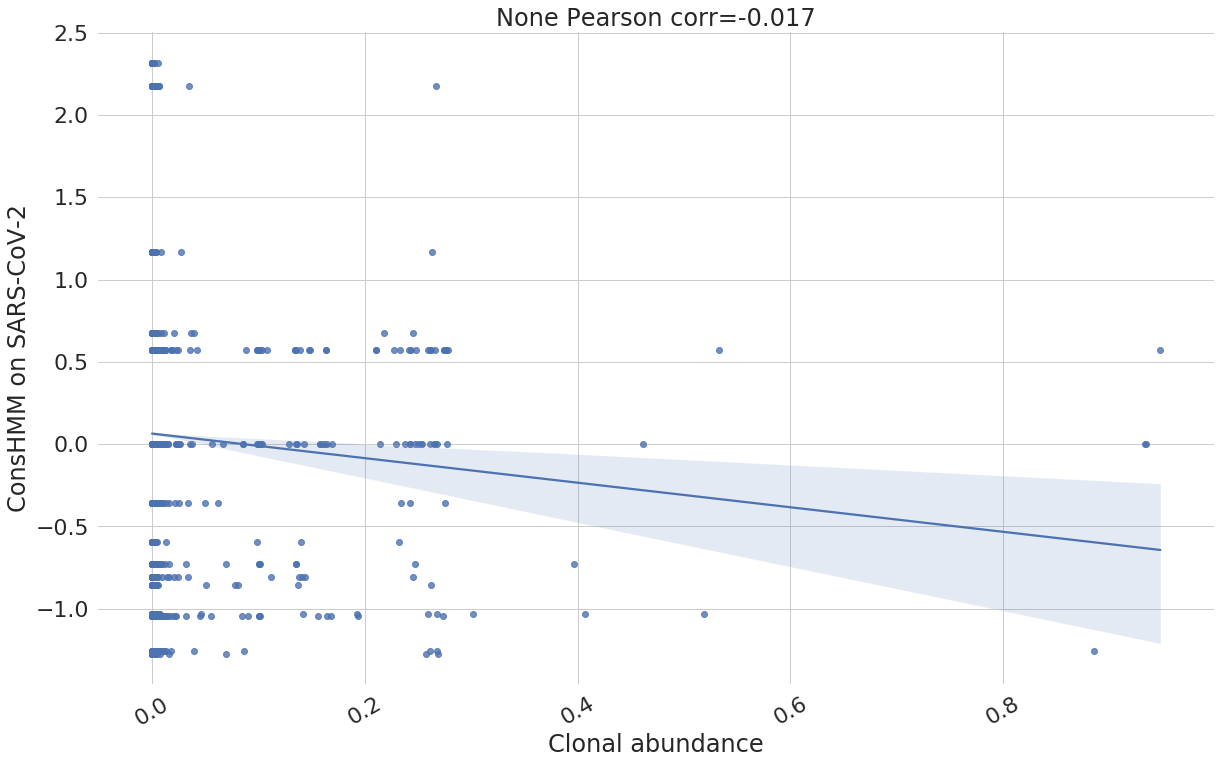

In [112]:
fig = plot_correlation_conservation(sample_data=sample_ena_filtered_samples, clonal_data=clonal_snvs)

                       sample        af  cons_hmm_sars_cov_2
sample               1.000000  1.000000            -0.024664
af                   1.000000  1.000000            -0.024664
cons_hmm_sars_cov_2 -0.024664 -0.024664             1.000000


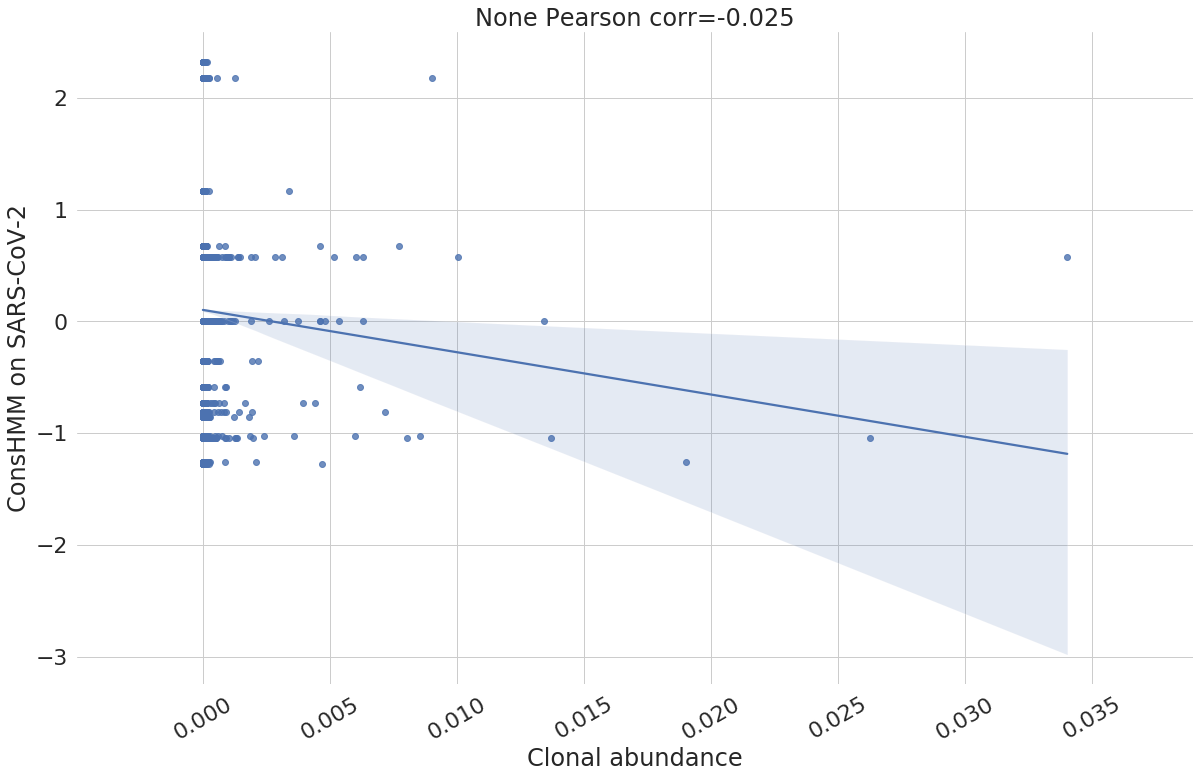

In [113]:
fig = plot_correlation_conservation(sample_data=sample_ena_filtered_samples, clonal_data=subclonal_snvs_filtered_vaf03)

In [114]:
clonal_snvs.shape

(4278222, 37)

## Evolution from subclonal into clonal

In [115]:
def plot_upset(clonal_data, subclonal_data, month):
    data = pd.merge(left=clonal_data[clonal_data.month <= month][["variant_id", "clonal"]],
             right=subclonal_data[subclonal_data.month <= month][["variant_id", "subclonal"]],
             on="variant_id", how="outer").fillna(False)[["variant_id", "clonal", "subclonal"]].groupby("variant_id").sum().reset_index()
    data.clonal = data.clonal.astype(bool)
    data.subclonal = data.subclonal.astype(bool)
    data.set_index(["clonal", "subclonal"], inplace=True)
    #return data
    fig = plt.figure(figsize=(10,6))
    upset = UpSet(data, subset_size='auto', intersection_plot_elements=2, facecolor='steelblue', show_counts=True, element_size=80)
    upset.plot(fig=fig)
    plt.title("Until {}                                                                                                                 ".format(month))
    fig.savefig("clonal_subclonal_upset_until_{}.jpg".format(month), dpi=200)

In [218]:
def plot_subclonal_clonal_through_time(clonal_data, subclonal_data, samples_data, title=None):
    
    subclonal_data = add_dates_to_variants(variants=subclonal_data, samples=samples_data)
    clonal_data = add_dates_to_variants(variants=clonal_data, samples=samples_data)
    
    months = list(clonal_data.collection_date_month.sort_values().unique())
    only_clonal = []
    only_subclonal = []
    both = []
    
    for m in months:
        subclonal_variant_ids = set(subclonal_data[subclonal_data.collection_date_month <= m].variant_id.unique())
        clonal_variant_ids = set(clonal_data[clonal_data.collection_date_month <= m].variant_id.unique())
        both.append(len(subclonal_variant_ids.intersection(clonal_variant_ids)))
        only_clonal.append(len(clonal_variant_ids.difference(subclonal_variant_ids)))
        only_subclonal.append(len(subclonal_variant_ids.difference(clonal_variant_ids)))
    
    all_counts = [x + y + z for x, y, z in  zip(only_clonal, only_subclonal, both)] 
    
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    sns.lineplot(x=pd.Series(months).astype(str), y=both, color=orange, label="Intrahost + clonal ({})".format(both[-1]), marker='o')
    sns.lineplot(x=pd.Series(months).astype(str), y=only_clonal, color=lightblue, label="Only clonal ({})".format(only_clonal[-1]), marker='o')
    sns.lineplot(x=pd.Series(months).astype(str), y=only_subclonal, color=green, label="Only intrahost ({})".format(only_subclonal[-1]), marker='o')
    sns.lineplot(x=pd.Series(months).astype(str), y=all_counts, color=grey, label="All ({})".format(all_counts[-1]), linestyle='--')
    plt.axhline(SARS_COV_2_GENOME_LENGTH * 3, linestyle='--', color=red, label="Max. number SNVs")
    plt.title(title)
    plt.xlabel(None)
    plt.ylabel("Accum. number of unique mutations")
    plt.yscale('log')
    plt.xticks(rotation=75)
    plt.minorticks_on()
    sns.despine(bottom=True, left=True)
    ax.legend()
    #ax.grid(axis='x')
    ax.grid(axis='x', which='major', alpha=0.5, linewidth=0.5)
    ax.grid(axis='y', which='minor', alpha=0.5, linestyle='dashed', linewidth=0.5)
    #ax.yaxis.set_major_formatter(ScalarFormatter())
    #ax.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    return fig

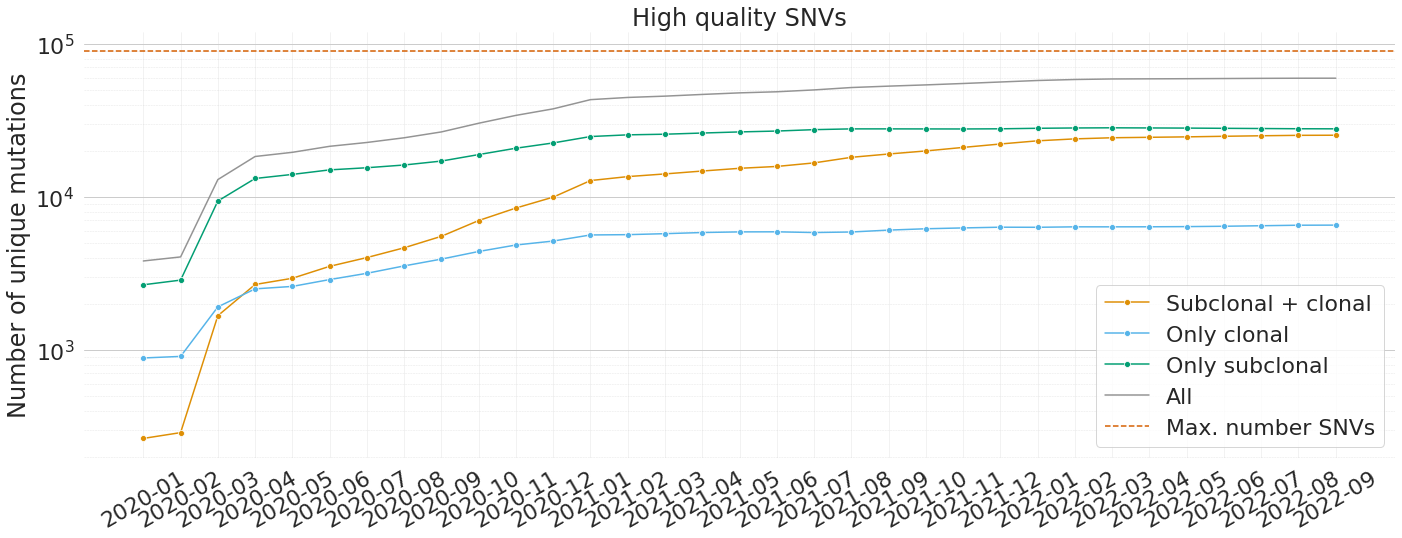

In [117]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf0_sr0, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs.svg"), dpi=200)

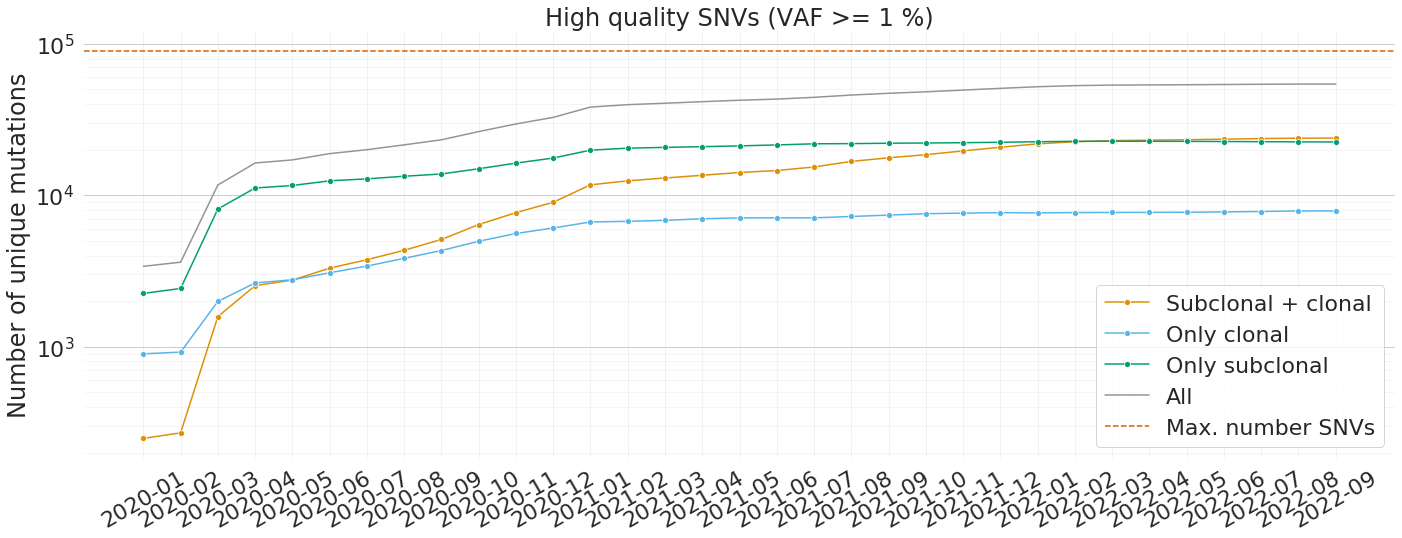

In [118]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf001, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 1 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_1.svg"), dpi=200)

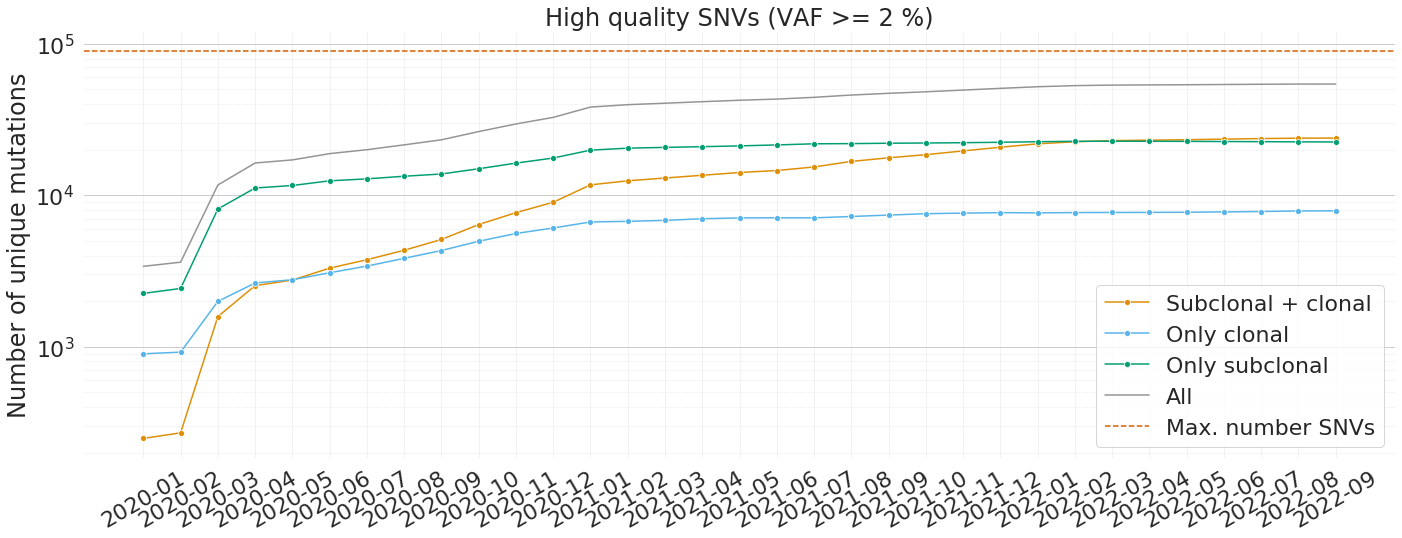

In [119]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf002, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 2 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_2.svg"), dpi=200)

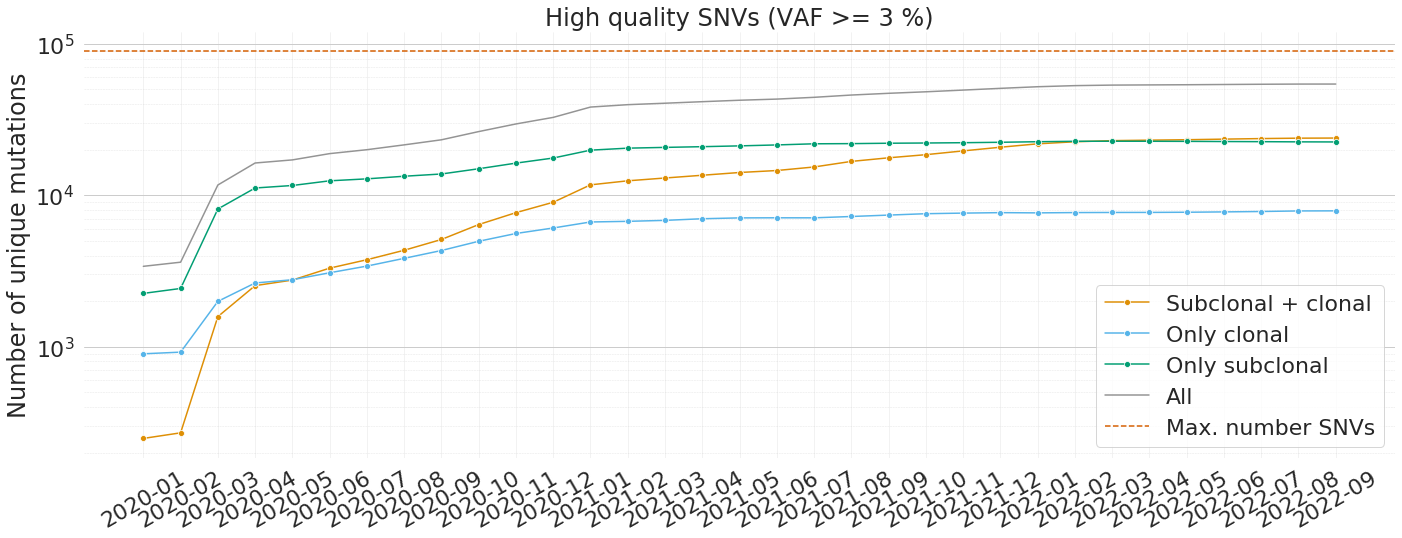

In [120]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf003, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 3 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_3.svg"), dpi=200)

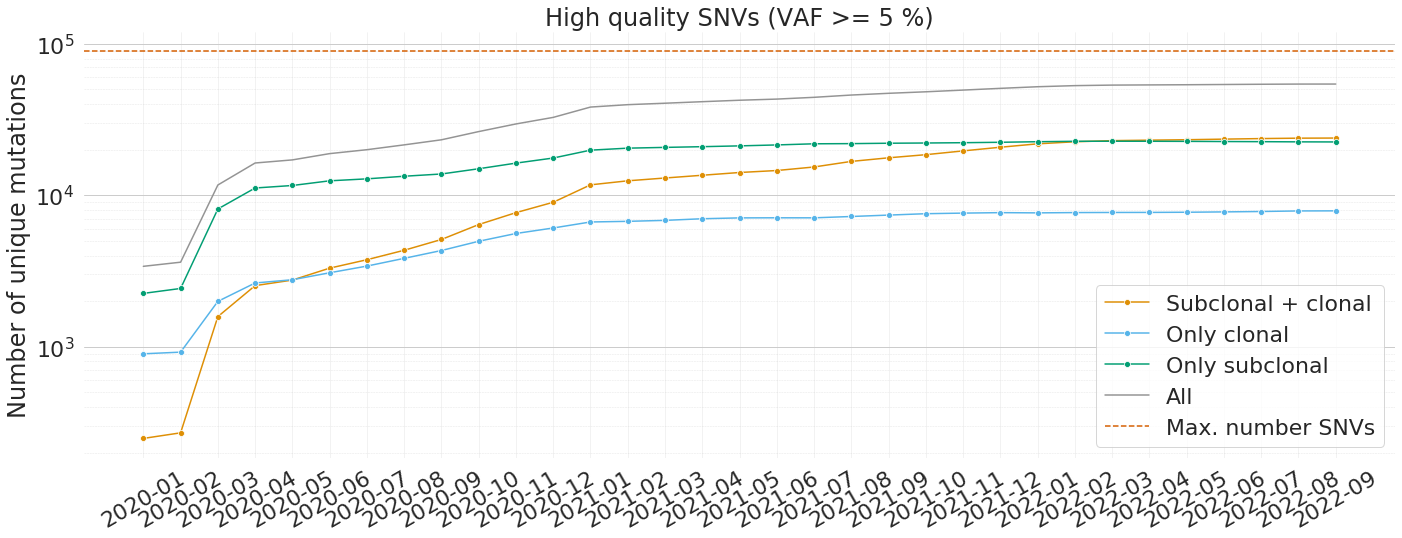

In [121]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf005, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 5 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_5.svg"), dpi=200)

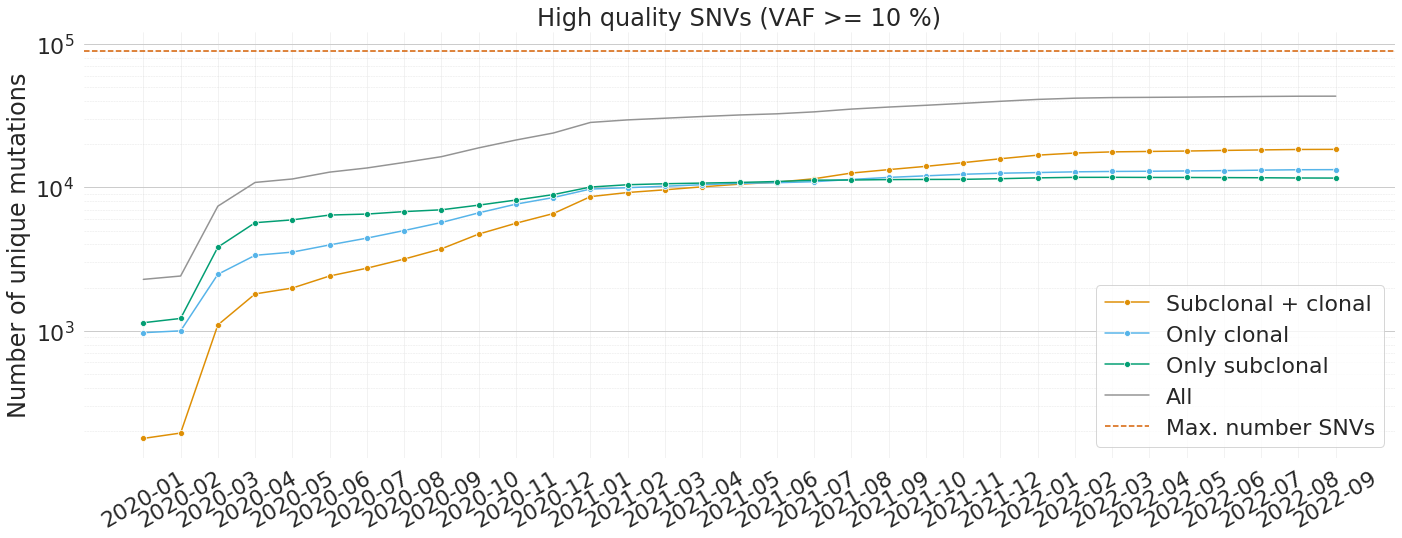

In [122]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf01, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 10 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_10.svg"), dpi=200)

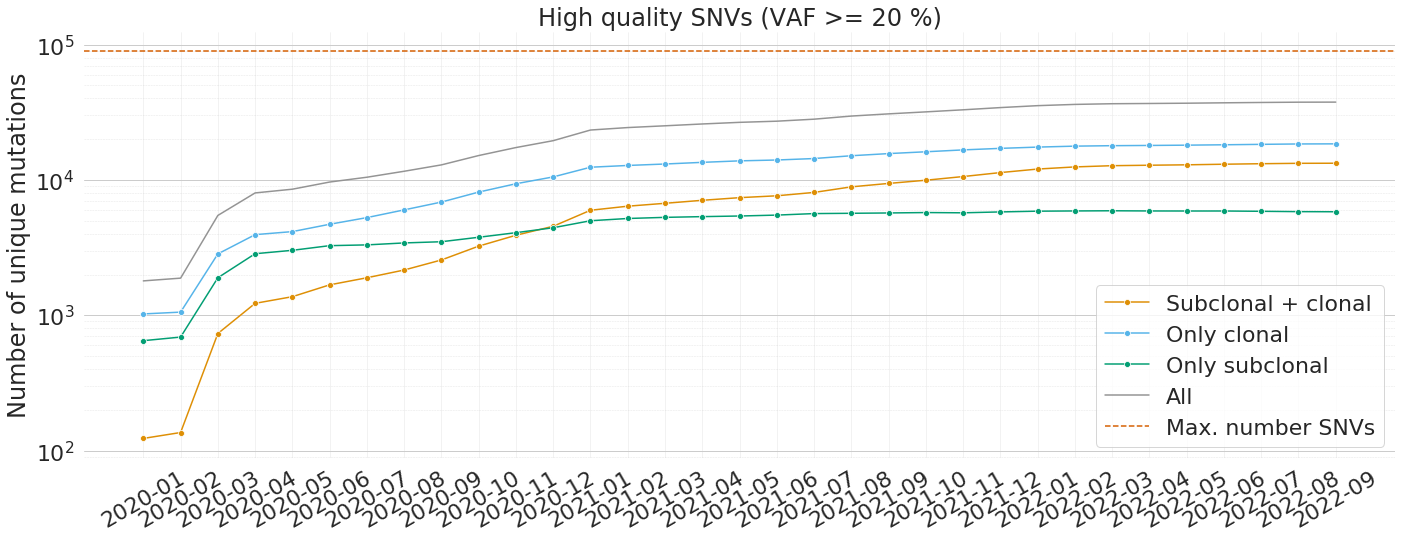

In [123]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf02, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 20 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_20.svg"), dpi=200)

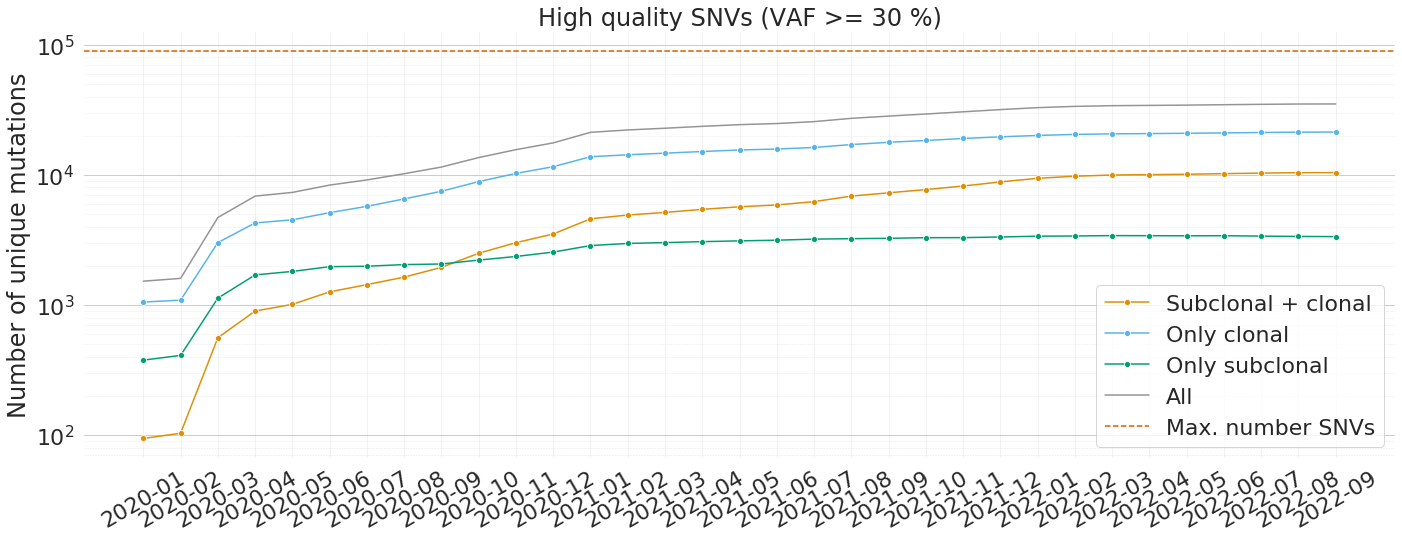

In [124]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf03, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 30 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_30.svg"), dpi=200)

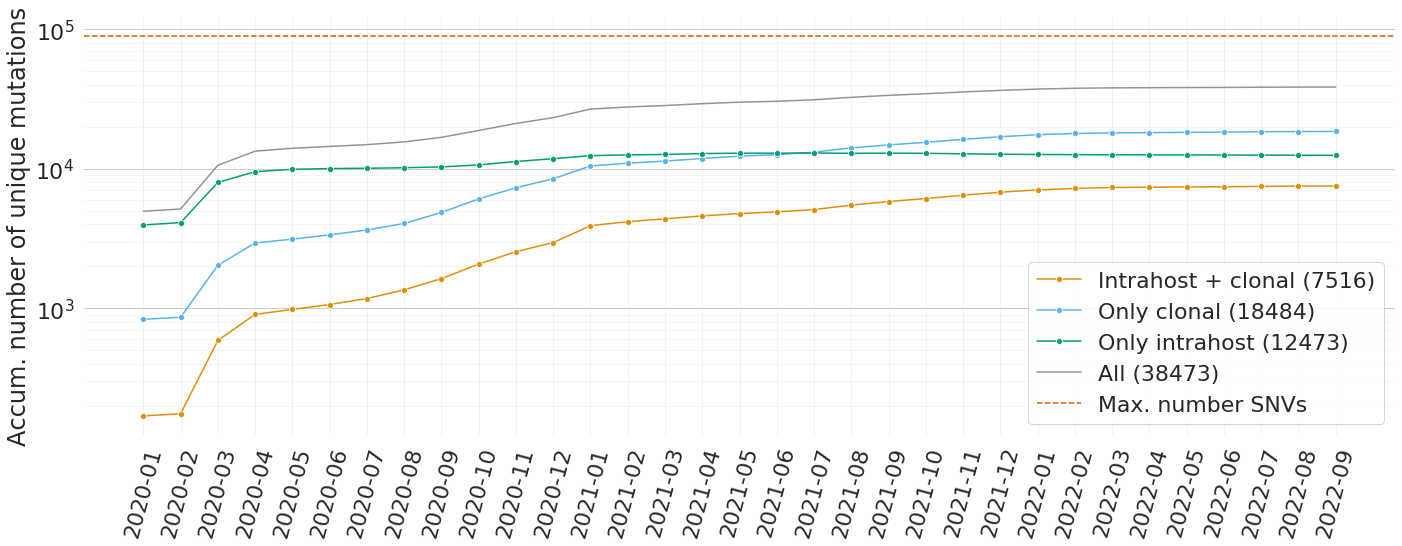

In [219]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants[(clonal_variants.variant_type == 'SNV') & 
                                (clonal_variants["sample"].isin(high_quality_intrahost_variants["sample"].unique()))], 
    subclonal_data=high_quality_intrahost_variants[high_quality_intrahost_variants.variant_type == 'SNV'], 
    samples_data=sample_ena[sample_ena.run_accession.isin(high_quality_intrahost_variants["sample"].unique())])
    #title="High quality iSNVs")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_hc_snvs.png"), dpi=200)

In [221]:
float(6215)/(7516 + 18484)

0.23903846153846153

In [176]:
float(9238)/39384

0.23456225878529352

## Time from subclonal to clonal

Here we aim to confirm if subclonal observations occur before clonal observations. For that purpose we look into those variants which have both clonal and subclonal observations and then look at the time between the first clonal observation and the first subclonal observation. We expect to see a trend that grows with the passing of time as subclonal observations accumulate. 

Depending on the filtering criteria applied on the subclonal dataset, the mutation space for SARS-CoV-2 is saturated very quickly, meaning that all possible mutations are in the subclonal dataset and thus virtually all clonal variants are previously observed as subclonal. Thus we aim to confirm that the expected trend holds when the mutation space is not saturated. The RNA-Seq samples have a strong effect on the quick saturation of the mutation space, as those are more prevalent on the early months of the dataset and RNA-Seq shows a larger average number of mutations per sample.

In [212]:
def plot_subclonal_to_clonal_time(clonal_data, subclonal_data, sample_data, title=None):
    clonal_variant_ids = set(clonal_data.variant_id)
    subclonal_variant_ids = set(subclonal_data.variant_id)
    variants_of_interest = list(subclonal_variant_ids.intersection(clonal_variant_ids))
    print("There are {} variants with clonal and subclonal observations".format(len(variants_of_interest)))
    
    clonal_data_with_collection_date = add_dates_to_variants(variants=clonal_data, samples=sample_data)
    subclonal_data_with_collection_date = add_dates_to_variants(variants=subclonal_data, samples=sample_data)
    
    first_clonal_observations = clonal_data_with_collection_date[clonal_data_with_collection_date.variant_id.isin(variants_of_interest)][["variant_id", "collection_date"]]\
        .groupby("variant_id").min().reset_index().rename(columns={"collection_date": "first_clonal_observation"})
    first_clonal_observations.first_clonal_observation = pd.to_datetime(first_clonal_observations.first_clonal_observation)
    
    first_subclonal_observations = subclonal_data_with_collection_date[subclonal_data_with_collection_date.variant_id.isin(variants_of_interest)][["variant_id", "collection_date"]]\
        .groupby("variant_id").min().reset_index().rename(columns={"collection_date": "first_subclonal_observation"})
    first_subclonal_observations.first_subclonal_observation = pd.to_datetime(first_subclonal_observations.first_subclonal_observation)
    
    first_clonal_subclonal_observations = pd.merge(left=first_clonal_observations, right=first_subclonal_observations, on="variant_id", how="inner")
    first_clonal_subclonal_observations["time_from_subclonal_to_clonal"] = first_clonal_subclonal_observations.first_clonal_observation - first_clonal_subclonal_observations.first_subclonal_observation
    first_clonal_subclonal_observations["days_from_subclonal_to_clonal"] = first_clonal_subclonal_observations.time_from_subclonal_to_clonal.transform(lambda x: int(x.days))
    
    predictable = first_clonal_subclonal_observations[first_clonal_subclonal_observations.days_from_subclonal_to_clonal > 0]
    unpredictable = first_clonal_subclonal_observations[first_clonal_subclonal_observations.days_from_subclonal_to_clonal <= 0]
    #predictable = predictable[predictable.first_clonal_observation > '2020-02']
    #unpredictable = unpredictable[unpredictable.first_clonal_observation > '2020-02']
    
    predictable["first_subclonal_observation_month"] = predictable.first_subclonal_observation.dt.to_period('m')
    predictable["first_clonal_observation_month"] = predictable.first_clonal_observation.dt.to_period('m')
    unpredictable["first_subclonal_observation_month"] = unpredictable.first_subclonal_observation.dt.to_period('m')
    unpredictable["first_clonal_observation_month"] = unpredictable.first_clonal_observation.dt.to_period('m')
    
    predictable_counts_per_month = predictable[["first_subclonal_observation_month", "variant_id"]] \
        .groupby("first_subclonal_observation_month").count().reset_index().rename(columns={"variant_id": "count"})
    predictable_counts_per_month["class"] = "predictable"
    unpredictable_counts_per_month = unpredictable[["first_subclonal_observation_month", "variant_id"]] \
        .groupby("first_subclonal_observation_month").count().reset_index().rename(columns={"variant_id": "count"})
    unpredictable_counts_per_month["class"] = "unpredictable"

    #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), gridspec_kw={'height_ratios': [2, 1]})
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 8))
    
    sns.scatterplot(data=predictable, 
                    x="first_clonal_observation", 
                    y="days_from_subclonal_to_clonal", 
                    marker="x", color=orange, alpha=0.7,
                    label="Predictable (n={})".format(predictable.shape[0]),
                    ax=ax1)
    sns.scatterplot(data=unpredictable, 
                    x="first_clonal_observation", 
                    y="days_from_subclonal_to_clonal", 
                    marker="x", color=grey, alpha=0.7,
                    label="Unpredictable (n={})".format(unpredictable.shape[0]),
                    ax=ax1)
    
    #predictable["ordinal"] = predictable.first_clonal_observation.transform(lambda x: x.toordinal())
    #sns.kdeplot(data=predictable, x="ordinal", ax=ax2)
    
    #sbarplot = sns.barplot(
    #    data=pd.concat([predictable_counts_per_month, unpredictable_counts_per_month]).sort_values("first_subclonal_observation_month"), 
    #    y="count", x="first_subclonal_observation_month", hue="class",  ax=ax2, palette=[orange, grey])
    
    #for p in sbarplot.patches:
    #    value = int(p.get_height()) if not math.isnan(p.get_height()) else 0
    #    sbarplot.annotate(value, (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points', size=10)
    
    ax1.tick_params(axis='x', labelrotation=75)
    #ax2.tick_params(axis='x', labelrotation=30)
    ax1.set_title(title)
    ax1.set_xlim([min([min(predictable.first_clonal_observation), 
                       min(unpredictable.first_clonal_observation)]),
                 max([max(predictable.first_clonal_observation), 
                       max(unpredictable.first_clonal_observation)])])
    sns.despine(bottom=True, left=True)
    ax1.grid(axis='y')
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.ticklabel_format(style='plain', axis='y')
    ax1.legend(loc='lower right')
    #ax2.legend().remove()
    ax1.set_xlabel("Date 1st clonal observation")
    #ax2.set_ylabel(None)
    #ax2.set_xlabel("Abundance of 1st subclonal observations")
    ax1.set_ylabel("Days since 1st intrahost observation")
    #ax2.set_yscale("log")
    
    fig.tight_layout()

    return fig, predictable, unpredictable

There are 7516 variants with clonal and subclonal observations


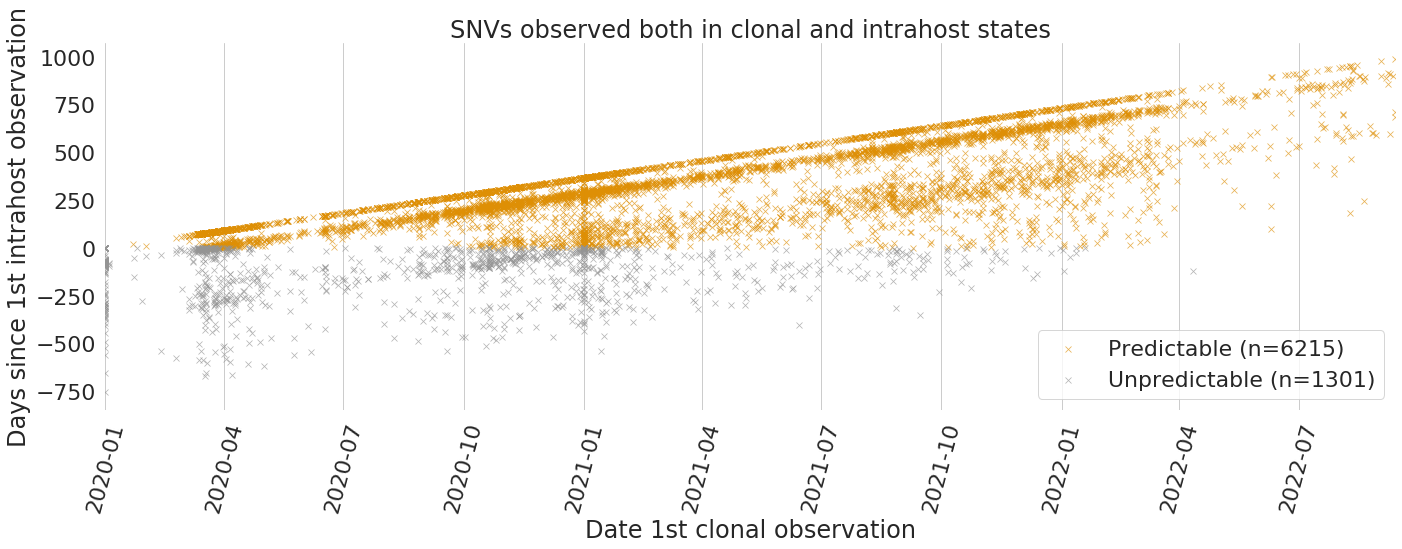

In [217]:
fig, predictable, unpredictable = plot_subclonal_to_clonal_time(
    clonal_data=clonal_variants[(clonal_variants.variant_type == 'SNV') & 
                                (clonal_variants["sample"].isin(high_quality_intrahost_variants["sample"].unique()))], 
    subclonal_data=high_quality_intrahost_variants[high_quality_intrahost_variants.variant_type == 'SNV'], 
    sample_data=sample_ena[sample_ena.run_accession.isin(high_quality_intrahost_variants["sample"].unique())],
    title="SNVs observed both in clonal and intrahost states")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs.png"), dpi=200)

In [190]:
predictable.first_clonal_observation.min()

Timestamp('2020-02-24 00:00:00')

There are 26214 variants with clonal and subclonal observations


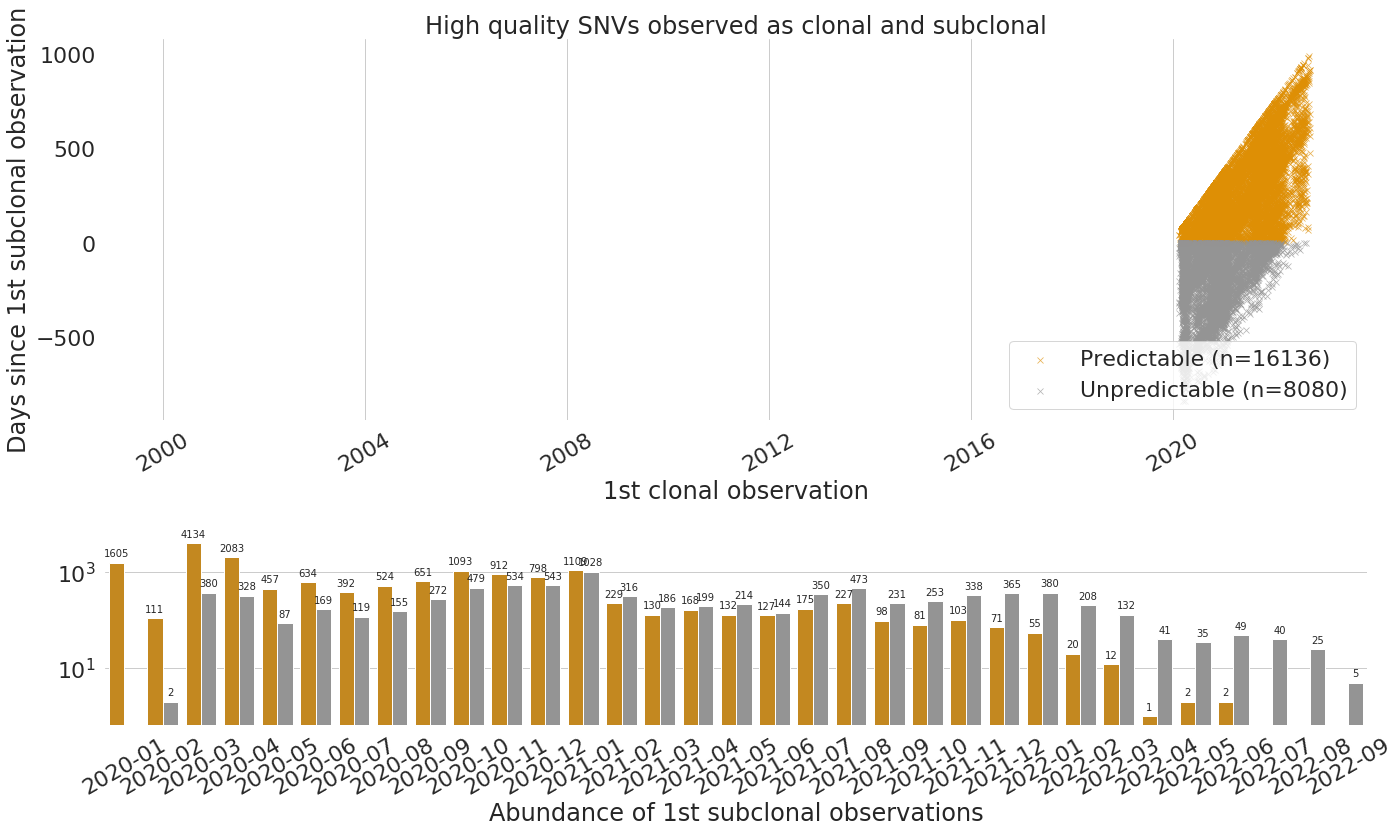

In [127]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf0_sr0, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs.svg"), dpi=200)

There are 24754 variants with clonal and subclonal observations


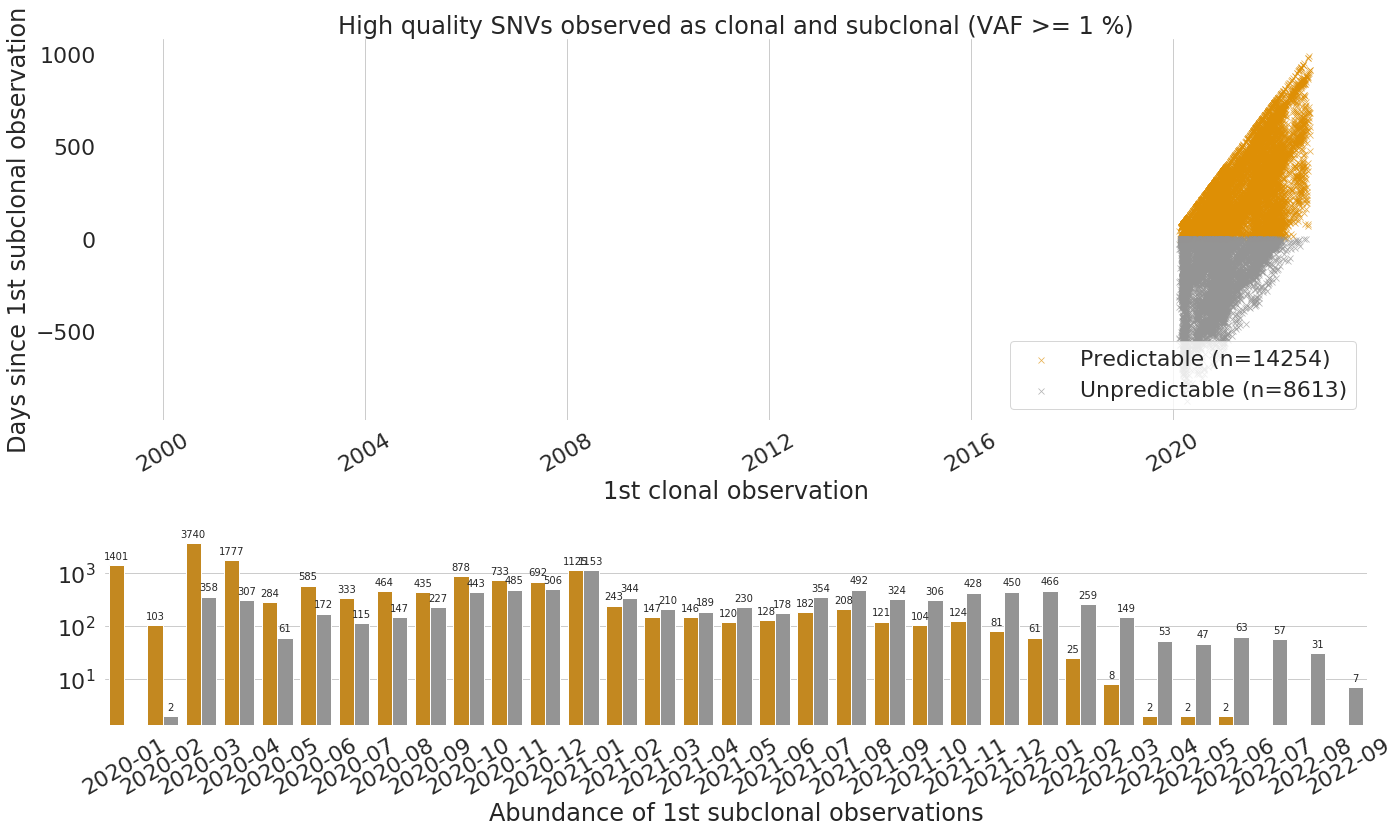

In [128]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf001, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 1 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_1.svg"), dpi=200)

There are 24754 variants with clonal and subclonal observations


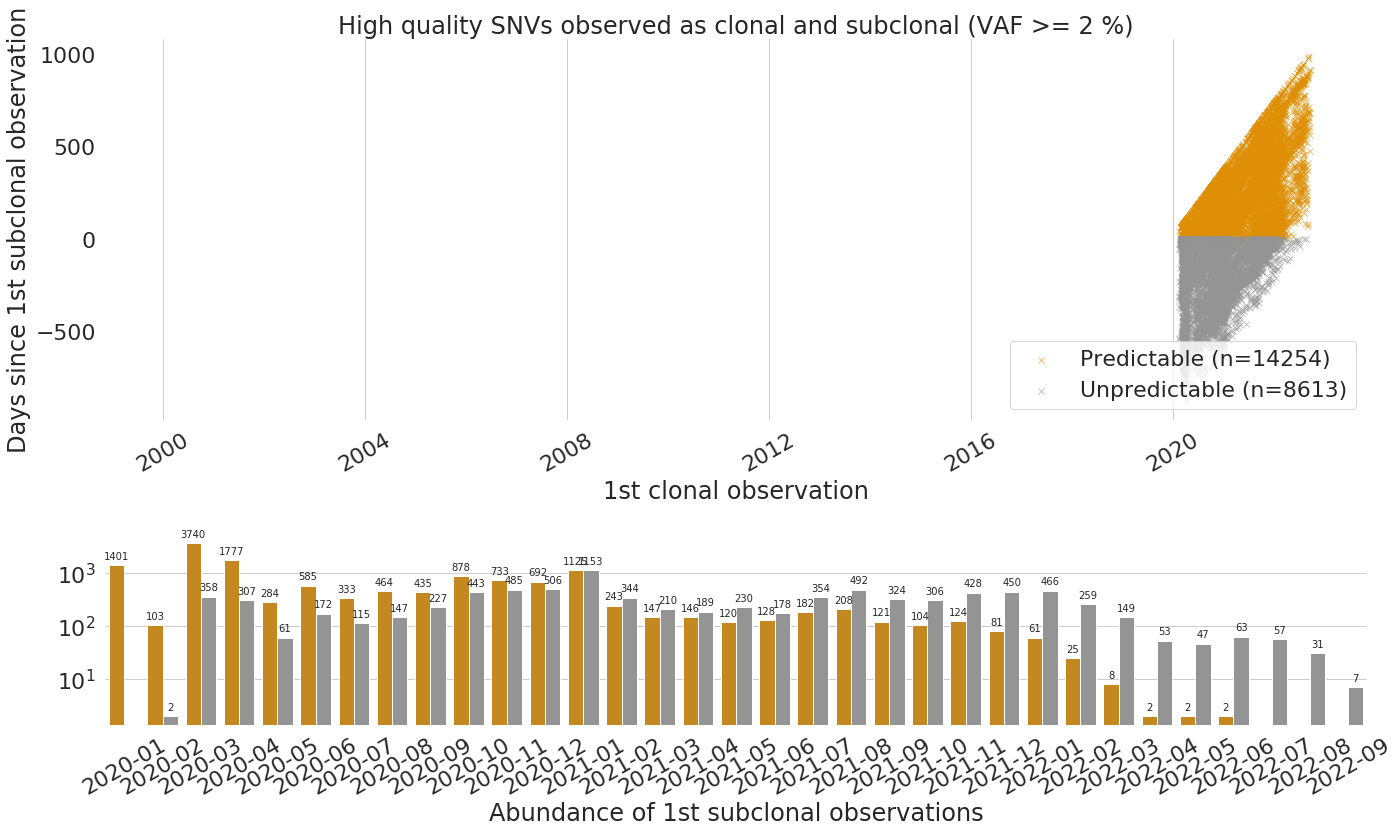

In [129]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf002, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 2 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_2.svg"), dpi=200)

There are 24754 variants with clonal and subclonal observations


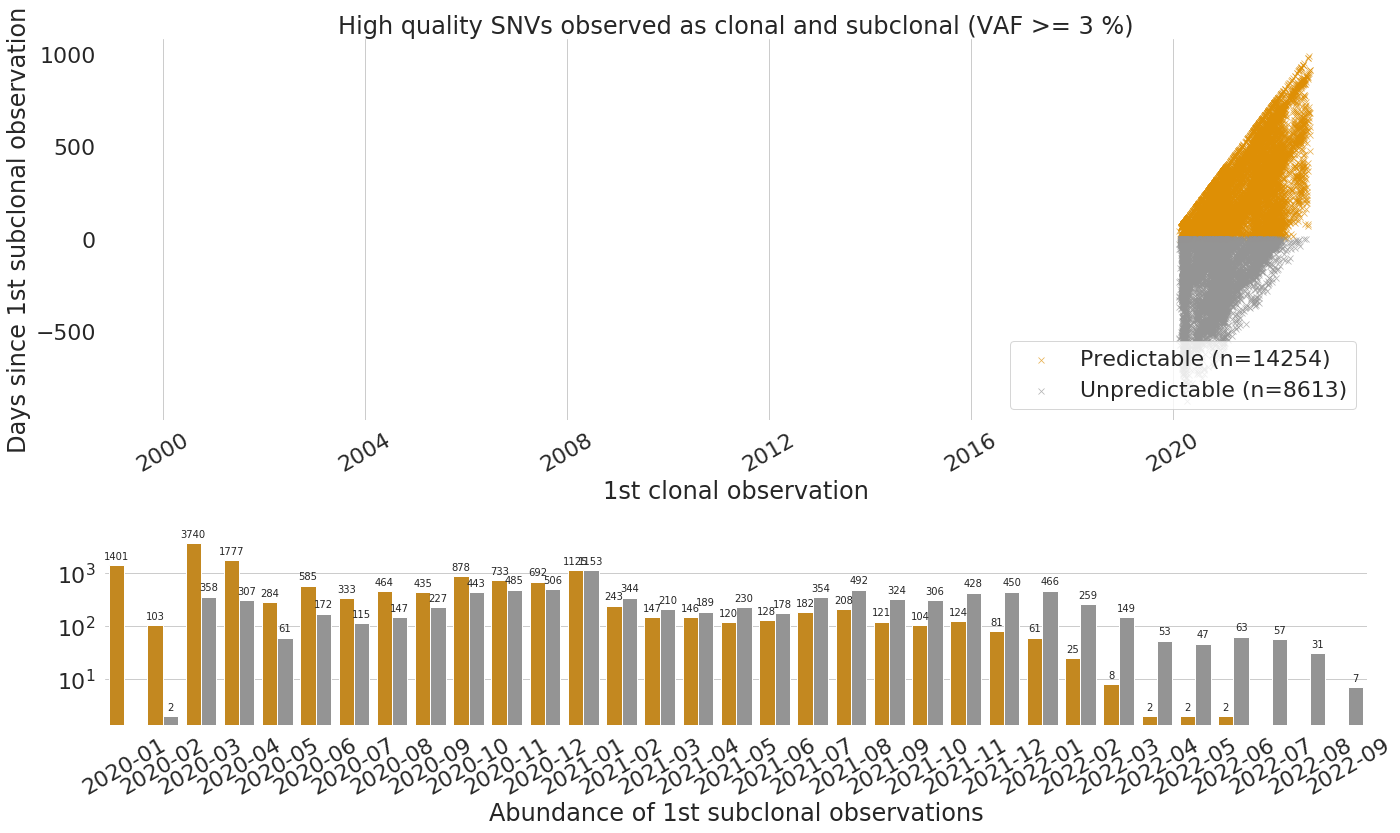

In [130]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf003, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 3 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_3.svg"), dpi=200)

There are 24754 variants with clonal and subclonal observations


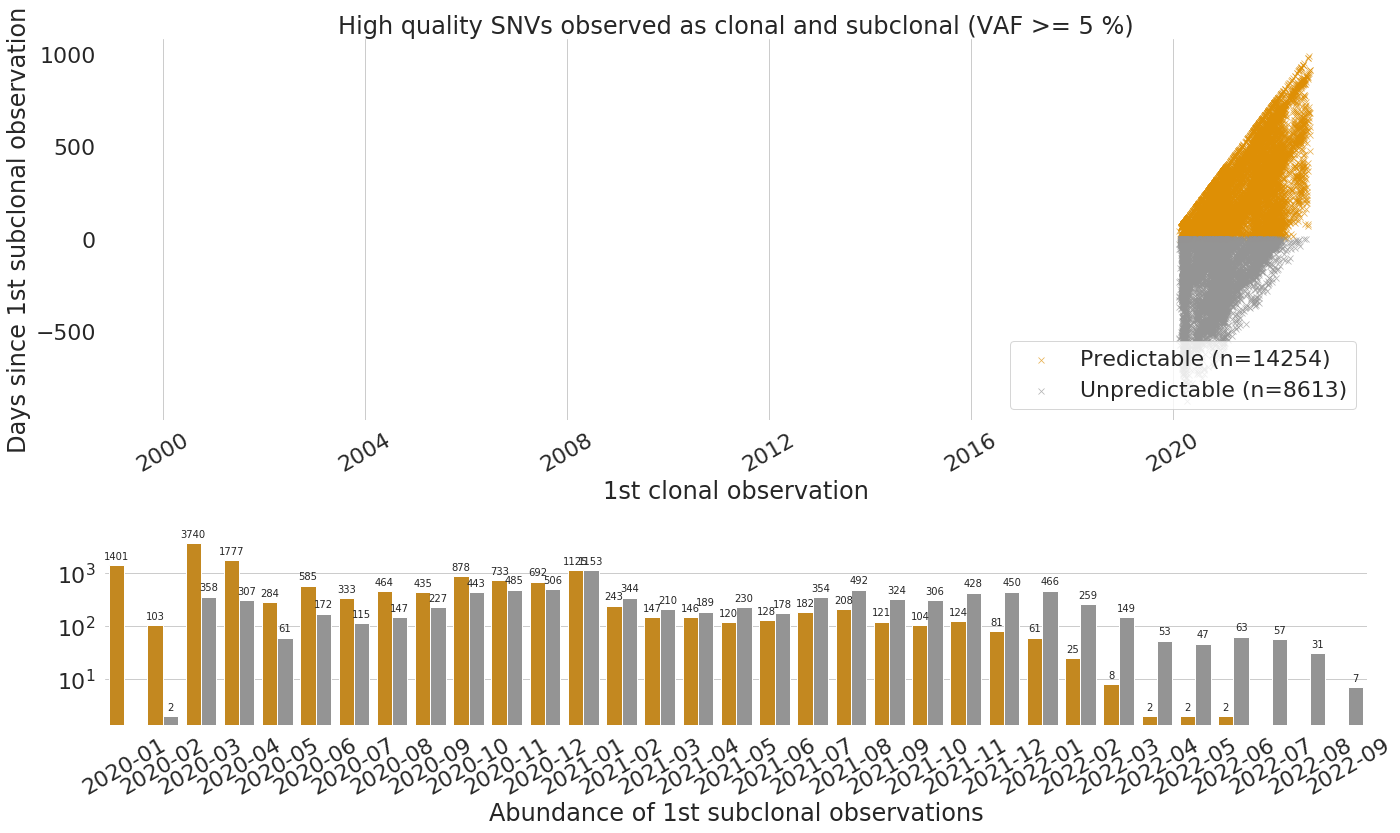

In [131]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf005, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 5 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_5.svg"), dpi=200)

There are 18974 variants with clonal and subclonal observations


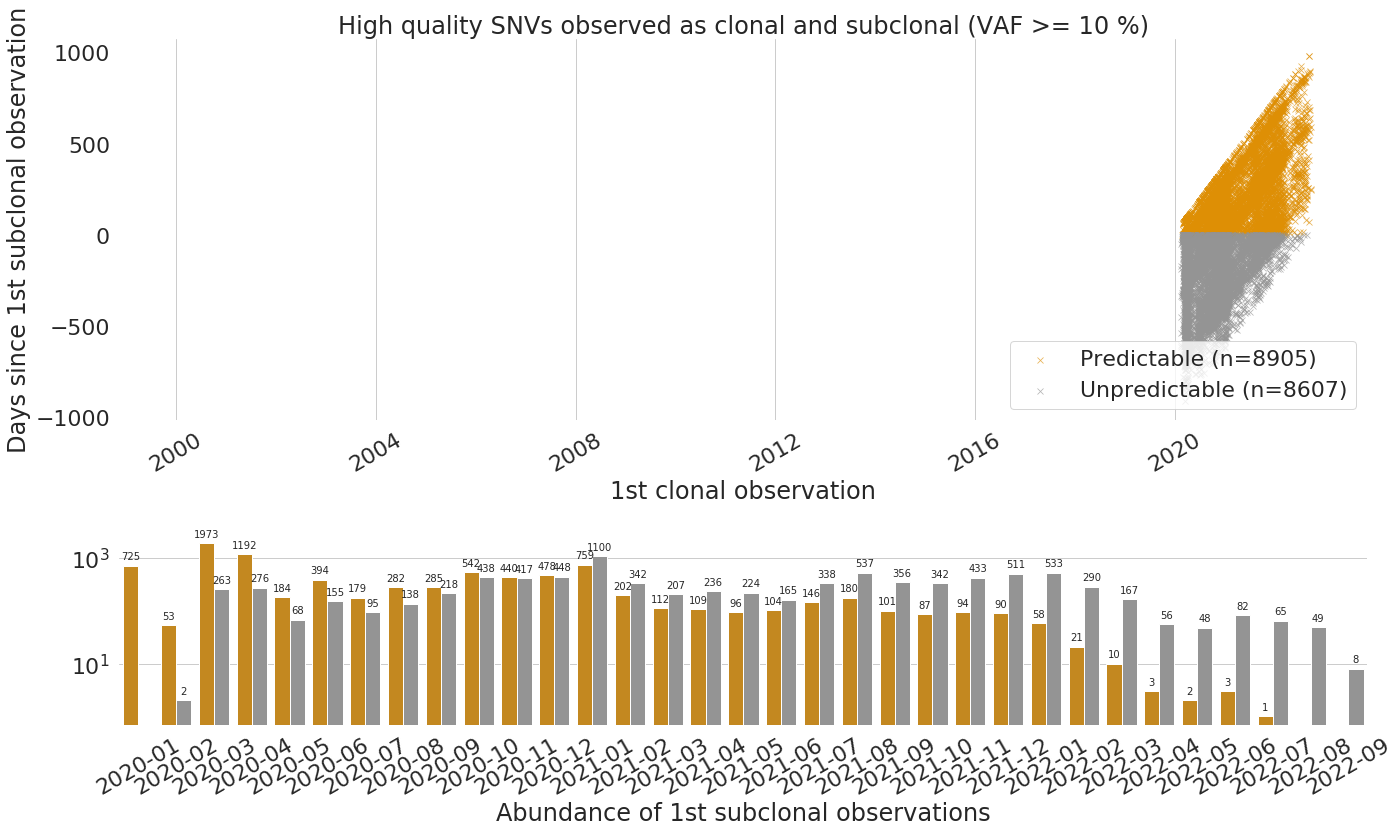

In [132]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf01, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 10 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_10.svg"), dpi=200)

There are 13576 variants with clonal and subclonal observations


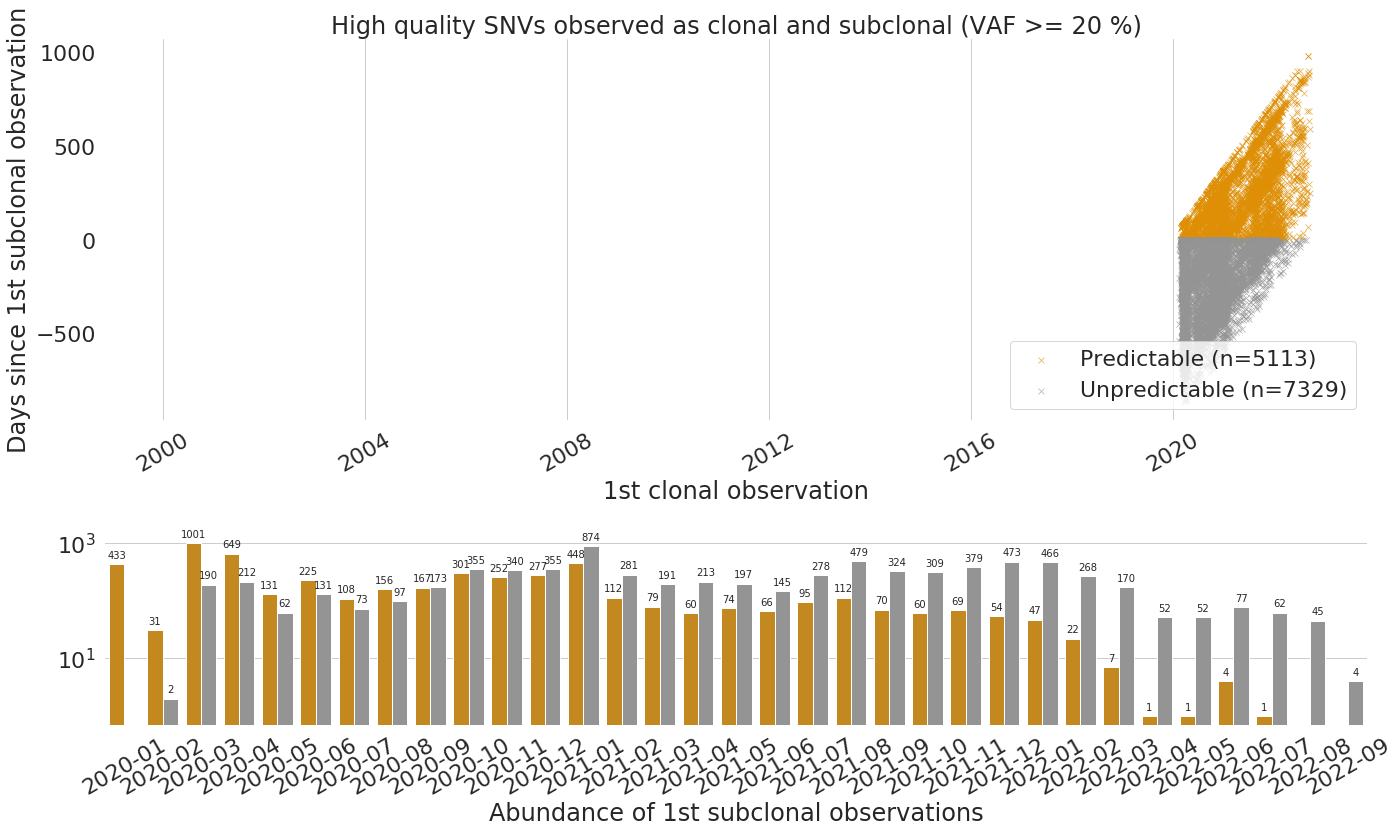

In [133]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf02, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 20 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_20.svg"), dpi=200)

There are 10607 variants with clonal and subclonal observations


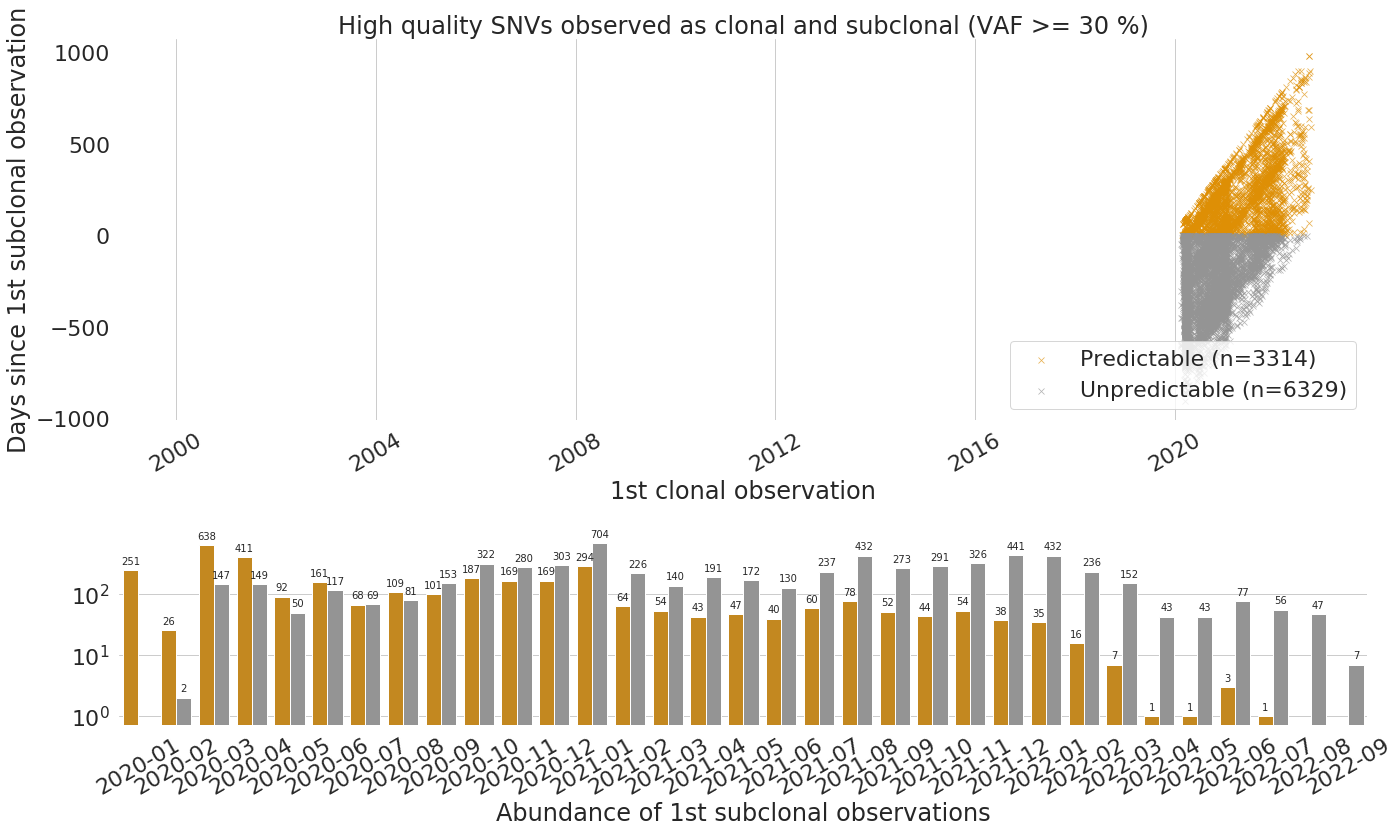

In [134]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf03, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 30 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_30.svg"), dpi=200)

## Prioritise subclonal variants

Here we aim at prioritising subclonal variants for their risk of becoming clonal.

### Simulation on accumulated temporal data

We have data accumulated since January 2020 until June 2021. Here we will use the data accumulated prior to January 2021 to prioritise variants only observed as subclonal. Then we will assess this prioritsation with the clonal variants that were first observed from January 2021 onwards.

We will use the dataset filtering out all subclonal variants with a VAF < 0.1 and with less than 3 supporting reads as its population AFs show the larger correlation with the clonal variants. RNA-seq samples are also excluded.

In [135]:
def select_test_and_truth_set(clonal_data, subclonal_data, sample_data):

    clonal_data_with_dates = add_dates_to_variants(clonal_data[
        (clonal_data.annotation_highest_impact != "synonymous_variant") & (~clonal_data.gene_name.isna())], sample_data)
    subclonal_data_with_dates = add_dates_to_variants(subclonal_data[
        (subclonal_data.annotation_highest_impact != "synonymous_variant") & (~subclonal_data.gene_name.isna())], sample_data)
    
    # gets only subclonal variants from 2020
    subclonal_2020 = subclonal_data_with_dates[subclonal_data_with_dates.collection_date < '2021-01-01']
    clonal_2020 = clonal_data_with_dates[clonal_data_with_dates.collection_date < '2021-01-01']
    only_subclonal_2020 = subclonal_2020[~subclonal_2020.variant_id.isin(clonal_2020.variant_id.unique())]
    
    # gets the new clonal variants from 2021
    clonal_first_observations = clonal_data_with_dates[["variant_id", "collection_date"]].groupby("variant_id").min().reset_index()
    clonal_2021_variant_ids = clonal_first_observations[clonal_first_observations.collection_date >= '2021-01-01'].variant_id.unique()
    clonal_2021 = clonal_data_with_dates[clonal_data_with_dates.variant_id.isin(clonal_2021_variant_ids)][["variant_id", "sample"]]
    
    print("Only subclonal from 2020: {}".format(only_subclonal_2020.variant_id.unique().shape[0]))
    print("New clonal from 2021: {}".format(clonal_2021.variant_id.unique().shape[0]))
    print("Predictable: {}".format(len(set(clonal_2021.variant_id).intersection(set(only_subclonal_2020.variant_id)))))
    
    return only_subclonal_2020, clonal_2021

In [136]:
def prioritise_subclonal(subclonal_data, clonal_data):
    subclonal_counts = subclonal_data[["sample", "variant_id"]].groupby("variant_id").count().reset_index().rename(columns={"sample": "count_subclonal"})
    clonal_counts = clonal_data[["sample", "variant_id"]].groupby("variant_id").count().reset_index().rename(columns={"sample": "count_clonal"})
    prioritised_subclonal = pd.merge(left=subclonal_counts, right=clonal_counts, on="variant_id", how="left").reset_index().sort_values("count_subclonal", ascending=False).reset_index(drop=True)
    prioritised_subclonal["match"] = prioritised_subclonal.count_clonal > 0
    del prioritised_subclonal["index"]
    prioritised_subclonal.reset_index(inplace=True)
    prioritised_subclonal["rank"] = prioritised_subclonal["index"] + 1
    prioritised_subclonal.fillna(0, inplace=True)
    return prioritised_subclonal

In [137]:
only_subclonal_2020_vaf001, clonal_2021_vaf001 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf001, 
    sample_data=sample_ena_filtered_samples)
only_subclonal_2020_vaf002, clonal_2021_vaf002 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf002, 
    sample_data=sample_ena_filtered_samples)
only_subclonal_2020_vaf003, clonal_2021_vaf003 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf003, 
    sample_data=sample_ena_filtered_samples)
only_subclonal_2020_vaf005, clonal_2021_vaf005 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf005, 
    sample_data=sample_ena_filtered_samples)
only_subclonal_2020_vaf01, clonal_2021_vaf01 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf01, 
    sample_data=sample_ena_filtered_samples)
only_subclonal_2020_vaf02, clonal_2021_vaf02 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf02, 
    sample_data=sample_ena_filtered_samples)
only_subclonal_2020_vaf03, clonal_2021_vaf03 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf03, 
    sample_data=sample_ena_filtered_samples)

Only subclonal from 2020: 13139
New clonal from 2021: 10559
Predictable: 3991
Only subclonal from 2020: 13139
New clonal from 2021: 10559
Predictable: 3991
Only subclonal from 2020: 13139
New clonal from 2021: 10559
Predictable: 3991
Only subclonal from 2020: 13139
New clonal from 2021: 10559
Predictable: 3991
Only subclonal from 2020: 6510
New clonal from 2021: 10559
Predictable: 2198
Only subclonal from 2020: 3191
New clonal from 2021: 10559
Predictable: 1146
Only subclonal from 2020: 1800
New clonal from 2021: 10559
Predictable: 673


In [138]:
prioritised_subclonal_vaf001 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf001, clonal_data=clonal_2021_vaf001)
prioritised_subclonal_vaf002 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf002, clonal_data=clonal_2021_vaf002)
prioritised_subclonal_vaf003 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf003, clonal_data=clonal_2021_vaf003)
prioritised_subclonal_vaf005 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf005, clonal_data=clonal_2021_vaf005)
prioritised_subclonal_vaf01 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf01, clonal_data=clonal_2021_vaf01)
prioritised_subclonal_vaf02 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf02, clonal_data=clonal_2021_vaf02)
prioritised_subclonal_vaf03 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf03, clonal_data=clonal_2021_vaf03)

In [139]:
def reset_rank_column(data):
    del data["rank"]
    del data["index"]
    data.reset_index(drop=True, inplace=True)
    data.reset_index(inplace=True)
    data["rank"] = data["index"] + 1
    return data

def get_discounted_cumulative_gain(data, top=50, verbose=False):
    top_data = data.head(top)
    dcg = top_data[["match", "rank"]].apply(lambda x: ((2 ** int(x[0])) - 1) / (np.log2(x[1] + 1)), axis=1).sum()
    if verbose:
        print("matches={}, ranks={}".format(top_data.match.sum(), list(top_data[top_data.match]["rank"])))
        print("DCG={}".format(round(dcg, 3)))
    return dcg

def get_ideal_discounted_cumulative_gain(data, top=50):
    ideal_data = reset_rank_column(data=data.sort_values("count_clonal", ascending=False))
    return get_discounted_cumulative_gain(data=ideal_data, top=top)

def get_normalized_discounted_cumulative_gain(data, top=50, verbose=False, shuffles=100):
    dcg = get_discounted_cumulative_gain(data=data, top=top, verbose=True)
    ndcg = dcg / get_ideal_discounted_cumulative_gain(data=data, top=top)
    print("nDCG={}".format(round(ndcg, 3)))
    
    
    random_dcgs = []
    random_ndcgs = []
    random_matches = []
    for _ in range(shuffles):
        shuffled = shuffle_order(data)
        random_dcg = get_discounted_cumulative_gain(data=shuffled, top=top, verbose=verbose)
        random_ndcg = random_dcg / get_ideal_discounted_cumulative_gain(data=shuffled, top=top)
        random_dcgs.append(random_dcg)
        random_ndcgs.append(random_ndcg)
        random_matches.append(shuffled.head(top).match.sum())

    print("Random sort (n={n}) median DCG={dcg}, uDCG={udcg}, matches={matches}, max uDCG={max_udcg}, matches={max_matches}".format(
        dcg=round(np.median(random_dcgs), 3), udcg=round(np.median(random_ndcgs), 3), matches=np.median(random_matches), 
        max_udcg=round(np.max(random_ndcgs), 3), max_matches=np.max(random_matches),
        n=shuffles))
    
    return dcg, ndcg

In [140]:
def shuffle_order(data):
    random_prioritised_subclonal_2020 = data.sample(frac=1)
    del random_prioritised_subclonal_2020["rank"]
    del random_prioritised_subclonal_2020["index"]
    random_prioritised_subclonal_2020.reset_index(drop=True)
    random_prioritised_subclonal_2020.reset_index(inplace=True)
    random_prioritised_subclonal_2020["rank"] = random_prioritised_subclonal_2020["index"] + 1
    return random_prioritised_subclonal_2020

In [141]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf001)

matches=13, ranks=[1, 4, 11, 14, 16, 24, 25, 31, 41, 42, 43, 45, 48]
DCG=3.75
nDCG=0.291
Random sort (n=100) median DCG=1.237, uDCG=0.096, matches=15.0, max uDCG=0.163, matches=25


In [142]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf002)

matches=13, ranks=[1, 4, 11, 14, 16, 24, 25, 31, 41, 42, 43, 45, 48]
DCG=3.75
nDCG=0.291
Random sort (n=100) median DCG=1.315, uDCG=0.102, matches=15.0, max uDCG=0.146, matches=22


In [143]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf003)

matches=13, ranks=[1, 4, 11, 14, 16, 24, 25, 31, 41, 42, 43, 45, 48]
DCG=3.75
nDCG=0.291
Random sort (n=100) median DCG=1.332, uDCG=0.103, matches=16.0, max uDCG=0.151, matches=23


In [144]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf005)

matches=13, ranks=[1, 4, 11, 14, 16, 24, 25, 31, 41, 42, 43, 45, 48]
DCG=3.75
nDCG=0.291
Random sort (n=100) median DCG=1.28, uDCG=0.099, matches=15.5, max uDCG=0.141, matches=22


In [ ]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf01)

matches=15, ranks=[1, 3, 9, 13, 16, 19, 20, 34, 38, 39, 41, 42, 45, 46, 48]
DCG=4.248
nDCG=0.329
Random sort (n=100) median DCG=1.551, uDCG=0.12, matches=17.0, max uDCG=0.186, matches=26


In [ ]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf02)

matches=20, ranks=[1, 3, 8, 11, 17, 25, 26, 28, 29, 32, 35, 36, 37, 42, 43, 44, 45, 47, 48, 49]
DCG=5.206
nDCG=0.404
Random sort (n=100) median DCG=1.763, uDCG=0.137, matches=17.0, max uDCG=0.198, matches=24


In [ ]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf03)

matches=26, ranks=[3, 6, 7, 10, 15, 18, 20, 22, 24, 25, 27, 28, 29, 30, 32, 34, 35, 37, 38, 40, 41, 43, 44, 45, 46, 50]
DCG=5.901
nDCG=0.458
Random sort (n=100) median DCG=2.035, uDCG=0.158, matches=18.0, max uDCG=0.245, matches=28


In [ ]:
def prioritise_subclonal_by_conservation(subclonal_data, clonal_data):
    #subclonal_data_with_conservation = pd.merge(left=subclonal_data, right=subclonal_snvs[["variant_id", "cons_hmm_sars_cov_2"]], on="variant_id", how="left").reset_index()
    subclonal_counts = subclonal_data[["sample", "variant_id"]].groupby("variant_id").count().reset_index().rename(columns={"sample": "count_subclonal"})
    subclonal_counts_with_annotations = pd.merge(left=subclonal_counts, right=subclonal_data, on="variant_id", how="left").groupby("variant_id").first().reset_index()
    clonal_counts = clonal_data[["sample", "variant_id"]].groupby("variant_id").count().reset_index().rename(columns={"sample": "count_clonal"})
    subclonal_counts_with_annotations["af_cons"] = subclonal_counts_with_annotations[["count_subclonal", "cons_hmm_sars_cov_2"]].apply(lambda x: np.log(x[0])*x[1], axis=1)
    prioritised_subclonal = pd.merge(left=subclonal_counts_with_annotations, right=clonal_counts, on="variant_id", how="left").reset_index().sort_values("af_cons", ascending=True).reset_index(drop=True)
    prioritised_subclonal["match"] = prioritised_subclonal.count_clonal > 0
    del prioritised_subclonal["index"]
    prioritised_subclonal.reset_index(inplace=True)
    prioritised_subclonal["rank"] = prioritised_subclonal["index"] + 1
    prioritised_subclonal.fillna(0, inplace=True)
    return prioritised_subclonal

In [149]:
prioritised_subclonal_by_conservation_vaf001 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf001, clonal_data=clonal_2021_vaf001)
prioritised_subclonal_by_conservation_vaf002 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf002, clonal_data=clonal_2021_vaf002)
prioritised_subclonal_by_conservation_vaf003 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf003, clonal_data=clonal_2021_vaf003)
prioritised_subclonal_by_conservation_vaf005 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf005, clonal_data=clonal_2021_vaf005)
prioritised_subclonal_by_conservation_vaf01 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf01, clonal_data=clonal_2021_vaf01)
prioritised_subclonal_by_conservation_vaf02 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf02, clonal_data=clonal_2021_vaf02)
prioritised_subclonal_by_conservation_vaf03 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf03, clonal_data=clonal_2021_vaf03)

In [150]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf001)

matches=20, ranks=[3, 4, 10, 11, 15, 17, 20, 24, 25, 28, 30, 35, 37, 39, 40, 41, 45, 46, 47, 49]
DCG=4.713
nDCG=0.365
Random sort (n=100) median DCG=1.318, uDCG=0.102, matches=15.0, max uDCG=0.17, matches=26


In [151]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf002)

matches=20, ranks=[3, 4, 10, 11, 15, 17, 20, 24, 25, 28, 30, 35, 37, 39, 40, 41, 45, 46, 47, 49]
DCG=4.713
nDCG=0.365
Random sort (n=100) median DCG=1.283, uDCG=0.099, matches=15.0, max uDCG=0.158, matches=24


In [152]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf003)

matches=20, ranks=[3, 4, 10, 11, 15, 17, 20, 24, 25, 28, 30, 35, 37, 39, 40, 41, 45, 46, 47, 49]
DCG=4.713
nDCG=0.365
Random sort (n=100) median DCG=1.329, uDCG=0.103, matches=16.0, max uDCG=0.168, matches=22


In [153]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf005)

matches=20, ranks=[3, 4, 10, 11, 15, 17, 20, 24, 25, 28, 30, 35, 37, 39, 40, 41, 45, 46, 47, 49]
DCG=4.713
nDCG=0.365
Random sort (n=100) median DCG=1.338, uDCG=0.104, matches=15.0, max uDCG=0.147, matches=22


In [154]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf01)

matches=23, ranks=[2, 4, 9, 10, 16, 18, 19, 21, 23, 24, 27, 29, 31, 33, 36, 39, 40, 41, 43, 44, 45, 49, 50]
DCG=5.481
nDCG=0.425
Random sort (n=100) median DCG=1.552, uDCG=0.12, matches=16.0, max uDCG=0.166, matches=23


In [155]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf02)

matches=25, ranks=[1, 5, 6, 10, 11, 13, 14, 15, 16, 18, 20, 23, 24, 25, 27, 28, 29, 37, 41, 42, 43, 45, 46, 47, 50]
DCG=6.511
nDCG=0.505
Random sort (n=100) median DCG=1.865, uDCG=0.145, matches=18.0, max uDCG=0.227, matches=26


In [156]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf03)

matches=29, ranks=[1, 3, 5, 6, 7, 10, 11, 15, 17, 18, 19, 20, 25, 26, 27, 30, 32, 33, 35, 36, 38, 41, 42, 43, 45, 46, 47, 48, 50]
DCG=7.578
nDCG=0.588
Random sort (n=100) median DCG=2.163, uDCG=0.168, matches=19.0, max uDCG=0.268, matches=28


In [157]:
prioritised_subclonal_by_conservation_vaf03.head(50)

index variant_id  count_subclonal       sample  cons_hmm_sars_cov_2  \
0       0  23607:G>T                6  SRR12749720             -1.02973   
1       1  11857:T>A                4  SRR19658914             -1.04511   
2       2  19563:G>T                4   ERR6897554             -1.04511   
3       3  22646:G>C                3  SRR13018890             -1.27455   
4       4  12766:T>G                3  SRR18233217             -1.27455   
5       5  15369:A>T                3  SRR12427490             -1.04511   
6       6  22301:A>C                3  SRR14211753             -1.02973   
7       7  23607:G>A                3  SRR14095185             -1.02973   
8       8  21420:A>C               20   ERR6295931             -0.35633   
9       9  28254:A>T                3   ERR5072990             -0.80744   
10     10  28099:C>T                3  SRR12427339             -0.80744   
11     11  25324:C>A                2   ERR4249267             -1.27455   
12     12  27765:C>G                2   ERR5397022             -1.27455   
13     13  27158:T>G                9  SRR13620189             -0.35633   
14     14  21450:A>G                2   ERR5956445             -1.04511   
15     15  22373:C>T                2   ERR5730100             -1.04511   
16     16  23625:C>G                2  SRR12423699             -1.04511   
17     17  15909:T>C                2  SRR12718239             -1.04511   
18     18   2430:A>G                2  SRR12427349             -1.04511   
19     19  24198:C>T                2   ERR4249295             -1.04511   
20     20  17418:G>T                2  SRR12426824             -1.04511   
21     21  14847:A>G                2   ERR5928933             -1.04511   
22     22   4829:C>T                2   ERR6090938             -1.04511   
23     23  13695:A>G                2  SRR12423786             -1.04511   
24     24  15744:C>T                2  SRR12427043             -1.04511   
25     25  22989:G>A                2   ERR5496829             -1.02973   
26     26  23612:G>A                2  SRR13177780             -1.02973   
27     27  21736:C>G                2   ERR6318730             -0.85561   
28     28   3181:A>C                2  SRR12427106             -0.80744   
29     29  27895:T>C                2   ERR6897598             -0.80744   
30     30   4067:G>A                2  SRR12427509             -0.80744   
31     31  23064:A>G                2   ERR5430996             -0.72927   
32     32  21920:G>A                2   ERR7747729             -0.72927   
33     33   1143:T>G                2   ERR5983594             -0.72927   
34     34  14913:C>T                2  SRR12427085             -0.72839   
35     35  15342:C>A                2   ERR5076527             -0.72839   
36     36  29021:T>G                2  SRR12427225             -0.59191   
37     37   3416:A>G                3   ERR5509254             -0.35633   
38     38   2837:T>G                2  SRR18021664             -0.35633   
39     39  25667:C>A                2  SRR12423268             -0.35633   
40     40   3701:G>A                2   ERR6662362             -0.35633   
41     41  17265:T>C                2  SRR12423203             -0.35633   
42     42   5000:C>T                2  SRR12427057             -0.35633   
43     43   3354:G>T                2  SRR12423631             -0.35633   
44     44  26526:G>C                2   ERR5065412             -0.35633   
45     45   3741:T>C                2   ERR6292548             -0.35633   
46     46  27646:A>G                1  SRR13242950              0.57215   
47     47  27619:C>T                1   ERR5065327              0.57215   
48     48  27562:A>C                1   ERR6336308              0.57215   
49     49  27535:C>T                1  SRR13089102              0.57215   

   gene_name         hgvs_p run_accession collection_date  \
0          S        p.R682L   SRR12749720      2020-08-04   
1     ORF1ab       p.D3864E   SRR19658914      2020-10-0

In [158]:
prioritised_subclonal_by_conservation_vaf03.head(50)[prioritised_subclonal_by_conservation_vaf03.gene_name == "S"][["variant_id", "hgvs_p", "gene_name", "cons_hmm_sars_cov_2", "count_subclonal", "count_clonal"]]

variant_id    hgvs_p gene_name  cons_hmm_sars_cov_2  count_subclonal  \
0   23607:G>T   p.R682L         S             -1.02973                6   
3   22646:G>C   p.V362L         S             -1.27455                3   
6   22301:A>C   p.S247R         S             -1.02973                3   
7   23607:G>A   p.R682Q         S             -1.02973                3   
11  25324:C>A  p.C1254*         S             -1.27455                2   
15  22373:C>T   p.Q271*         S             -1.04511                2   
16  23625:C>G   p.A688G         S             -1.04511                2   
19  24198:C>T   p.A879V         S             -1.04511                2   
25  22989:G>A   p.G476D         S             -1.02973                2   
26  23612:G>A   p.A684T         S             -1.02973                2   
27  21736:C>G    p.F58L         S             -0.85561                2   
31  23064:A>G   p.N501S         S             -0.72927                2   
32  21920:G>A   p.V120I         S             -0.72927                2   

    count_clonal  
0            1.0  
3            0.0  
6           14.0  
7            0.0  
11           0.0  
15           0.0  
16           1.0  
19          99.0  
25           1.0  
26           5.0  
27           0.0  
31           2.0  
32           2.0

In [159]:
prioritised_subclonal_by_conservation_vaf001[prioritised_subclonal_by_conservation_vaf001.hgvs_p == "p.L452Q"]

index variant_id  count_subclonal      sample  cons_hmm_sars_cov_2  \
2377   2377  22917:T>A                1  ERR6669441             -1.02973   

     gene_name   hgvs_p run_accession collection_date collection_date_month  \
2377         S  p.L452Q    ERR6669441      2020-12-01               2020-12   

     collection_date_month_str  af_cons  count_clonal  match  rank  
2377                   2020-12     -0.0         760.0   True  2378

In [160]:
prioritised_subclonal_by_conservation_vaf001[prioritised_subclonal_by_conservation_vaf001.hgvs_p == "p.G75V"]

Empty DataFrame
Columns: [index, variant_id, count_subclonal, sample, cons_hmm_sars_cov_2, gene_name, hgvs_p, run_accession, collection_date, collection_date_month, collection_date_month_str, af_cons, count_clonal, match, rank]
Index: []

In [161]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf03)  #get_ideal_discounted_cumulative_gain(data=prioritised_subclonal_vaf03)

matches=29, ranks=[1, 3, 5, 6, 7, 10, 11, 15, 17, 18, 19, 20, 25, 26, 27, 30, 32, 33, 35, 36, 38, 41, 42, 43, 45, 46, 47, 48, 50]
DCG=7.578
nDCG=0.588
Random sort (n=100) median DCG=2.156, uDCG=0.167, matches=19.0, max uDCG=0.24, matches=26


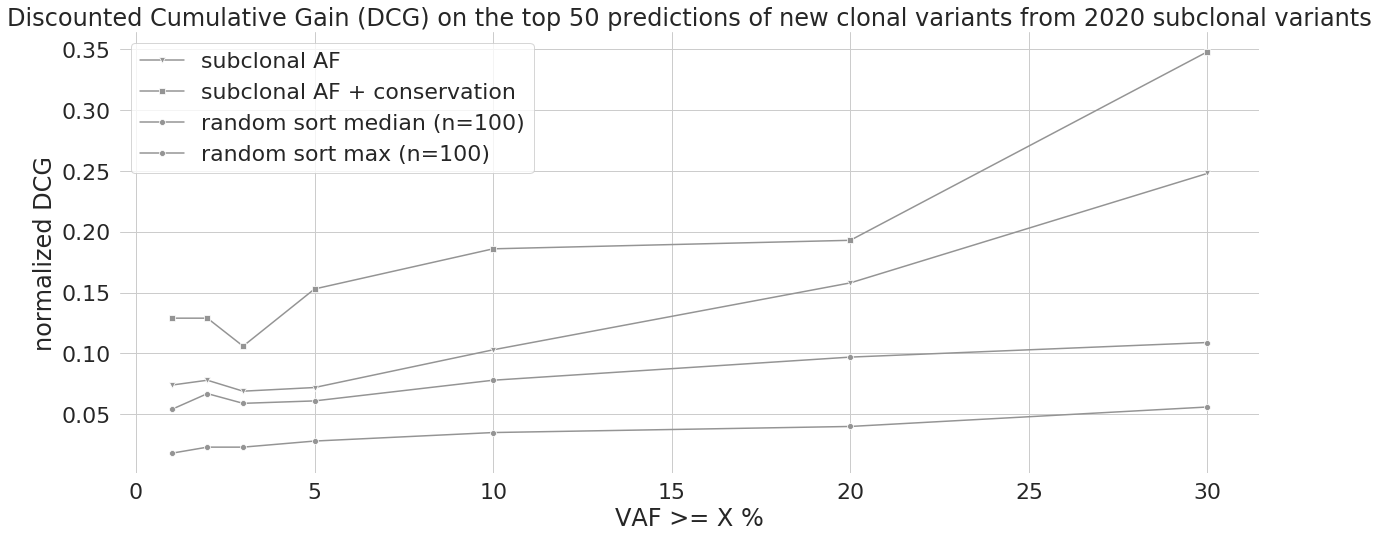

In [162]:
data = pd.DataFrame({"vaf_threshold":[1, 2, 3, 5, 10, 20, 30], 
                     "prioritization_by_subclonal_count":[0.074, 0.078, 0.069, 0.072, 0.103, 0.158, 0.248],
                     "prioritization_by_subclonal_count_and_conservation":[0.129, 0.129, 0.106, 0.153, 0.186, 0.193, 0.348],
                     "prioritization_random_median":[0.018, 0.023, 0.023, 0.028, 0.035, 0.04, 0.056],
                     "prioritization_random_max":[0.054, 0.067, 0.059, 0.061, 0.078, 0.097, 0.109]
                    })

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.lineplot(data=data, x="vaf_threshold", y="prioritization_by_subclonal_count", color=grey, label="subclonal AF", marker='v')
sns.lineplot(data=data, x="vaf_threshold", y="prioritization_by_subclonal_count_and_conservation", color=grey, label="subclonal AF + conservation", marker='s')
sns.lineplot(data=data, x="vaf_threshold", y="prioritization_random_median", color=grey, label="random sort median (n=100)", marker='o', linestyle='--', )
sns.lineplot(data=data, x="vaf_threshold", y="prioritization_random_max", color=grey, label="random sort max (n=100)", marker='o', linestyle='dotted', )
#plt.axhline(1.0, linestyle='--', color=red, label="ideal (sort by clonal frequency)")
plt.title("Discounted Cumulative Gain (DCG) on the top 50 predictions of new clonal variants from 2020 subclonal variants")
plt.xlabel("VAF >= X %")
plt.ylabel("normalized DCG")
sns.despine(bottom=True, left=True)
ax.legend()
plt.tight_layout()
fig.savefig(os.path.join(figure_output_folder, "figure_08_prediction_clonal_ndcg.svg"), dpi=200)

In [163]:
def get_percentage_clonal(data):
    return data[data.count_clonal > 0].shape[0] / data[data.count_clonal == 0].shape[0]

print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf001))
print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf002))
print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf003))
print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf005))
print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf01))
print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf02))
print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf03))

0.43627022299956275
0.43627022299956275
0.43627022299956275
0.43627022299956275
0.5097402597402597
0.5603911980440098
0.5971606033717834


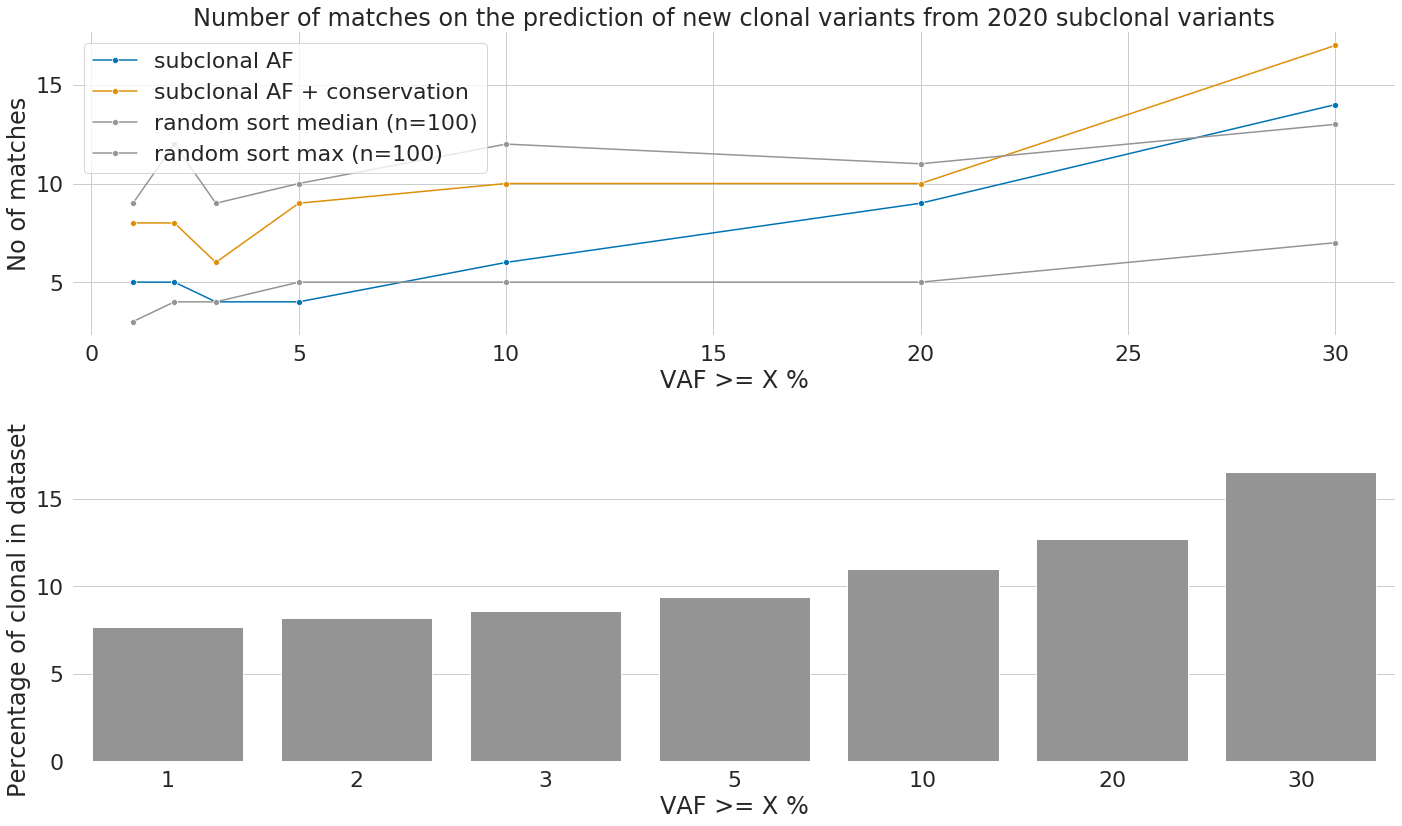

In [164]:
data = pd.DataFrame({"vaf_threshold":[1, 2, 3, 5, 10, 20, 30], 
                     "matches_by_subclonal_count":[5,5,4,4,6,9,14],
                     "matches_by_subclonal_count_and_conservation":[8,8,6,9,10,10,17],
                     "matches_random_median":[3,4,4,5,5,5,7],
                     "matches_random_max":[9,12,9,10,12,11,13],
                     "percent_clonal": [0.07680830747195035,0.08194740582800285,0.08579453922095089,0.09396302557670284,
                                        0.11007138722747443,0.127136021872864,0.16535819430814525]
                    })
data["percent_clonal"] =  data["percent_clonal"].transform(lambda x: round(x*100, 3))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
sns.lineplot(data=data, x="vaf_threshold", y="matches_by_subclonal_count", color=blue, label="subclonal AF", marker='o', ax=ax1)
sns.lineplot(data=data, x="vaf_threshold", y="matches_by_subclonal_count_and_conservation", color=orange, label="subclonal AF + conservation", marker='o', ax=ax1)
sns.lineplot(data=data, x="vaf_threshold", y="matches_random_median", color=grey, label="random sort median (n=100)", marker='o', linestyle='--', ax=ax1)
sns.lineplot(data=data, x="vaf_threshold", y="matches_random_max", color=grey, label="random sort max (n=100)", marker='o', linestyle='dotted', ax=ax1)
ax1.set_title("Number of matches on the prediction of new clonal variants from 2020 subclonal variants")
ax1.set_xlabel("VAF >= X %")
ax1.set_ylabel("No of matches")
sns.despine(bottom=True, left=True)
ax1.legend()

sns.barplot(data=data, x="vaf_threshold", y="percent_clonal", color=grey, ax=ax2)

ax2.set_xlabel("VAF >= X %")
ax2.set_ylabel("Percentage of clonal in dataset")

plt.tight_layout()
fig.savefig(os.path.join(figure_output_folder, "figure_08_prediction_clonal_matches.svg"), dpi=200) 

### Prediction on current data

In [165]:
clonal_data_with_dates = add_dates_to_variants(clonal_snvs_non_synonymous, sample_ena_filtered_samples)
subclonal_data_with_dates = add_dates_to_variants(
    subclonal_snvs_filtered_vaf03[(subclonal_snvs_filtered_vaf03.annotation_highest_impact != "synonymous_variant") & 
                                 (~subclonal_snvs_filtered_vaf03.gene_name.isna())], sample_ena_filtered_samples)
only_subclonal = subclonal_data_with_dates[~subclonal_data_with_dates.variant_id.isin(clonal_data_with_dates.variant_id.unique())]

In [166]:
only_subclonal_counts = only_subclonal[["sample", "variant_id"]].groupby("variant_id").count().reset_index().rename(columns={"sample": "count_subclonal"})
only_subclonal_counts_with_annotations = pd.merge(left=only_subclonal_counts, right=only_subclonal, on="variant_id", how="left").groupby("variant_id").first().reset_index()
only_subclonal_counts_with_annotations["af_cons"] = only_subclonal_counts_with_annotations[["count_subclonal", "cons_hmm_sars_cov_2"]].apply(lambda x: np.log(x[0])*x[1], axis=1)
top_50_predictions = only_subclonal_counts_with_annotations.sort_values("af_cons", ascending=True).head(50)
only_subclonal_counts_with_annotations[["variant_id", "hgvs_p", "gene_name", "count_subclonal", "cons_hmm_sars_cov_2", "af_cons"]]\
    .sort_values("af_cons", ascending=True).head(50).to_csv(
    os.path.join(figure_output_folder, "prediction_clonal_variants_20072021.csv"))
top_50_predictions[["variant_id", "hgvs_p", "gene_name", "count_subclonal", "cons_hmm_sars_cov_2", "af_cons"]]

variant_id         hgvs_p gene_name  count_subclonal  \
1219  22645:T>A        p.C361*         S               17   
145   11857:T>A       p.D3864E    ORF1ab                4   
1331  23607:G>A        p.R682Q         S                4   
1220  22646:G>C        p.V362L         S                3   
458   14847:A>G       p.Y4861C    ORF1ab                3   
1058  21420:A>C  p.*7052Sext*?    ORF1ab               23   
1813  28200:T>A        p.S103T      ORF8                3   
1962   3071:T>C        p.C936R    ORF1ab                2   
1733  27436:T>C         p.C15R     ORF7a                2   
1158  22160:T>A        p.Y200N         S                2   
1518  25324:C>A       p.C1254*         S                2   
1765  27765:C>G          p.L4V     ORF7b                2   
1504  25134:A>C       p.K1191T         S                2   
1698  27158:T>G        p.S212R         M                9   
343   13695:A>G       p.Q4477R    ORF1ab                2   
2135   4829:C>T       p.Q1522*    ORF1ab                2   
1176  22373:C>T        p.Q271*         S                2   
1355  23756:A>C        p.T732P         S                2   
597   16221:G>C       p.R5319P    ORF1ab                2   
684   17331:G>A       p.R5689K    ORF1ab                2   
2097   4442:G>C       p.V1393L    ORF1ab                2   
1249  22811:A>C        p.K417Q         S                2   
1256  22858:C>A        p.C432*         S                2   
695   17418:G>T       p.S5718I    ORF1ab                2   
696   17427:G>C       p.C5721S    ORF1ab                2   
909   19689:A>T       p.Q6475L    ORF1ab                2   
1991   3326:C>A       p.Q1021K    ORF1ab                2   
1133  22006:C>A        p.N148K         S                2   
1084  21736:C>G         p.F58L         S                2   
1785  27918:A>G          p.I9V      ORF8                2   
1795  28026:T>A         p.W45R      ORF8                2   
1143  22076:T>A        p.S172T         S                2   
2061   4067:G>A       p.A1268T    ORF1ab                2   
1977   3181:A>C        p.E972D    ORF1ab                2   
1976   3177:C>A        p.P971H    ORF1ab                2   
107    1143:T>G        p.L293R    ORF1ab                2   
1726  27367:C>A         p.Q56K      ORF6                2   
1766  27768:T>C          p.S5P     ORF7b                2   
389   14157:A>G       p.H4631R    ORF1ab                2   
1885  28986:G>A        p.G238D         N                2   
1828  28475:C>T         p.R68*         N                2   
1889  29021:T>G        p.S250A         N                2   
1874  28908:G>C        p.G212A         N                2   
1994   3354:G>T       p.G1030V    ORF1ab                3   
759   17991:G>A       p.C5909Y    ORF1ab                3   
1721  27344:A>T         p.K48I      ORF6                3   
1818   2837:T>G        p.S858A    ORF1ab                2   
1299  23291:C>T        p.R577C         S                2   
110   11459:T>C       p.S3732P    ORF1ab                2   
1411  24220:G>T        p.W886C         S                2   

      cons_hmm_sars_cov_2   af_cons  
1219             -1.27455 -3.611072  
145              -1.04511 -1.448830  
1331             -1.02973 -1.427509  
1220             -1.27455 -1.400236  
458              -1.04511 -1.148171  
1058             -0.35633 -1.117271  
1813             -0.80744 -0.887063  
1962             -1.27455 -0.883451  
1733             -1.27455 -0.883451  
1158             -1.27455 -0.883451  
1518             -1.27455 -0.883451  
1765             -1.27455 -0.883451  
1504             -1.27455 -0.883451  
1698             -0.35633 -0.782937  
343              -1.04511 -0.724415  
2135             -1.04511 -0.724415  
1176             -1.04511 -0.724415  
1355             -1.04511 -0.724415  
597              -1.04511 -0.724415  
684              -1.04511 -0.724415  
2097             -1.04511 -0.724415  
1249             -1.04511 -0.724415  
1256             -1